- fhs_flashsale_product: (Thông tin flashsale của product)
    * period_id : id của flashsale
    * product_id : id của product 
    * original_price : giá gốc
    * flashsale_price : giá sale
    * total_items : số lượng sale
    
- fhs_flashsale_period: (Chứa thông tin flashsale về thời gian)
    * id: id của flashsale (== period_id của fhs_flashsale_product)
    * start_date, end_date: time bắt đầu kết thúc sale 
    * các cột khác không quan tâm
    
- fhs_catalog_product_entity: (Thông tin discount và ngày bắt đầu bán)
    * entity_id: id của product (==product_id trong fhs_flashsale_product)
    * sku : là mã sản phẩm (duy nhất và là khóa của sản phẩm dùng để truy các thông tin khác về sản phẩm)
    * created_at : ngày bắt đầu bán
    * discount_percent : phần trăm giảm giá so với giá bìa (trừ flashsale còn giá sản phẩm mọi lúc sẽ là giá gốc trừ đi disount này)

- fhs_cataloginventory_stock_item: Bãng này là số lượng sản phẩm tồn nhưng ko dùng được, do bên db bị mất dữ liệu
    
- fhs_sales_flat_order: Chứa thông tin đơn hàng
    * entity_id : id của đơn hàng (==order_id trong fhs_sales_flat_order_item)
    * state : trạng thái đơn hàng
    * status : trạng thái của trạng thái đơn hàng (ví dụ đơn hàng ở state đang giao, status là complete nghĩa là ở trang thái đang * giao đã hoàn thành)
    * created_at : ngày tạo đơn
    * updated_at : ngày cập nhật trạng thái
    * store_id : id của kho, id < 4 cho thương mại điện tử  (nhớ thêm điều kiện store_id<4 khi query bảng này)

- fhs_sales_flat_order_item: Chưa thông tin từng sản phẩm trong đơn hàng
    * order_id: id của đơn hàng (==entity_id trong fhs_sales_flat_order)
    * created_at: Ngày tạo đơn con
    * product_id, sku : id và mã sản phẩm

- fhs_catalog_product_entity_decimal: Bảng giá sản phẩm
    * entity_id: id của product (==entity_id trong fhs_catalog_product_entity)
    * attribute_id : loại giá (giá gốc 75, giá bán 76 (hoặc ngược lại chị không nhớ, chỉ quan tâm 2 loại này))
    * value : giá bán của sản phẩm với attribute tương ứng
    
- fhs_product_stock_log: Bảng này là thông tin các sản phẩm đang bán hiện tại trên thị trường
    * product_id, sku : id và mã của sp
    * qty: số lượng trong kho
    * is_in_stock: 1 là còn bán
    * created_at: không rõ
    * bảng này cũng không đáng tin lắm 
    
- product_dim : Thông tin sp
    * sku: mã
    * name: tên
    * cat1 tới cat5: là categories của sp
    * price : giá gốc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

- Đọc các file csv vào các biến tương ứng

In [3]:
fhs_flashsale_product = pd.read_csv('../Data/Data_Fahasa/fhs_flashsale_product.csv')
fhs_flashsale_period = pd.read_csv('../Data/Data_Fahasa/fhs_flashsale_period.csv')
fhs_catalog_product_entity = pd.read_csv('../Data/Data_Fahasa/fhs_catalog_product_entity.csv')
fhs_sales_flat_order = pd.read_csv('../Data/Data_Fahasa/fhs_sales_flat_order.csv')
fhs_sales_flat_order_item = pd.read_csv('../Data/Data_Fahasa/fhs_sales_flat_order_item.csv')
fhs_catalog_product_entity_decimal = pd.read_csv('../Data/Data_Fahasa/fhs_catalog_product_entity_decimal.csv')
fhs_product_stock_log = pd.read_csv('../Data/Data_Fahasa/fhs_product_stock_log.csv')
product_dim = pd.read_csv('../Data/Data_Fahasa/product_dim.csv')

- Đổi tên các cột theo tên của từng file cho dễ nhận dạng

In [4]:
def rename_columns(dataframe, dataframe_name):
    """
    rename columns with patern: dataframe_name.columns_name
    Input:
        dataframe: Dataframe Pandas
        dataframe_name: string
    """
    columns = dataframe.columns
    # rename columns
    new_names = []
    for index in range(len(columns)):
        new_name = f'{dataframe_name}.{columns[index]}'
        new_names.append(new_name)
    
    dataframe.columns = new_names

rename_columns(fhs_flashsale_product, 'fhs_flashsale_product')
rename_columns(fhs_flashsale_period, 'fhs_flashsale_period')
rename_columns(fhs_catalog_product_entity, 'fhs_catalog_product_entity')
rename_columns(fhs_sales_flat_order, 'fhs_sales_flat_order')
rename_columns(fhs_sales_flat_order_item, 'fhs_sales_flat_order_item')
rename_columns(fhs_catalog_product_entity_decimal, 'fhs_catalog_product_entity_decimal')
rename_columns(fhs_product_stock_log, 'fhs_product_stock_log')
rename_columns(product_dim, 'product_dim')

- Xóa các cột không cần thiết của fhs_flashsale_period

In [5]:
temp = fhs_flashsale_period.loc[:,
    ['fhs_flashsale_period.id', 'fhs_flashsale_period.start_date', 'fhs_flashsale_period.end_date']]
# xóa đi để tiết kiệm bộ nhớ
del fhs_flashsale_period
fhs_flashsale_period = temp

# xóa đi các cột thời gian trùng lập
fhs_flashsale_period.drop_duplicates(subset = ['fhs_flashsale_period.start_date',
                                                'fhs_flashsale_period.end_date'  ], inplace = True)

- Chuyển các chuỗi thời gian về định dạng datetime

In [6]:
def string_to_datetime(dataframe, column_name):
          dataframe[f'{column_name}'] \
          = pd.to_datetime(dataframe[f'{column_name}'],
                              format = '%Y/%m/%d %H:%M:%S')

string_to_datetime(fhs_flashsale_period, 'fhs_flashsale_period.start_date')
string_to_datetime(fhs_flashsale_period, 'fhs_flashsale_period.end_date')
string_to_datetime(fhs_catalog_product_entity, 'fhs_catalog_product_entity.created_at')
string_to_datetime(fhs_sales_flat_order, 'fhs_sales_flat_order.created_at')
string_to_datetime(fhs_sales_flat_order, 'fhs_sales_flat_order.updated_at')
string_to_datetime(fhs_sales_flat_order_item, 'fhs_sales_flat_order_item.created_at')
string_to_datetime(fhs_product_stock_log, 'fhs_product_stock_log.created_at')

In [7]:
print('fhs_flashsale_product', len(fhs_flashsale_product))
print('fhs_flashsale_period', len(fhs_flashsale_period))
print('fhs_product_stock_log',len(fhs_product_stock_log))
print('fhs_catalog_product_entity',len(fhs_catalog_product_entity))
print('fhs_catalog_product_entity_decimal',len(fhs_catalog_product_entity_decimal))
print('fhs_sales_flat_order',len(fhs_sales_flat_order))
print('fhs_sales_flat_order_item',len(fhs_sales_flat_order_item))
print('product_dim',len(product_dim))

fhs_flashsale_product 3930772
fhs_flashsale_period 6402
fhs_product_stock_log 10251317
fhs_catalog_product_entity 352880
fhs_catalog_product_entity_decimal 1213003
fhs_sales_flat_order 3541823
fhs_sales_flat_order_item 17828291
product_dim 2961504


- Merge thông tin của các sản phẩm flashsale lại với nhau để lấy các thông tin cần thiết như: ()
  * Mã sku
  * Thời gian flashsale của từng sản phẩm
  * ......

In [8]:
temp = pd.merge(fhs_flashsale_product, fhs_flashsale_period, 
          left_on='fhs_flashsale_product.period_id', right_on='fhs_flashsale_period.id')
fhs_flashsale_product_info = pd.merge(temp, fhs_catalog_product_entity, 
          left_on='fhs_flashsale_product.product_id', right_on='fhs_catalog_product_entity.entity_id')
del temp
fhs_flashsale_product_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3923776 entries, 0 to 3923775
Data columns (total 12 columns):
 #   Column                                       Dtype         
---  ------                                       -----         
 0   fhs_flashsale_product.period_id              int64         
 1   fhs_flashsale_product.product_id             int64         
 2   fhs_flashsale_product.original_price         float64       
 3   fhs_flashsale_product.flashsale_price        float64       
 4   fhs_flashsale_product.total_items            float64       
 5   fhs_flashsale_period.id                      int64         
 6   fhs_flashsale_period.start_date              datetime64[ns]
 7   fhs_flashsale_period.end_date                datetime64[ns]
 8   fhs_catalog_product_entity.entity_id         int64         
 9   fhs_catalog_product_entity.sku               object        
 10  fhs_catalog_product_entity.created_at        datetime64[ns]
 11  fhs_catalog_product_entity.discount_p

- Tương tự với đơn hàng, ta sẽ merge giữa đơn hàng chính và đơn hàng con để tập trung vào các thuộc tính:
  * Trạng thái đơn hàng chính
  * Ngày tạo đơn hàng con

In [9]:
fhs_sales_flat_order_item_state  \
        = pd.merge(fhs_sales_flat_order, fhs_sales_flat_order_item,
                        left_on = 'fhs_sales_flat_order.entity_id', 
                        right_on = 'fhs_sales_flat_order_item.order_id')

fhs_sales_flat_order_item_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13969403 entries, 0 to 13969402
Data columns (total 12 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   fhs_sales_flat_order.entity_id        int64         
 1   fhs_sales_flat_order.increment_id     float64       
 2   fhs_sales_flat_order.state            object        
 3   fhs_sales_flat_order.status           object        
 4   fhs_sales_flat_order.created_at       datetime64[ns]
 5   fhs_sales_flat_order.updated_at       datetime64[ns]
 6   fhs_sales_flat_order.store_id         int64         
 7   fhs_sales_flat_order_item.item_id     int64         
 8   fhs_sales_flat_order_item.order_id    int64         
 9   fhs_sales_flat_order_item.created_at  datetime64[ns]
 10  fhs_sales_flat_order_item.product_id  float64       
 11  fhs_sales_flat_order_item.sku         object        
dtypes: datetime64[ns](3), float64(2), int64(4), object(3)
memory usage: 

- Vì số lượng dòng quá lớn nên ta sẽ thực hiện chiến lược tách các sản phẩm theo từng nhóm:
  * Theo năm: và mỗi năm chỉ lấy ra những sản phẩm bán chạy nhất hoặc lấy những sản phẩm trung bình
  * Có thể nghĩ đến chiến thuật lấy ngẫu nhiên sau đó dùng thống kê mô tả để dự đoán ảnh hưởng của flashsale đến lưu lượng bán hàng

In [10]:
# Giả sử xét trong năm 2022
import datetime 
min_year = pd.to_datetime('2022/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2022/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = np.where((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2022 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = np.where((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2022 = fhs_flashsale_product_info.loc[condition3] 


fhs_flashsale_period_2022 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [11]:
# fhs_sales_flat_order_item_state_2022 = pd.read_csv('Data/fhs_sales_flat_order_item_state_2022.csv')
# fhs_flashsale_product_info_2022 = pd.read_csv('Data/fhs_flashsale_product_info_2022.csv')

In [12]:
print(len(fhs_sales_flat_order_item_state_2022))
print(len(fhs_flashsale_product_info_2022))

997797
790534


- Tạo thêm 4 cột giá trị, để có sau này truy vấn đơn giản hơn cho fhs_sales_flat_order_item_state:
  * flashsale_product: Có phải là đơn hàng flashsale hay không
  * flashsale_day: True là trong ngày có flashsale, False ngược lại
  * flashsale_time: True là trong khung giờ có flashsale, False ngược lại
  * flashsale_day_product: True là ngày hơn đó sản phẩm đó được flashsale, False ngược lại
  * flashsale_time_product: True thời gian này sản phẩm đó được flashsale, False ngược lại


- Đầu tiên là xác định có phải đơn hàng flashsale hay không

In [13]:
fhs_sales_flat_order_item_state_2022['flashsale_product'] = fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.sku']\
          .isin(fhs_flashsale_product_info_2022['fhs_catalog_product_entity.sku'])


- Tiếp theo là xem có ở trong ngày flashsale hay không

In [14]:
len(fhs_sales_flat_order_item_state_2022)

997797

In [15]:
# fhs_flashsale_product_info_2022.drop(['Unnamed: 0'], axis = 1, inplace=True)

- Xem xét sản phẩm đó có bán trong ngày flashsale hay không

In [16]:
dayofyear_flashsale = set(fhs_flashsale_product_info_2022\
          .groupby(fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'].dt.dayofyear).keys)

In [17]:
fhs_sales_flat_order_item_state_2022['flashsale_day'] = \
          np.where(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear.isin(dayofyear_flashsale)
                    , True, False)

- Xem xét sản phẩm có phái hôm đó là flashsale_day của sản phẩm đó không

In [18]:
# Đầu tiên cho những thuộc tính flashsale_day_product bằng false hết sau đó ta sẽ gán True vào những dòng cần thiết
fhs_sales_flat_order_item_state_2022['flashsale_day_product'] = False

In [19]:
temp = \
          pd.merge(fhs_sales_flat_order_item_state_2022, fhs_flashsale_product_info_2022,
                    left_on = 'fhs_sales_flat_order_item.sku'
                    ,right_on = 'fhs_catalog_product_entity.sku')

# Lấy các dòng sao cho lọt vào thời điểm flashsale
temp = temp.loc[
          (temp['fhs_sales_flat_order_item.created_at'].dt.day_of_year \
                    == temp['fhs_flashsale_period.start_date'].dt.day_of_year)]

# drop đi duplicate ở mỗi đơn hàng
temp.drop_duplicates(subset = fhs_sales_flat_order_item_state_2022.columns, inplace = True)

# Cắt cột
fhs_sales_flat_order_item_flashsale_time_product_2022 =\
           temp.loc[:, fhs_sales_flat_order_item_state_2022.columns]

#  Xử lí để gán vào cho flashsale_day_product
keys = list(fhs_sales_flat_order_item_state_2022.columns)
i1 = fhs_sales_flat_order_item_state_2022.set_index(keys).index
i2 = fhs_sales_flat_order_item_flashsale_time_product_2022.set_index(keys).index


fhs_sales_flat_order_item_state_2022['flashsale_day_product'] = \
          np.where(i1.isin(i2),
          True, False)

- Xem xét sản phẩm có bán trong khung giờ có flash sale hay không

In [20]:
# Đầu tiên cho những thuộc tính flashsale_time bằng false hết sau đó ta sẽ gán True vào những dòng cần thiết
fhs_sales_flat_order_item_state_2022['flashsale_time'] = False

In [21]:
# Lấy các ngày sale có trong flash sale
start_end = fhs_flashsale_product_info_2022.groupby(
                    [fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'],
                    fhs_flashsale_product_info_2022['fhs_flashsale_period.end_date']])['fhs_flashsale_product.period_id'].count()
                    

In [22]:
# tạo ra dataframe để merge lại r so sánh
start_end_df = pd.DataFrame(
          {'start': start_end.index.get_level_values(0),
           'end': start_end.index.get_level_values(1)})

# merge các cột có cùng ngày với nhau
temp = \
          pd.merge(fhs_sales_flat_order_item_state_2022, start_end_df,
                    left_on = fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear
                    ,right_on = start_end_df['start'].dt.dayofyear)

# lọc đi các dòng không thuộc thời gian flashsale
temp = temp.loc[(temp['fhs_sales_flat_order_item.created_at'] \
                    > temp['start'])
&         (temp['fhs_sales_flat_order_item.created_at'] \
                    < temp['end'])]
          
# drop đi duplicate ở mỗi đơn hàng
temp.drop_duplicates(subset = fhs_sales_flat_order_item_state_2022.columns, inplace = True)

# Cắt cột
fhs_sales_flat_order_item_flashsale_time_2022 =\
           temp.loc[:, fhs_sales_flat_order_item_state_2022.columns]

#  Xử lí để gán vào cho flashsale_time
keys = list(fhs_sales_flat_order_item_state_2022.columns)
i1 = fhs_sales_flat_order_item_state_2022.set_index(keys).index
i2 = fhs_sales_flat_order_item_flashsale_time_2022.set_index(keys).index


fhs_sales_flat_order_item_state_2022['flashsale_time'] = \
          np.where(i1.isin(i2),
          True, False)


- Xet thử sản phẩm trong giờ đó có flashsale hay không

In [23]:
# Đầu tiên cho những thuộc tính flashsale_time_product bằng false hết sau đó ta sẽ gán True vào những dòng cần thiết
fhs_sales_flat_order_item_state_2022['flashsale_time_product'] = False

In [24]:
temp = \
          pd.merge(fhs_sales_flat_order_item_state_2022, fhs_flashsale_product_info_2022,
                    left_on = 'fhs_sales_flat_order_item.sku'
                    ,right_on = 'fhs_catalog_product_entity.sku')

# Lấy các dòng sao cho lọt vào thời điểm flashsale
temp = temp.loc[
          (temp['fhs_sales_flat_order_item.created_at'] \
                    > temp['fhs_flashsale_period.start_date'])
&         (temp['fhs_sales_flat_order_item.created_at'] \
                    < temp['fhs_flashsale_period.end_date'])]

# drop đi duplicate ở mỗi đơn hàng
temp.drop_duplicates(subset = fhs_sales_flat_order_item_state_2022.columns, inplace = True)

# Cắt cột
fhs_sales_flat_order_item_flashsale_time_product_2022 =\
           temp.loc[:, fhs_sales_flat_order_item_state_2022.columns]

#  Xử lí để gán vào cho flashsale_time
keys = list(fhs_sales_flat_order_item_state_2022.columns)
i1 = fhs_sales_flat_order_item_state_2022.set_index(keys).index
i2 = fhs_sales_flat_order_item_flashsale_time_product_2022.set_index(keys).index


fhs_sales_flat_order_item_state_2022['flashsale_time_product'] = \
          np.where(i1.isin(i2),
          True, False)


In [25]:
a = fhs_sales_flat_order_item_state_2022.loc[
          (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.state'] == 'complete')
&         (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.status'] == 'complete')]

In [26]:
len(fhs_flashsale_product_info_2022)

790534

In [27]:
a = a.groupby(['flashsale_product', 'flashsale_day','flashsale_day_product', 'flashsale_time', 'flashsale_time_product']).count()

In [28]:
a.reset_index()

flashsale_product  flashsale_day  flashsale_day_product  flashsale_time  \
0              False          False                  False           False   
1              False           True                  False           False   
2              False           True                  False            True   
3               True          False                  False           False   
4               True           True                  False           False   
5               True           True                  False            True   
6               True           True                   True           False   
7               True           True                   True            True   
8               True           True                   True            True   

   flashsale_time_product  fhs_sales_flat_order.entity_id  \
0                   False                           60543   
1                   False                           59074   
2                   False                          224376   
3                   False                           45895   
4                   False                           51471   
5                   False                          212669   
6                   False                            5687   
7                   False                           23842   
8                    True                           36843   

   fhs_sales_flat_order.increment_id  fhs_sales_flat_order.state  \
0                              60543                       60543   
1                              59074                       59074   
2                             224376                      224376   
3                              45895                       45895   
4                              51471                       51471   
5                             212669                      212669   
6                               5687                        5687   
7                              23842                       23842   
8                              36843                       36843   

   fhs_sales_flat_order.status  fhs_sales_flat_order.created_at  \
0                        60543                            60543   
1                        59074                            59074   
2                       224376                           224376   
3                        45895                            45895   
4                        51471                            51471   
5                       212669                           212669   
6                         5687                             5687   
7                        23842                            23842   
8                        36843                            36843   

   fhs_sales_flat_order.updated_at  fhs_sales_flat_order.store_id  \
0                            60543                          60543   
1                            59074                          59074   
2                           224376                         224376   
3                            45895                          45895   
4                            51471                          51471   
5                           212669                         212669   
6                             5687                           5687   
7                            23842                          23842   
8                            36843                          36843   

   fhs_sales_flat_order_item.item_id  fhs_sales_flat_order_item.order_id  \
0                              60543                               60543   
1                              59074                               59074   
2                             224376                              224376   
3                              45895                               45895   
4                              51471                               51471   
5                             212669                              212669   
6                               5687

- Bên kia khác kết quả ở chỗ merge bằng sku nên có vài ngày nó không bao gồm trong đó nên sẽ thống kê thiếu.
- Bên đây chúng ta đã thống kê đầy đủ hơn

- Ta show ra các tính trạng các đơn hàng

In [29]:
fhs_sales_flat_order_item_state_2022  \
          .groupby(['fhs_sales_flat_order.state'])['fhs_sales_flat_order.entity_id'].count()


fhs_sales_flat_order.state
canceled      246573
complete      720400
completed         12
new              692
processing     30120
Name: fhs_sales_flat_order.entity_id, dtype: int64

In [30]:
# fhs_sales_flat_order_item_state_2022.to_csv('Data/fhs_sales_flat_order_item_state_2022.csv')
# fhs_flashsale_product_info_2022.to_csv('Data/fhs_flashsale_product_info_2022.csv')

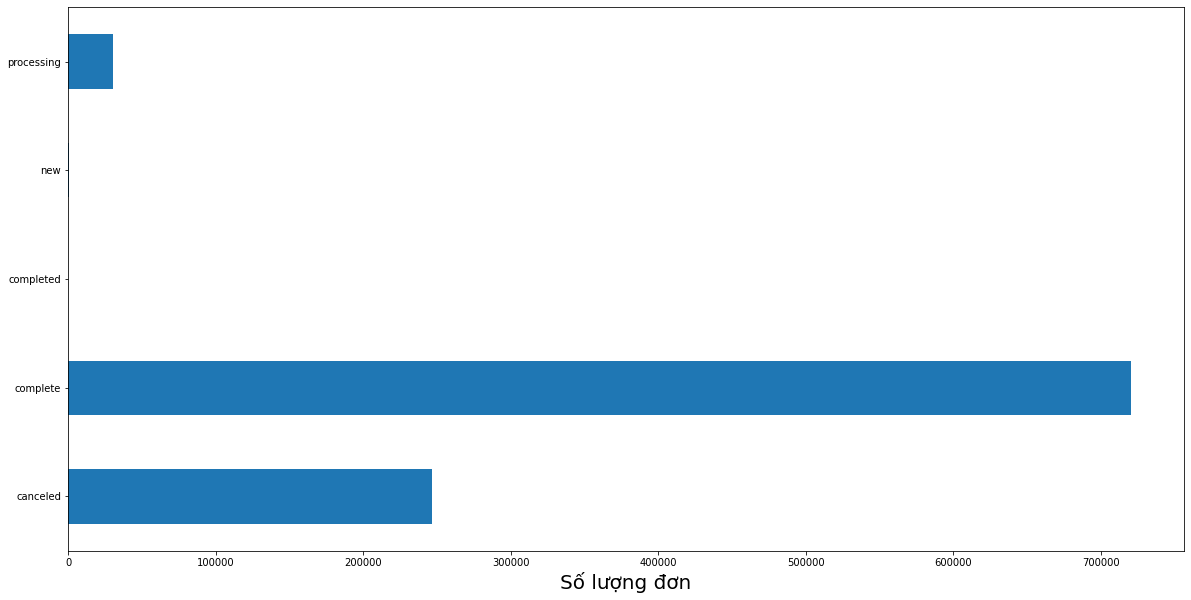

In [31]:
df = fhs_sales_flat_order_item_state_2022  \
          .groupby(['fhs_sales_flat_order.state'])['fhs_sales_flat_order.entity_id'].count()

ax = df.plot.barh(figsize = (20, 10))
ax.set_ylabel('')
ax.set_xlabel('Số lượng đơn')
ax.xaxis.label.set_fontsize(20)

- Ta tập trung xử lí vào đơn complete và canceled

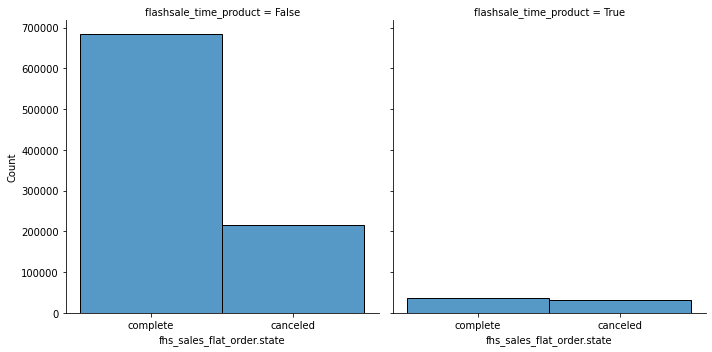

In [32]:
fhs_sales_flat_order_item_state_2022 = \
          fhs_sales_flat_order_item_state_2022\
                    .loc[(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.state'].isin(['complete', 'canceled']))
                    &    (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.status'].isin(['complete', 'canceled']))]

df = fhs_sales_flat_order_item_state_2022  \
          .groupby(['fhs_sales_flat_order.state', 'flashsale_time_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

sns.displot(data = fhs_sales_flat_order_item_state_2022, 
          x = 'fhs_sales_flat_order.state', col = 'flashsale_time_product')

- Lưu lại biến canceled để xí phân tích

- Xử lí với các đơn complete

In [33]:
fhs_sales_flat_order_item_state_2022 = \
          fhs_sales_flat_order_item_state_2022\
                    .loc[(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.state'].isin(['complete']))
                    &    (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.status'].isin(['complete']))]


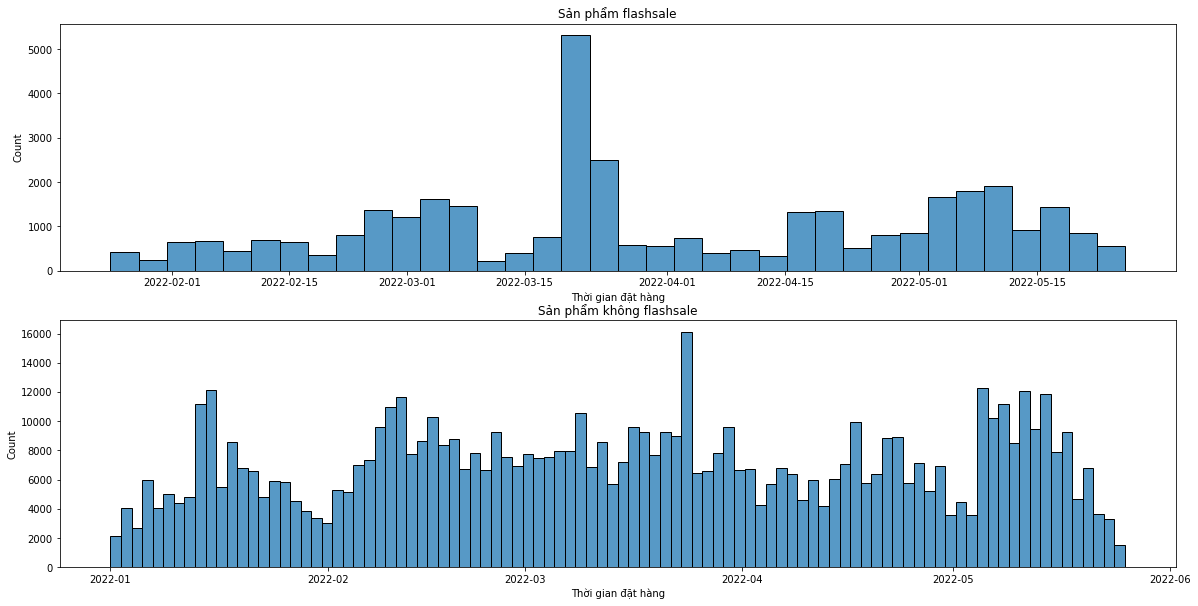

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))
sns.histplot(data = fhs_sales_flat_order_item_state_2022
                              .loc[fhs_sales_flat_order_item_state_2022['flashsale_time_product'] == True], 
          x = 'fhs_sales_flat_order_item.created_at', ax = ax[0])
ax[0].set_title('Sản phẩm flashsale')
ax[0].set_xlabel('Thời gian đặt hàng')
sns.histplot(data = fhs_sales_flat_order_item_state_2022
                              .loc[fhs_sales_flat_order_item_state_2022['flashsale_time_product'] == False], 
          x = 'fhs_sales_flat_order_item.created_at', ax = ax[1])
ax[1].set_title('Sản phẩm không flashsale')
ax[1].set_xlabel('Thời gian đặt hàng');

Text(0.5, 1.0, 'Lượng mua hàng trung bình trong tháng của các đơn hàng flashsale')

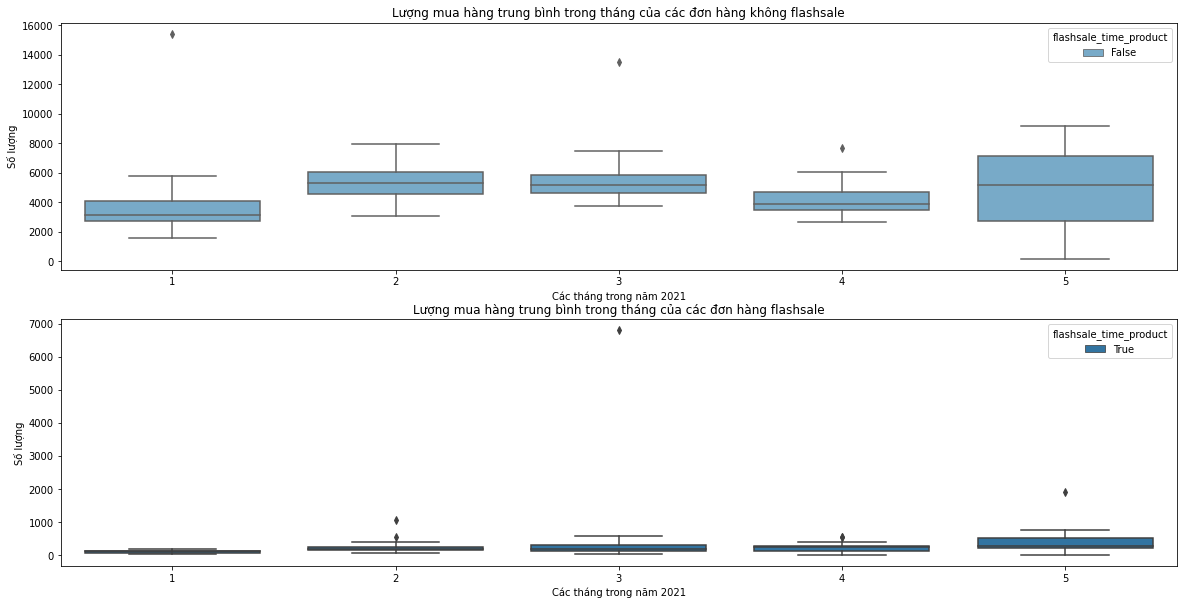

In [35]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_time_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

# tạo cột bằng 1 để cho biết đơn hàng tính là 1
fhs_sales_flat_order_item_state_2022['temp'] = 1

fig, ax = plt.subplots(2, 1, figsize=(20,10))

df1 = df.loc[df['flashsale_time_product'] == False]
sns.boxplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[0], palette="Blues")
ax[0].set_xlabel('Các tháng trong năm 2021')
ax[0].set_ylabel('Số lượng')
ax[0].set_title('Lượng mua hàng trung bình trong tháng của các đơn hàng không flashsale')

df2 = df.loc[df['flashsale_time_product'] == True]
sns.boxplot(data = df2, 
          x = df2['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df2['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[1],palette = "tab10")
ax[1].set_xlabel('Các tháng trong năm 2021')
ax[1].set_ylabel('Số lượng')
ax[1].set_title('Lượng mua hàng trung bình trong tháng của các đơn hàng flashsale')



Text(0.5, 1.0, 'Lượng mua hàng trung bình trong tháng các ngày trong tuần các đơn hàng flashsale')

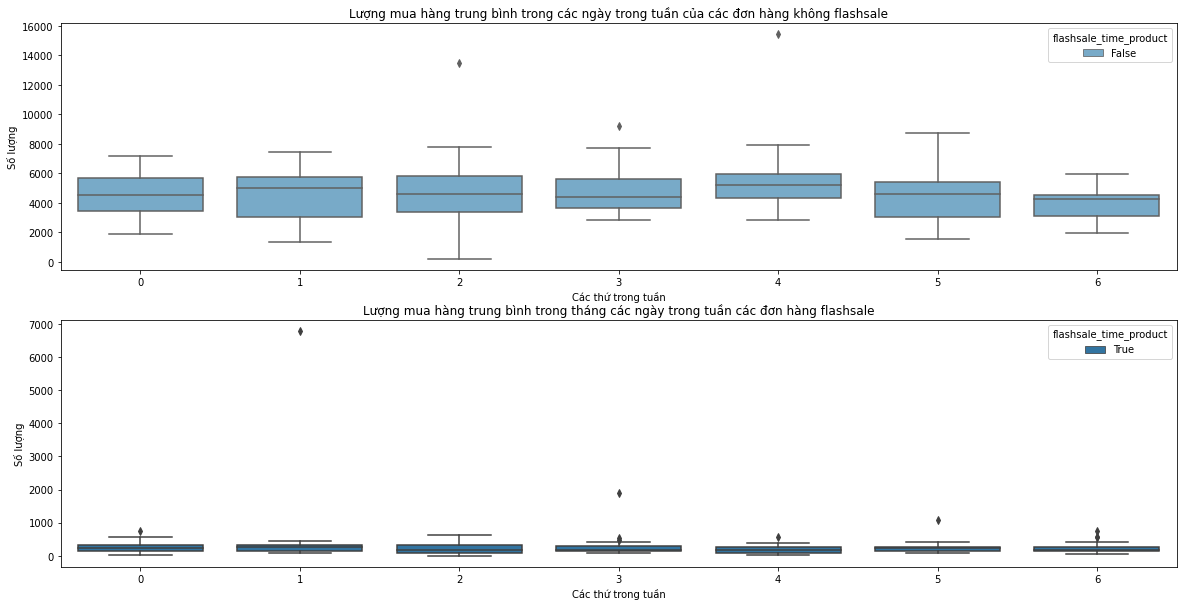

In [36]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_time_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

# tạo cột bằng 1 để cho biết đơn hàng tính là 1
fhs_sales_flat_order_item_state_2022['temp'] = 1

fig, ax = plt.subplots(2, 1, figsize=(20,10))

df1 = df.loc[df['flashsale_time_product'] == False]
sns.boxplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[0], palette="Blues")
ax[0].set_xlabel('Các thứ trong tuần')
ax[0].set_ylabel('Số lượng')
ax[0].set_title('Lượng mua hàng trung bình trong các ngày trong tuần của các đơn hàng không flashsale')

df2 = df.loc[df['flashsale_time_product'] == True]
sns.boxplot(data = df2, 
          x = df2['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
          y = df2['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[1],palette = "tab10")
ax[1].set_xlabel('Các thứ trong tuần')
ax[1].set_ylabel('Số lượng')
ax[1].set_title('Lượng mua hàng trung bình trong tháng các ngày trong tuần các đơn hàng flashsale')

- So sánh tổng sản lượng bán ra của tháng giữa đơn hàng flashsale và đơn hàng ko flashsale

Text(0, 0.5, 'Số sản phẩm')

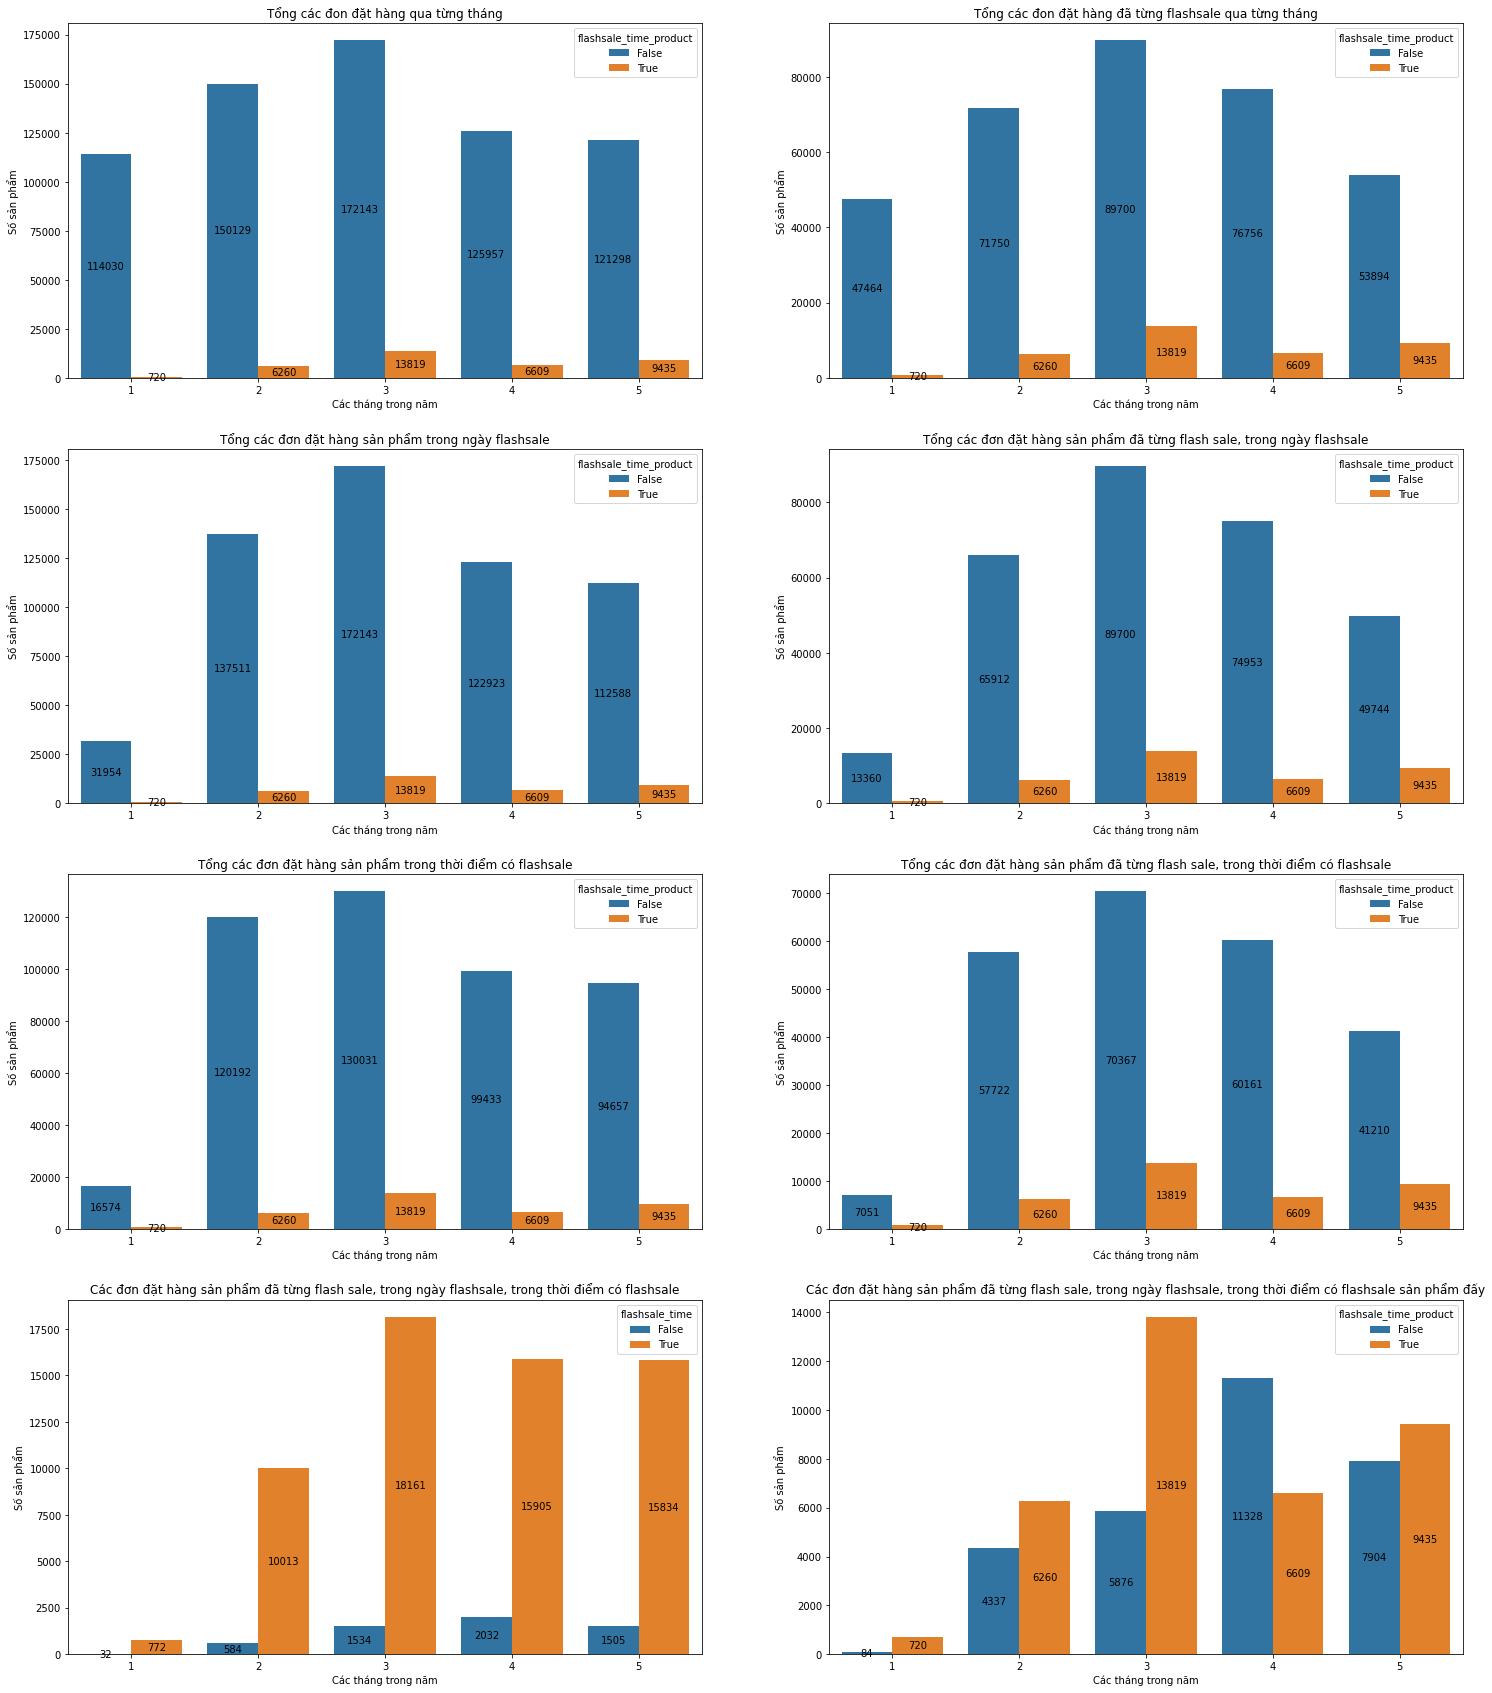

In [37]:
fig, ax = plt.subplots(4, 2, figsize=(25,30))

# Show ra khác biệt về ngày
sns.barplot(data = fhs_sales_flat_order_item_state_2022, 
          x = fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.month,
          y = fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[0,0], palette="tab10", estimator = np.count_nonzero)

for container in ax[0,0].containers:
    ax[0,0].bar_label(container, label_type='center')
ax[0,0].set_title('Tổng các đon đặt hàng qua từng tháng')
ax[0,0].set_xlabel('Các tháng trong năm')
ax[0,0].set_ylabel('Số sản phẩm')

# df chứa đơn hàng củ loại hàng đã từng flashsale
df = fhs_sales_flat_order_item_state_2022\
        .loc[(fhs_sales_flat_order_item_state_2022['flashsale_product'] ==  True)]

sns.barplot(data = df, 
          x = df['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[0,1], palette="tab10", estimator = np.count_nonzero)

for container in ax[0,1].containers:
    ax[0,1].bar_label(container, label_type='center')
ax[0,1].set_title('Tổng các đon đặt hàng đã từng flashsale qua từng tháng')
ax[0,1].set_xlabel('Các tháng trong năm')
ax[0,1].set_ylabel('Số sản phẩm')

# df1 chứa đơn hàng được bán vào ngày flashsale
df1 = fhs_sales_flat_order_item_state_2022\
        .loc[(fhs_sales_flat_order_item_state_2022['flashsale_day'] ==  True)]

sns.barplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[1,0], palette="tab10", estimator = np.count_nonzero)

for container in ax[1,0].containers:
    ax[1,0].bar_label(container, label_type='center')
ax[1,0].set_title('Tổng các đơn đặt hàng sản phẩm trong ngày flashsale')
ax[1,0].set_xlabel('Các tháng trong năm')
ax[1,0].set_ylabel('Số sản phẩm')

# df2 chứa đơn hàng từng được flashsale được bán vào ngày flashsale
df2 = fhs_sales_flat_order_item_state_2022\
        .loc[(fhs_sales_flat_order_item_state_2022['flashsale_product'] ==  True)
        &    (fhs_sales_flat_order_item_state_2022['flashsale_day'] ==  True)]

sns.barplot(data = df2, 
          x = df2['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df2['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[1,1], palette="tab10", estimator = np.count_nonzero)

for container in ax[1,1].containers:
    ax[1,1].bar_label(container, label_type='center')
ax[1,1].set_title('Tổng các đơn đặt hàng sản phẩm đã từng flash sale, trong ngày flashsale')
ax[1,1].set_xlabel('Các tháng trong năm')
ax[1,1].set_ylabel('Số sản phẩm')

# df3 chứa đơn hàng được bán vào giờ có flashsale 
df3 = fhs_sales_flat_order_item_state_2022\
        .loc[(fhs_sales_flat_order_item_state_2022['flashsale_time'] ==  True)]

sns.barplot(data = df3, 
          x = df3['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df3['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[2,0], palette="tab10", estimator = np.count_nonzero)

for container in ax[2,0].containers:
    ax[2,0].bar_label(container, label_type='center')
ax[2,0].set_title('Tổng các đơn đặt hàng sản phẩm trong thời điểm có flashsale')
ax[2,0].set_xlabel('Các tháng trong năm')
ax[2,0].set_ylabel('Số sản phẩm')

# df4 chứa đơn hàng từng được flashsale được bán vào thời điểm flashsale_time
df4= fhs_sales_flat_order_item_state_2022\
        .loc[(fhs_sales_flat_order_item_state_2022['flashsale_product'] ==  True)
        &    (fhs_sales_flat_order_item_state_2022['flashsale_time'] ==  True)]

sns.barplot(data = df4, 
          x = df4['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df4['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[2,1], palette="tab10", estimator = np.count_nonzero)

for container in ax[2,1].containers:
    ax[2,1].bar_label(container, label_type='center')
ax[2,1].set_title('Tổng các đơn đặt hàng sản phẩm đã từng flash sale, trong thời điểm có flashsale')
ax[2,1].set_xlabel('Các tháng trong năm')
ax[2,1].set_ylabel('Số sản phẩm')


# df5 chứa đơn hàng từng được flashsale được bán vào thời ngày có flashsale của sản phẩm đấy
df5= fhs_sales_flat_order_item_state_2022\
        .loc[(fhs_sales_flat_order_item_state_2022['flashsale_product'] ==  True)
        &    (fhs_sales_flat_order_item_state_2022['flashsale_day_product'] ==  True)
        ]

sns.barplot(data = df5, 
          x = df5['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df5['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time', ax = ax[3,0], palette="tab10", estimator = np.count_nonzero)

for container in ax[3,0].containers:
    ax[3,0].bar_label(container, label_type='center')
ax[3,0].set_title('Các đơn đặt hàng sản phẩm đã từng flash sale, trong ngày flashsale, trong thời điểm có flashsale')
ax[3,0].set_xlabel('Các tháng trong năm')
ax[3,0].set_ylabel('Số sản phẩm')

# df6 chứa đơn hàng từng được flashsale được bán vào thời ngày có flashsale của sản phẩm đấy 
df5= fhs_sales_flat_order_item_state_2022\
        .loc[(fhs_sales_flat_order_item_state_2022['flashsale_product'] ==  True)
        &    (fhs_sales_flat_order_item_state_2022['flashsale_day_product'] ==  True)
        ]

sns.barplot(data = df5, 
          x = df5['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df5['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[3,1], palette="tab10", estimator = np.count_nonzero)

for container in ax[3,1].containers:
    ax[3,1].bar_label(container, label_type='center')
ax[3,1].set_title('Các đơn đặt hàng sản phẩm đã từng flash sale, trong ngày flashsale, trong thời điểm có flashsale sản phẩm đấy')
ax[3,1].set_xlabel('Các tháng trong năm')
ax[3,1].set_ylabel('Số sản phẩm')

- So sánh giữa lượng mua hàng của loại hàng flashsale trong ngày flashsale và trong thời gian flashsale

In [38]:
def show_mean_count_product_month_dayofweek(df, hue, ax1, ax2):
          # Show ra khác biệt về ngày
          df1 = df.loc[df['flashsale_product'] == True]
          df1 = df1.groupby([df1['fhs_sales_flat_order_item.created_at'].dt.date, hue])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at')

          sns.boxplot(data = df1, 
                    x = df1['fhs_sales_flat_order_item.created_at'].dt.month,
                    y = df1['fhs_sales_flat_order.entity_id'],
                    hue = hue, ax = ax1, palette="tab10")
          ax1.set_ylabel('Số lượng')
          ax1.set_title('So sánh lượng mua hàng của loại hàng flashsale trong ngày')
          ax1.set_xlabel('Các tháng trong năm 2021')

          sns.boxplot(data = df1, 
                    x = df1['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
                    y = df1['fhs_sales_flat_order.entity_id'],
                    hue = hue, ax = ax2, palette="tab10")
          ax2.set_ylabel('Số lượng')
          ax2.set_title('So sánh lượng mua hàng của loại hàng flashsale trong ngày')
          ax2.set_xlabel('Các thứ trong tuần')

def show_mean_count_product_per_sku_month_dayofweek(df, hue, ax1, ax2):
          temp = df.groupby(['fhs_sales_flat_order_item.sku',
                    df['fhs_sales_flat_order_item.created_at'].dt.date, hue])['fhs_sales_flat_order.entity_id'].sum()
          temp = temp.reset_index()
          string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at')
          sns.barplot(data = temp, 
                    x = temp['fhs_sales_flat_order_item.created_at'].dt.month,
                    y = temp['fhs_sales_flat_order.entity_id'],
                    hue = hue, ax = ax1,palette = "tab10", estimator = np.mean)
          ax1.set_xlabel('Các tháng trong năm')
          ax1.set_ylabel('Số lượng')
          ax1.set_title('Lượng mua hàng trên 1 sản phẩm của hàng flashsale trong ngày')

          sns.barplot(data = temp, 
                    x = temp['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
                    y = temp['fhs_sales_flat_order.entity_id'],
                    hue = hue, ax = ax2,palette = "tab10", estimator = np.mean)
          ax2.set_xlabel('Các thứ trong tuần')
          ax2.set_ylabel('Số lượng')
          ax2.set_title('Lượng mua hàng trên 1 sản phẩm của hàng flashsale trong ngày')                  

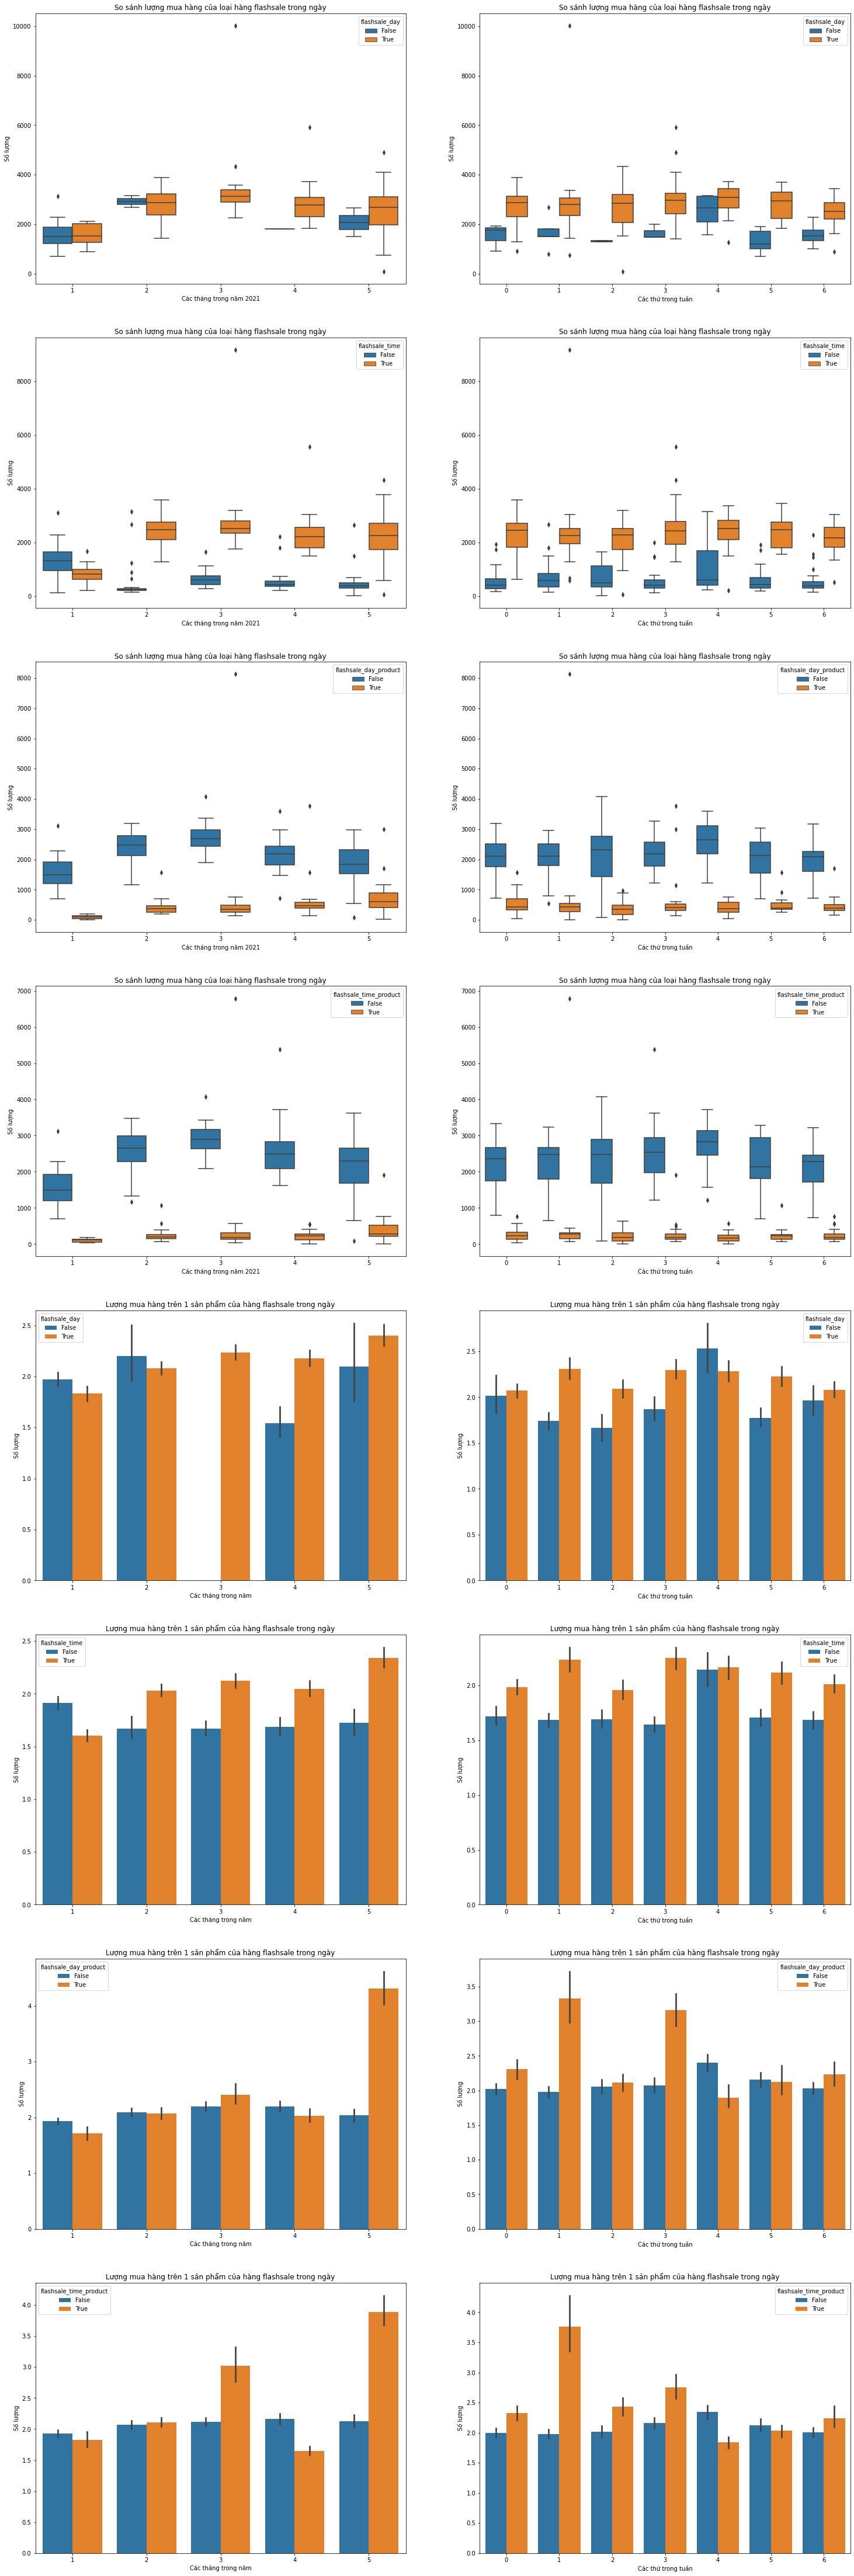

In [39]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

fig, ax = plt.subplots(8, 2, figsize=(25,80))

# Show ra khác biệt về ngày
show_mean_count_product_month_dayofweek(df, 'flashsale_day', ax[0,0], ax[0, 1])
show_mean_count_product_month_dayofweek(df, 'flashsale_time', ax[1,0], ax[1, 1])
show_mean_count_product_month_dayofweek(df, 'flashsale_day_product', ax[2,0], ax[2, 1])
show_mean_count_product_month_dayofweek(df, 'flashsale_time_product', ax[3,0], ax[3, 1])



# show ra trung bình đơn trên một sản phẩm theo từng ngày, tháng, ngày, giờ
df = fhs_sales_flat_order_item_state_2022.groupby(['fhs_sales_flat_order_item.sku',
                    fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
df  = df.loc[df['flashsale_product'] == True]

show_mean_count_product_per_sku_month_dayofweek(df, 'flashsale_day', ax[4,0], ax[4,1])
show_mean_count_product_per_sku_month_dayofweek(df, 'flashsale_time', ax[5,0], ax[5,1])
show_mean_count_product_per_sku_month_dayofweek(df, 'flashsale_day_product', ax[6,0], ax[6,1])
show_mean_count_product_per_sku_month_dayofweek(df, 'flashsale_time_product', ax[7,0], ax[7,1])

- Show ra các ngày trong tháng

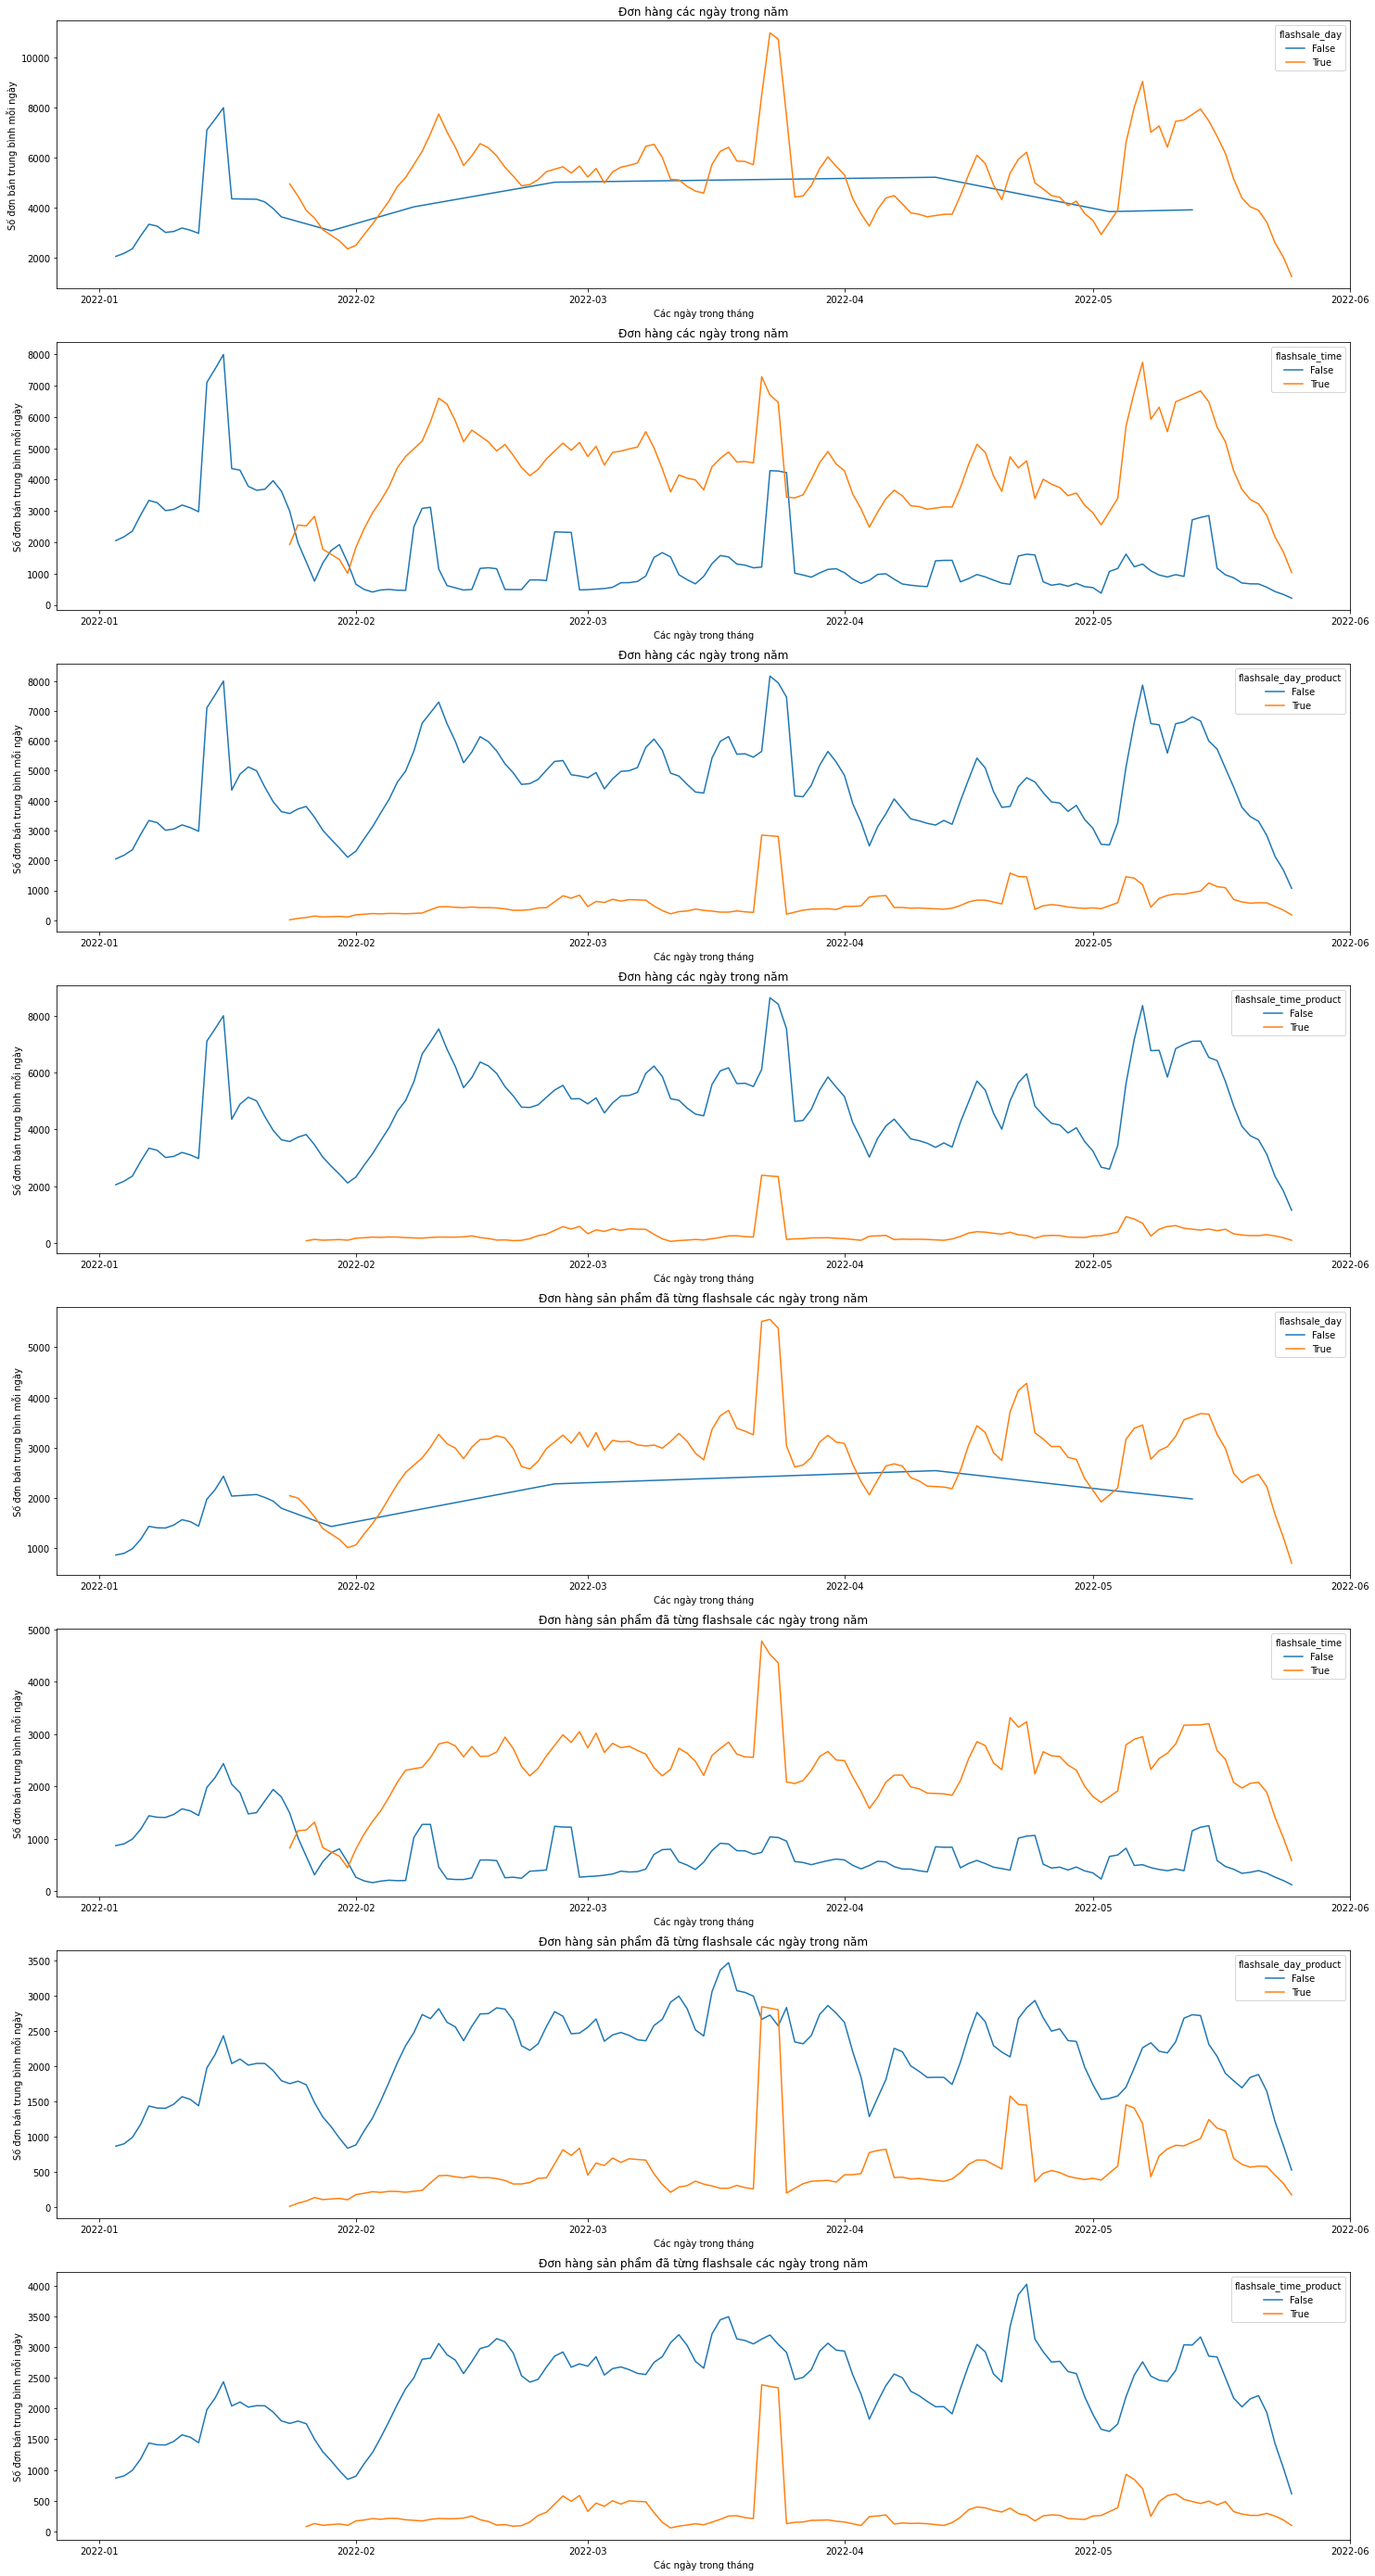

In [54]:
def show_line_count_all_product_2022(df, hue, ax1):
          # Show ra khác biệt về ngày
          # df1 = df.loc[df['flashsale_product'] == True]
          df1 = df
          df1 = df1.groupby([df1['fhs_sales_flat_order_item.created_at'].dt.date, hue])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at')

          # ----------------------------------------------- #
          temp = df1
          temp = temp.sort_values('fhs_sales_flat_order_item.created_at')
          # temp = temp.sort_values(hue)
          temp.loc[temp[hue] == True,'fhs_sales_flat_order.entity_id'] \
                              = temp.loc[temp[hue] == True]['fhs_sales_flat_order.entity_id'].rolling(3).mean()
                              
          temp.loc[temp[hue] == False,'fhs_sales_flat_order.entity_id'] \
                              = temp.loc[temp[hue] == False]['fhs_sales_flat_order.entity_id'].rolling(3).mean()
          # temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
          sns.lineplot(data = temp, x = temp['fhs_sales_flat_order_item.created_at'].dt.date, y = 'fhs_sales_flat_order.entity_id',
                             hue = hue, ax = ax1)
          ax1.set_title(f'Đơn hàng các ngày trong năm')
          ax1.set_xlabel('Các ngày trong tháng')
          ax1.set_ylabel('Số đơn bán trung bình mỗi ngày')

def show_line_count_flashsale_product_2022(df, hue, ax1):
          # Show ra khác biệt về ngày
          df1 = df.loc[df['flashsale_product'] == True]
          df1 = df1.groupby([df1['fhs_sales_flat_order_item.created_at'].dt.date, hue])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at')
          df1 = df1.fillna(0)
          # ----------------------------------------------- #
          temp = df1
          temp = temp.sort_values('fhs_sales_flat_order_item.created_at')
          # temp = temp.sort_values(hue)
          temp.loc[temp[hue] == True,'fhs_sales_flat_order.entity_id'] \
                              = temp.loc[temp[hue] == True]['fhs_sales_flat_order.entity_id'].rolling(3).mean()
                              
          temp.loc[temp[hue] == False,'fhs_sales_flat_order.entity_id'] \
                              = temp.loc[temp[hue] == False]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

          # temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
          sns.lineplot(data = temp, x = temp['fhs_sales_flat_order_item.created_at'].dt.date, y = 'fhs_sales_flat_order.entity_id',
                             hue = hue, ax = ax1)
          ax1.set_title(f'Đơn hàng sản phẩm đã từng flashsale các ngày trong năm')
          ax1.set_xlabel('Các ngày trong tháng')
          ax1.set_ylabel('Số đơn bán trung bình mỗi ngày')


df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

fig, ax = plt.subplots(8,1, figsize = (25, 50))
show_line_count_all_product_2022(df, 'flashsale_day', ax[0])
show_line_count_all_product_2022(df, 'flashsale_time', ax[1])
show_line_count_all_product_2022(df, 'flashsale_day_product', ax[2])
show_line_count_all_product_2022(df, 'flashsale_time_product', ax[3])

show_line_count_flashsale_product_2022(df, 'flashsale_day', ax[4])
show_line_count_flashsale_product_2022(df, 'flashsale_time', ax[5])
show_line_count_flashsale_product_2022(df, 'flashsale_day_product', ax[6])
show_line_count_flashsale_product_2022(df, 'flashsale_time_product', ax[7])

In [73]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
# Show ra khác biệt về ngày
df1 = df.loc[df['flashsale_product'] == True]
df1 = df1.groupby([df1['fhs_sales_flat_order_item.created_at'].dt.date, 'flashsale_day'])['fhs_sales_flat_order.entity_id'].sum()
df1 = df1.reset_index()
string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at')

# ----------------------------------------------- #
temp = df1.loc[df1['flashsale_day'] == False]
temp = temp.sort_values('fhs_sales_flat_order_item.created_at')
temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
list(set(temp['fhs_sales_flat_order_item.created_at'].dt.week))
temp.loc[temp['fhs_sales_flat_order_item.created_at'].dt.week == 52]

/tmp/ipykernel_64275/3251025144.py:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  list(set(temp['fhs_sales_flat_order_item.created_at'].dt.week))
/tmp/ipykernel_64275/3251025144.py:22: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  temp.loc[temp['fhs_sales_flat_order_item.created_at'].dt.week == 52]


fhs_sales_flat_order_item.created_at  flashsale_day  \
0                           2022-01-01          False   
1                           2022-01-02          False   

   fhs_sales_flat_order.entity_id  
0                             NaN  
1                             NaN

In [55]:
def show_line_count_product(df, hue, ax1, ax2):
          # Show ra khác biệt về ngày
          df1 = df.loc[df['flashsale_product'] == True]
          df1 = df1.groupby([df1['fhs_sales_flat_order_item.created_at'].dt.date, hue])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at')

          # ----------------------------------------------- #
          temp = df1.loc[df1[hue] == False]
          temp = temp.sort_values('fhs_sales_flat_order_item.created_at')
          temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
          sns.lineplot(data = temp, x = temp['fhs_sales_flat_order_item.created_at'].dt.day, y = 'fhs_sales_flat_order.entity_id',
                    hue = temp['fhs_sales_flat_order_item.created_at'].dt.month, ax = ax1)
          ax1.set_title(f'Đơn hàng các ngày trong tháng {hue} == Flase')
          ax1.set_xlabel('Các ngày trong tháng')
          ax1.set_ylabel('Số đơn bán trung bình mỗi ngày')
          ax1.legend(title = 'Các tháng trong năm')
          
          # ----------------------------------------------- #
          temp = df1.loc[df1[hue] == True]
          temp = temp.sort_values('fhs_sales_flat_order_item.created_at')
          temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
          sns.lineplot(data = temp, x = temp['fhs_sales_flat_order_item.created_at'].dt.day, y = 'fhs_sales_flat_order.entity_id',
                    hue = temp['fhs_sales_flat_order_item.created_at'].dt.month, ax = ax2)
          ax2.set_title(f'Đơn hàng các ngày trong tháng {hue} == True')
          ax2.set_xlabel('Các ngày trong tháng')
          ax2.set_ylabel('Số đơn bán trung bình mỗi ngày')
          ax2.legend(title = 'Các tháng trong năm')
          pass

def show_line_count_product_week(df, hue, ax1, ax2):
          # Show ra khác biệt về ngày
          df1 = df.loc[df['flashsale_product'] == True]
          df1 = df1.groupby([df1['fhs_sales_flat_order_item.created_at'].dt.date, hue])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at')

          # ----------------------------------------------- #
          temp = df1.loc[df1[hue] == False]
          temp = temp.sort_values('fhs_sales_flat_order_item.created_at')
          temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
          sns.lineplot(data = temp, x = temp['fhs_sales_flat_order_item.created_at'].dt.dayofweek, y = 'fhs_sales_flat_order.entity_id',
                    hue = temp['fhs_sales_flat_order_item.created_at'].dt.week, ax = ax1)
          ax1.set_title(f'Đơn hàng các thứ trong tuần {hue} == Flase')
          ax1.set_xlabel('Các thứ trong tuần')
          ax1.set_ylabel('Số đơn bán trung bình mỗi ngày')
          ax1.legend(title = 'Số tuần trong năm')
          
          # ----------------------------------------------- #
          temp = df1.loc[df1[hue] == True]
          temp = temp.sort_values('fhs_sales_flat_order_item.created_at')
          temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
          sns.lineplot(data = temp, x = temp['fhs_sales_flat_order_item.created_at'].dt.dayofweek, y = 'fhs_sales_flat_order.entity_id',
                    hue = temp['fhs_sales_flat_order_item.created_at'].dt.week, ax = ax2)
          ax2.set_title(f'Đơn hàng các thứ trong tuần {hue} == True')
          ax2.set_xlabel('Các thứ trong tuần')
          ax2.set_ylabel('Số đơn bán trung bình mỗi ngày')
          ax2.legend(title = 'Số tuần trong năm')

          pass

def show_compare_line_count_product(df, hue):
          # Lấy ra các tháng trong năm
          months = list(set(df.groupby(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.month).keys))

          fig, ax = plt.subplots(1, len(months), figsize = (25,8))
          

          # Show ra khác biệt về ngày
          df1 = df.loc[df['flashsale_product'] == True]
          df1 = df1.groupby([df1['fhs_sales_flat_order_item.created_at'].dt.date, hue])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at')

          for i in range(len(months)):
                    # lấy ra bảng gồm các ngày trong tháng i
                    temp = df1.loc[df1['fhs_sales_flat_order_item.created_at'].dt.month == months[i]]
                    temp = temp.sort_values('fhs_sales_flat_order_item.created_at')
                    # temp = temp.sort_values(hue)
                    # running average
                    temp.loc[temp[hue] == True,'fhs_sales_flat_order.entity_id'] \
                              = temp.loc[temp[hue] == True]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

                    temp.loc[temp[hue] == False,'fhs_sales_flat_order.entity_id'] \
                              = temp.loc[temp[hue] == False]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

                    sns.lineplot(data = temp, x = temp['fhs_sales_flat_order_item.created_at'].dt.day, y = 'fhs_sales_flat_order.entity_id',
                              hue = hue, ax = ax[i])
                    ax[i].set_title(f'So sánh tổng đơn bán theo tháng {months[i]}/2022')
                    ax[i].set_xlabel('Các ngày trong tháng')
                    ax[i].set_ylabel('Số đơn bán trung bình mỗi ngày')
          pass

def show_line_count_product_per_sku_dayinmonth(df, hue, ax1, ax2):
          df1 = df.groupby(['fhs_sales_flat_order_item.sku',
                              df['fhs_sales_flat_order_item.created_at'].dt.date, hue])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at')

          # ----------------------------------------------- #
          temp = df1.loc[df1[hue] == False]
          temp = temp.sort_values('fhs_sales_flat_order_item.created_at')

          temp = temp.groupby('fhs_sales_flat_order_item.created_at')['fhs_sales_flat_order.entity_id'].mean()
          temp = temp.reset_index()
          string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at')

          temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
          sns.lineplot(data = temp, x = temp['fhs_sales_flat_order_item.created_at'].dt.day, y = 'fhs_sales_flat_order.entity_id',
                              hue = temp['fhs_sales_flat_order_item.created_at'].dt.month, ax = ax1)
          ax1.set_title(f'Đơn hàng của mỗi sản phẩm trung bình trong ngày {hue} == Flase')
          ax1.set_xlabel('Các ngày trong tháng')
          ax1.set_ylabel('Só đơn trên mỗi sản phẩm trung bình mỗi ngày')
          ax1.legend(title = 'Các tháng trong năm')

          
          # ----------------------------------------------- #
          temp = df1.loc[df1[hue] == True]
          temp = temp.sort_values('fhs_sales_flat_order_item.created_at')

          temp = temp.groupby('fhs_sales_flat_order_item.created_at')['fhs_sales_flat_order.entity_id'].mean()
          temp = temp.reset_index()
          string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at')

          temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
          sns.lineplot(data = temp, x = temp['fhs_sales_flat_order_item.created_at'].dt.day, y = 'fhs_sales_flat_order.entity_id',
                              hue = temp['fhs_sales_flat_order_item.created_at'].dt.month, ax = ax2)
          ax2.set_title(f'Đơn hàng của mỗi sản phẩm trung bình trong ngày {hue} == True')
          ax2.set_xlabel('Các ngày trong tháng')
          ax2.set_ylabel('Số đơn trên mỗi sản phẩm trung bình mỗi ngày')
          ax2.legend(title = 'Các tháng trong năm')
          
          pass

def show_line_count_product_per_sku_week(df, hue, ax1, ax2):
          df1 = df.groupby(['fhs_sales_flat_order_item.sku',
                              df['fhs_sales_flat_order_item.created_at'].dt.date, hue])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at')

          # ----------------------------------------------- #
          temp = df1.loc[df1[hue] == False]
          temp = temp.sort_values('fhs_sales_flat_order_item.created_at')

          temp = temp.groupby('fhs_sales_flat_order_item.created_at')['fhs_sales_flat_order.entity_id'].mean()
          temp = temp.reset_index()
          string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at')
          sns.lineplot(data = temp, x = temp['fhs_sales_flat_order_item.created_at'].dt.dayofweek, y = 'fhs_sales_flat_order.entity_id',
                    hue = temp['fhs_sales_flat_order_item.created_at'].dt.week, ax = ax1)
          ax1.set_title(f'Đơn hàng các thứ trong tuần {hue} == Flase')
          ax1.set_xlabel('Các thứ trong tuần')
          ax1.set_ylabel('Số đơn trên mỗi sản phẩm trung bình mỗi ngày')
          ax1.legend(title = 'Số tuần trong năm')
          
          # ----------------------------------------------- #
          temp = df1.loc[df1[hue] == True]
          temp = temp.sort_values('fhs_sales_flat_order_item.created_at')

          temp = temp.groupby('fhs_sales_flat_order_item.created_at')['fhs_sales_flat_order.entity_id'].mean()
          temp = temp.reset_index()
          string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at')
          sns.lineplot(data = temp, x = temp['fhs_sales_flat_order_item.created_at'].dt.dayofweek, y = 'fhs_sales_flat_order.entity_id',
                    hue = temp['fhs_sales_flat_order_item.created_at'].dt.week, ax = ax2)
          ax2.set_title(f'Đơn hàng các thứ trong tuần {hue} == True')
          ax2.set_xlabel('Các thứ trong tuần')
          ax2.set_ylabel('Số đơn trên mỗi sản phẩm trung bình mỗi ngày')
          ax2.legend(title = 'Số tuần trong năm')
          pass

def show_compare_line_count_product_per_sku_dayinmonth(df, hue):
          # Lấy ra các tháng trong năm
          months = list(set(df.groupby(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.month).keys))

          fig, ax = plt.subplots(1, len(months), figsize = (25,8))
          

          df1 = df.groupby(['fhs_sales_flat_order_item.sku',
                              df['fhs_sales_flat_order_item.created_at'].dt.date, hue])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at')

          # ----------------------------------------------- #
          for i in range(len(months)):
                    temp = df1.loc[df1['fhs_sales_flat_order_item.created_at'].dt.month == months[i]]
                    temp = temp.sort_values('fhs_sales_flat_order_item.created_at')

                    temp = temp.groupby(['fhs_sales_flat_order_item.created_at', hue])['fhs_sales_flat_order.entity_id'].mean()
                    temp = temp.reset_index()
                    string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at')
                    
                    temp = temp.sort_values('fhs_sales_flat_order_item.created_at')
                    # temp = temp.sort_values(hue)

                    temp.loc[temp[hue] == True,'fhs_sales_flat_order.entity_id'] \
                              = temp.loc[temp[hue] == True]['fhs_sales_flat_order.entity_id'].rolling(3).mean()
                              
                    temp.loc[temp[hue] == False,'fhs_sales_flat_order.entity_id'] \
                              = temp.loc[temp[hue] == False]['fhs_sales_flat_order.entity_id'].rolling(3).mean()
                    # temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()

                    sns.lineplot(data = temp, x = temp['fhs_sales_flat_order_item.created_at'].dt.day, y = 'fhs_sales_flat_order.entity_id',
                              hue = hue, ax = ax[i])
                    ax[i].set_title(f'Tổng đơn trên mỗi sản phẩm {months[i]}/2022')
                    ax[i].set_xlabel('Các ngày trong tháng')
                    ax[i].set_ylabel('Só đơn trên mỗi sản phẩm trung bình mỗi ngày')
                    # ax[i].legend(title = 'Các tháng trong năm')

          pass


/tmp/ipykernel_64275/3159290192.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.week != 52]
/tmp/ipykernel_64275/2387866749.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  hue = temp['fhs_sales_flat_order_item.created_at'].dt.week, ax = ax1)
/tmp/ipykernel_64275/2387866749.py:54: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  hue = temp['fhs_sales_flat_order_item.created_at'].dt.week, ax = ax2)
/tmp/ipykernel_64275/2387866749.py:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  hue = temp['fhs_sales_flat_order_item.created_at'].dt.week, ax = ax1)
/tmp/ipykernel_64275/2387866749.py:54: FutureWarning

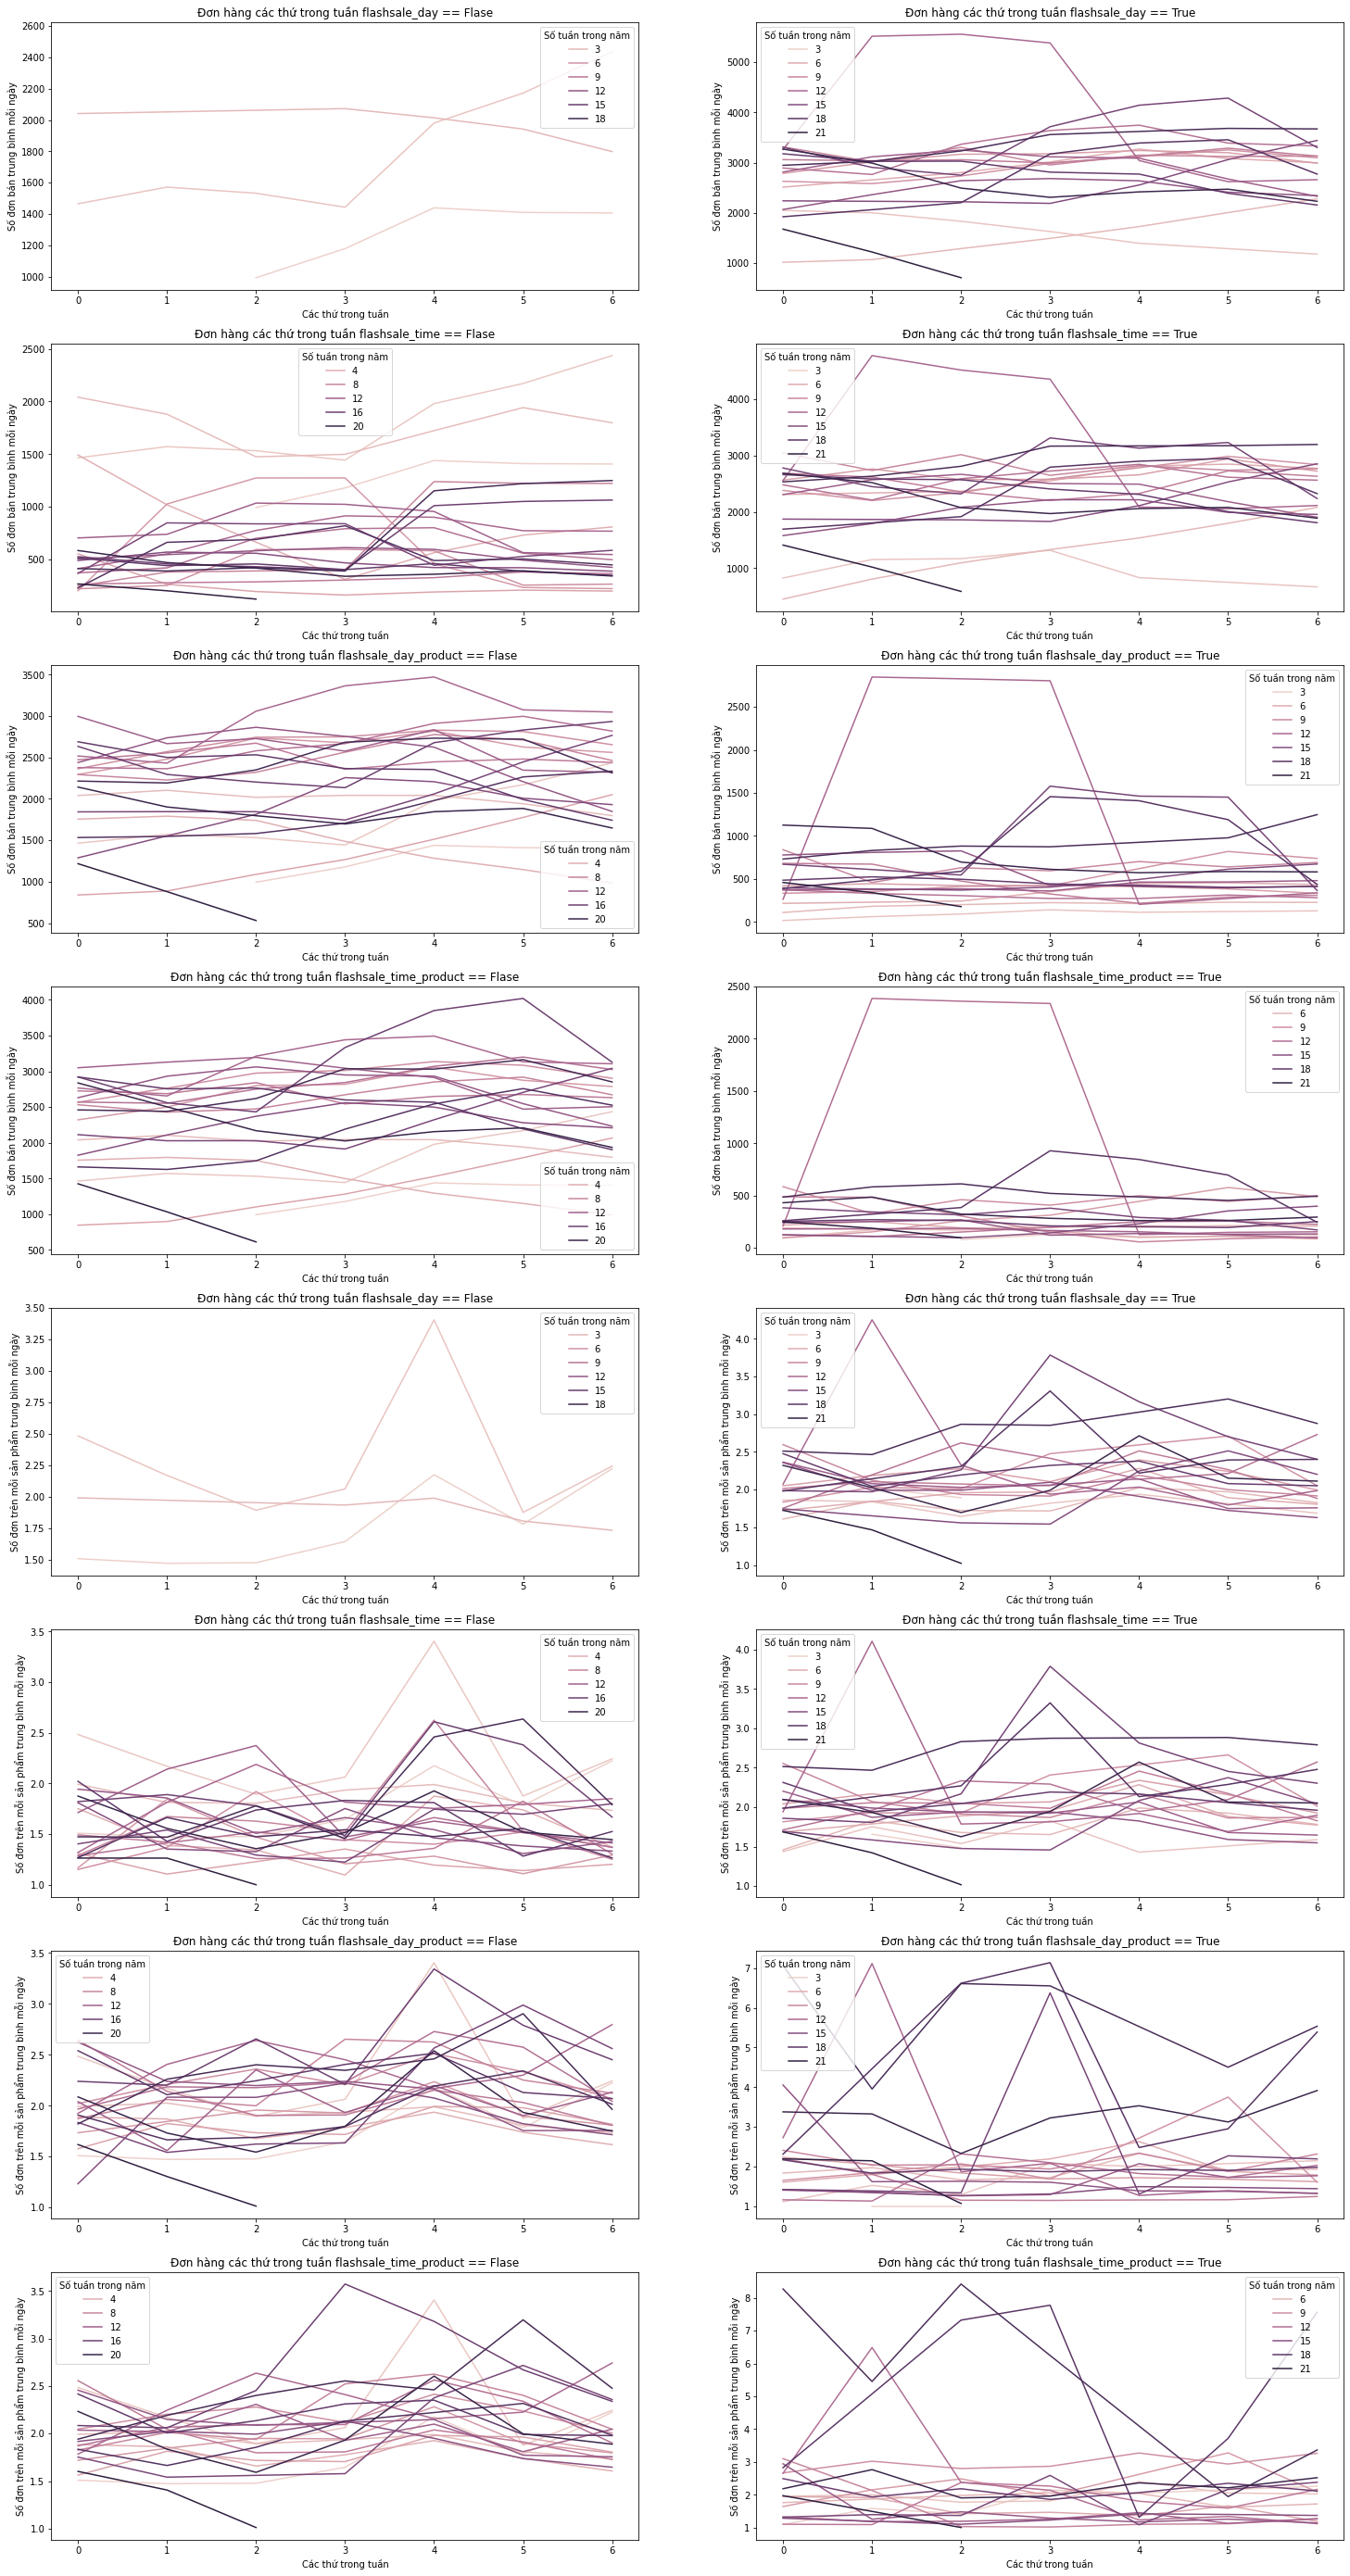

In [79]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

# cẩn thận với các ngày đầu năm có tuần là 52
df = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.week != 52]

fig, ax = plt.subplots(8, 2, figsize=(25,50))

show_line_count_product_week(df, 'flashsale_day', ax[0,0], ax[0,1])
show_line_count_product_week(df, 'flashsale_time', ax[1,0], ax[1,1])
show_line_count_product_week(df, 'flashsale_day_product', ax[2,0], ax[2,1])
show_line_count_product_week(df, 'flashsale_time_product', ax[3,0], ax[3,1])

# ---------------------------------------------------------- #
df = fhs_sales_flat_order_item_state_2022.groupby(['fhs_sales_flat_order_item.sku',
                    fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
# cẩn thận với các ngày đầu năm có tuần là 52
df = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.week != 52]

df  = df.loc[df['flashsale_product'] == True]

show_line_count_product_per_sku_week(df, 'flashsale_day', ax[4,0], ax[4,1])
show_line_count_product_per_sku_week(df, 'flashsale_time', ax[5,0], ax[5,1])
show_line_count_product_per_sku_week(df, 'flashsale_day_product', ax[6,0], ax[6,1])
show_line_count_product_per_sku_week(df, 'flashsale_time_product', ax[7,0], ax[7,1])

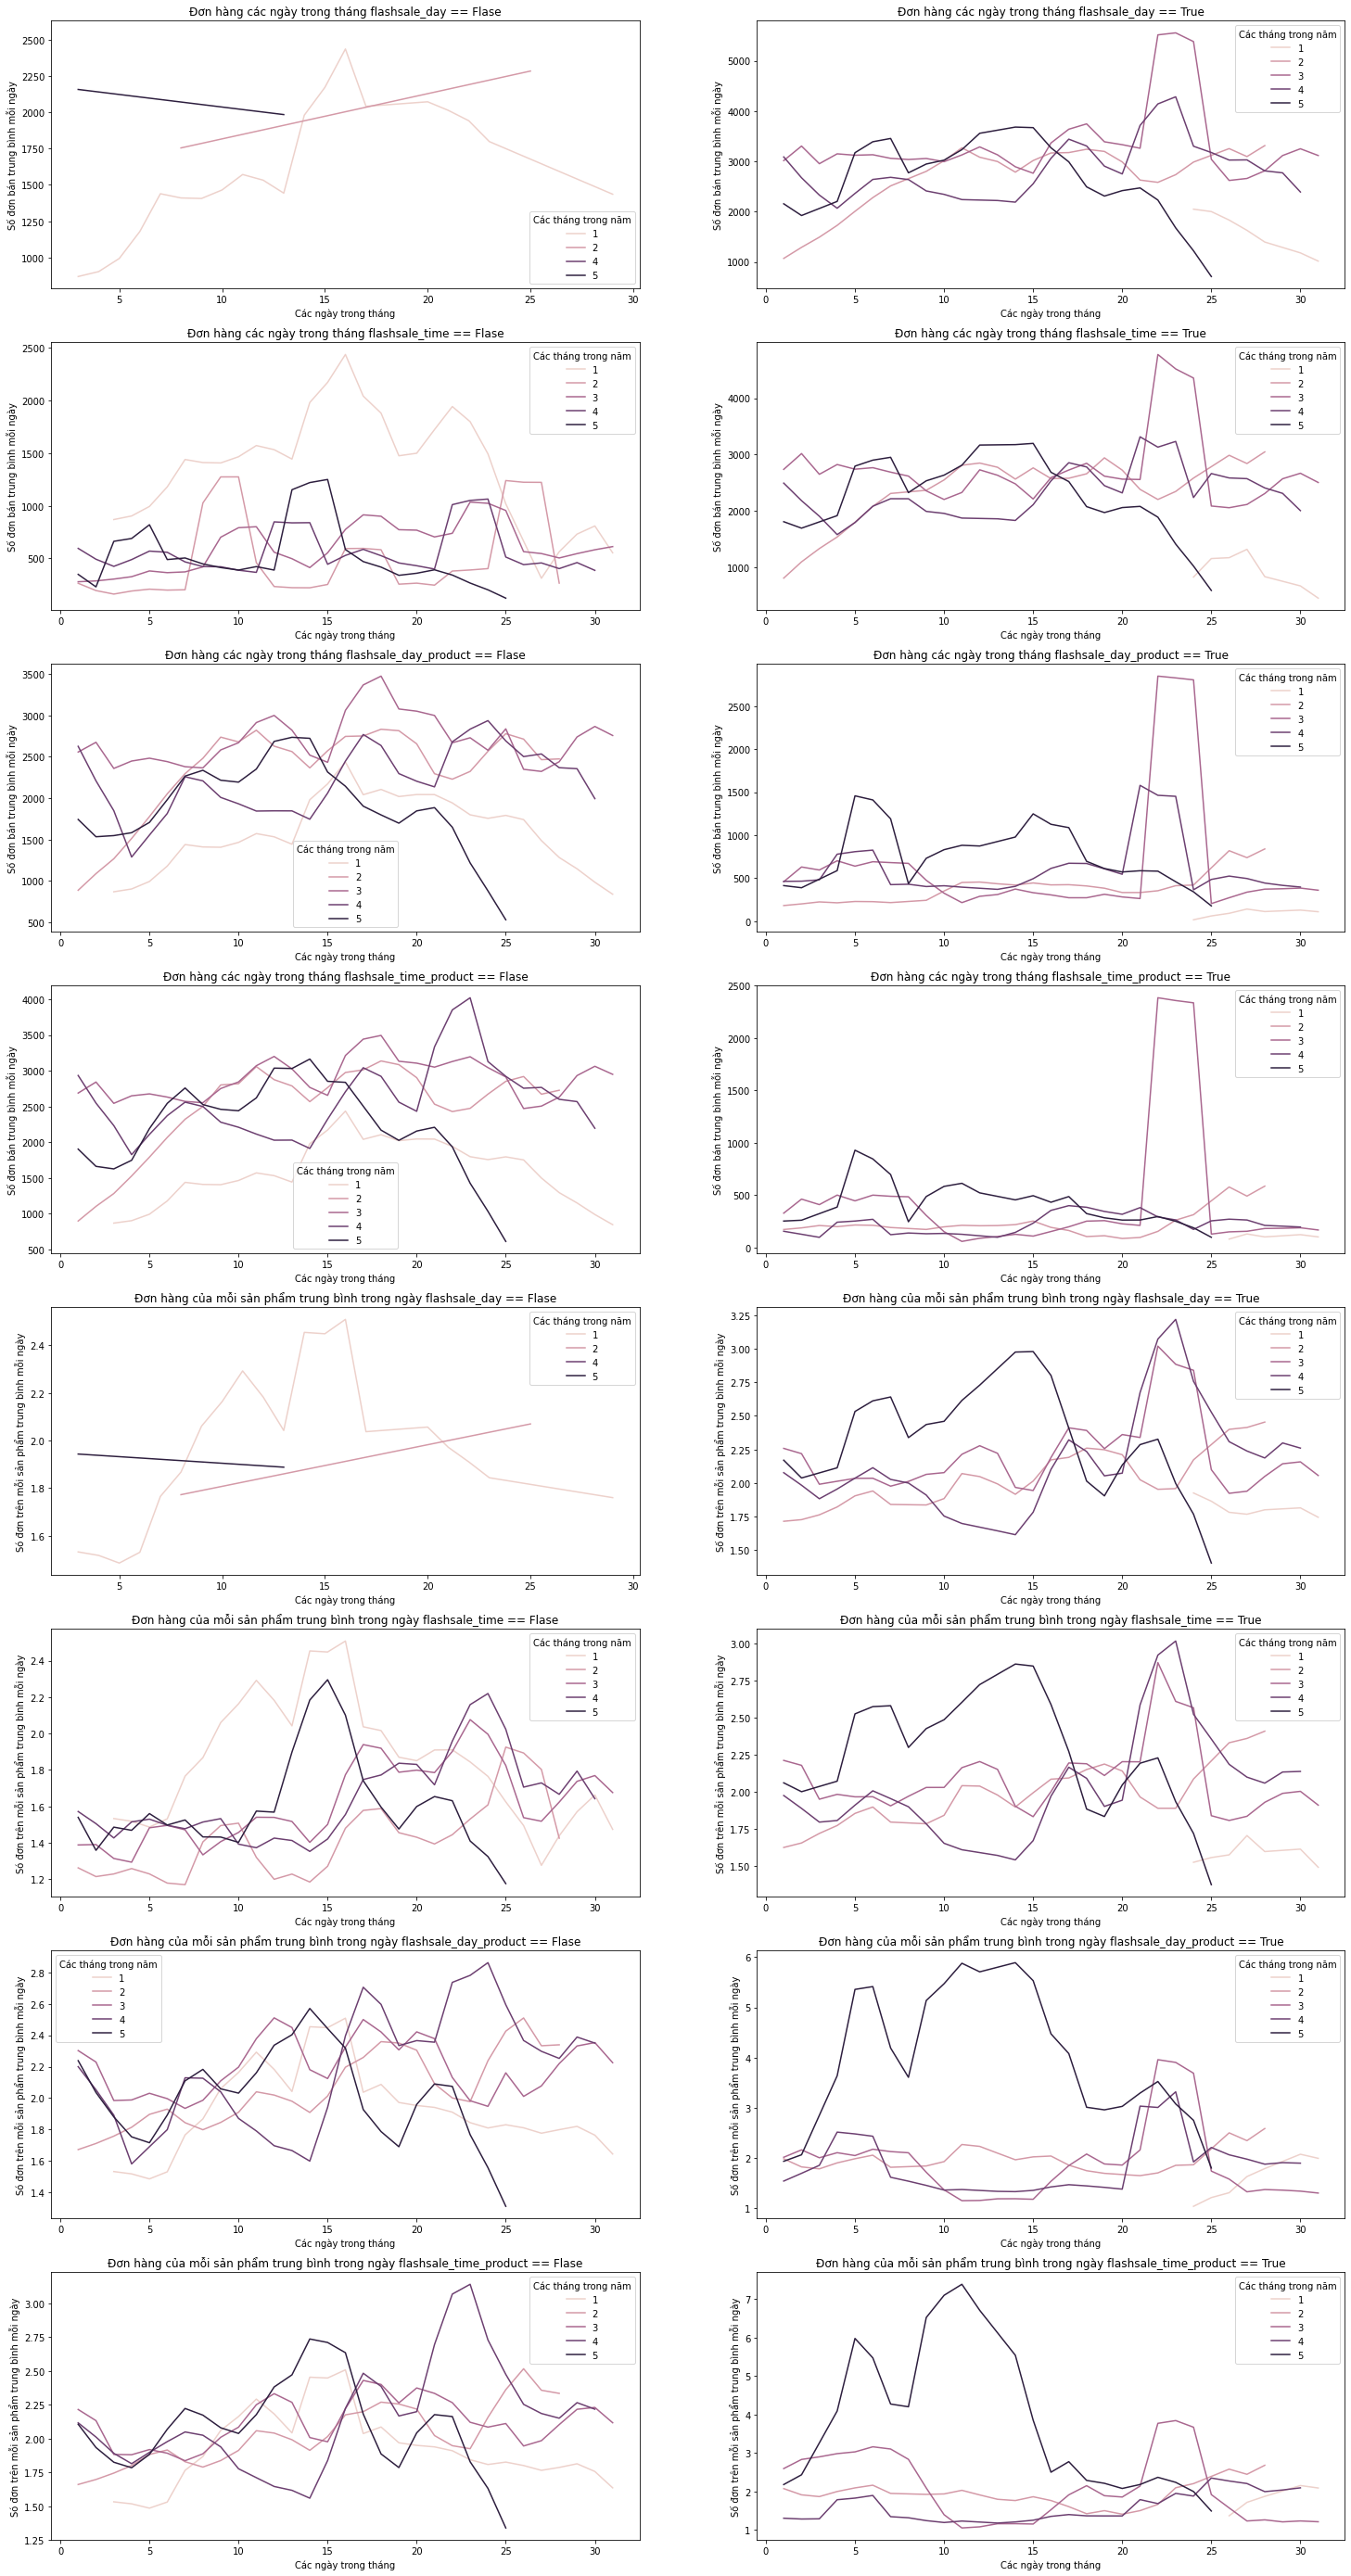

In [86]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

fig, ax = plt.subplots(8, 2, figsize=(25,50))

show_line_count_product(df, 'flashsale_day', ax[0,0], ax[0,1])
show_line_count_product(df, 'flashsale_time', ax[1,0], ax[1,1])
show_line_count_product(df, 'flashsale_day_product', ax[2,0], ax[2,1])
show_line_count_product(df, 'flashsale_time_product', ax[3,0], ax[3,1])

# ---------------------------------------------------------- #
df = fhs_sales_flat_order_item_state_2022.groupby(['fhs_sales_flat_order_item.sku',
                    fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
df  = df.loc[df['flashsale_product'] == True]

show_line_count_product_per_sku_dayinmonth(df, 'flashsale_day', ax[4,0], ax[4,1])
show_line_count_product_per_sku_dayinmonth(df, 'flashsale_time', ax[5,0], ax[5,1])
show_line_count_product_per_sku_dayinmonth(df, 'flashsale_day_product', ax[6,0], ax[6,1])
show_line_count_product_per_sku_dayinmonth(df, 'flashsale_time_product', ax[7,0], ax[7,1])


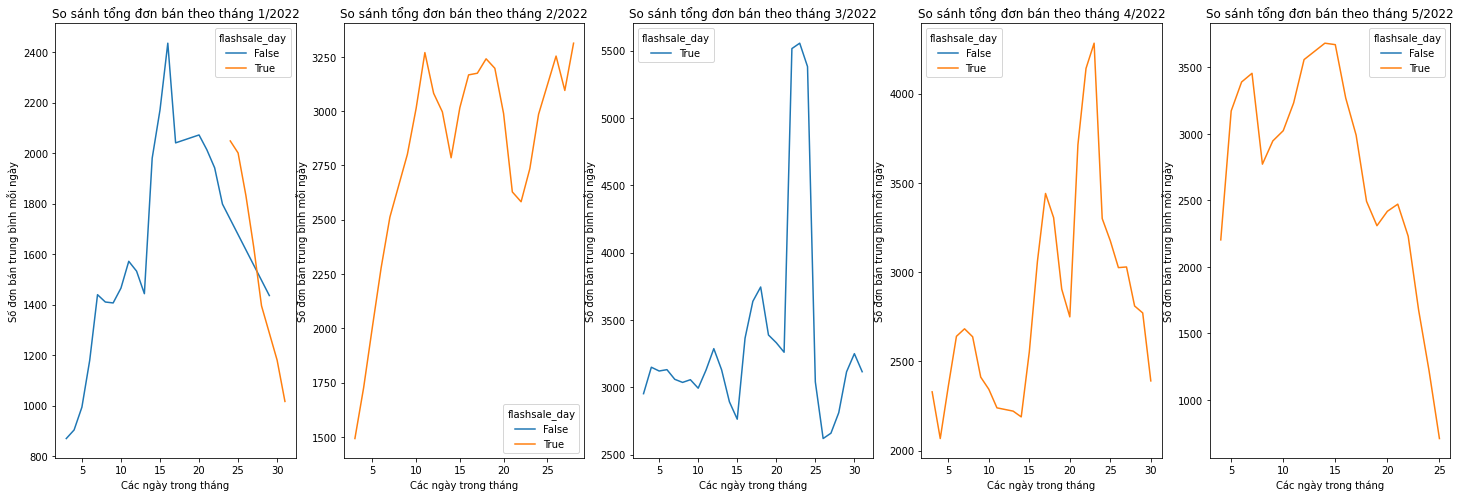

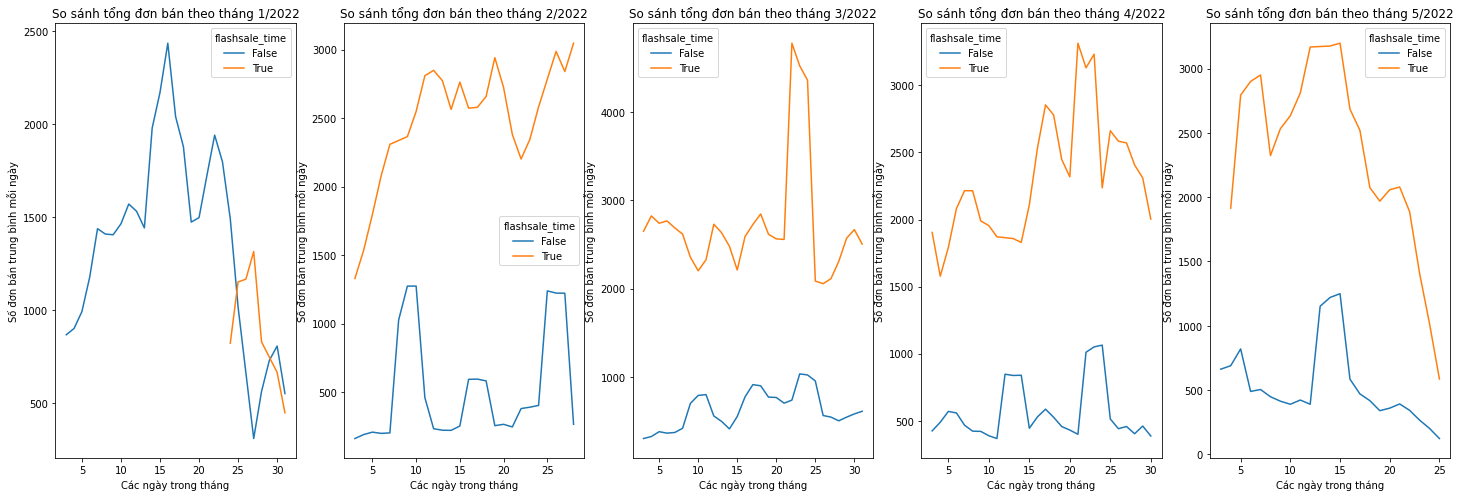

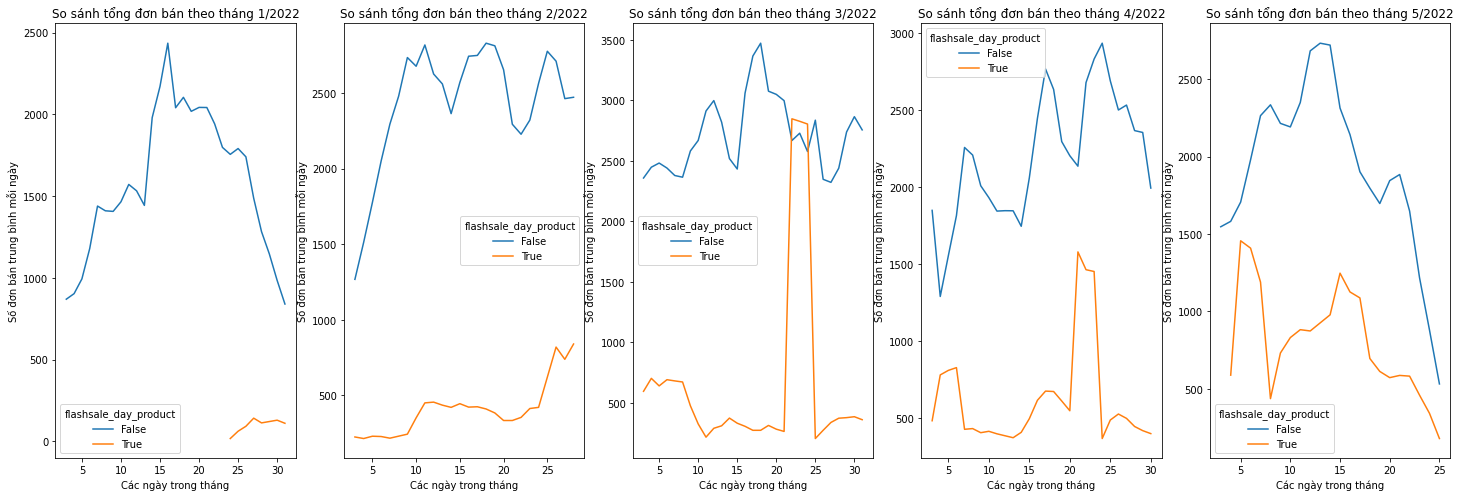

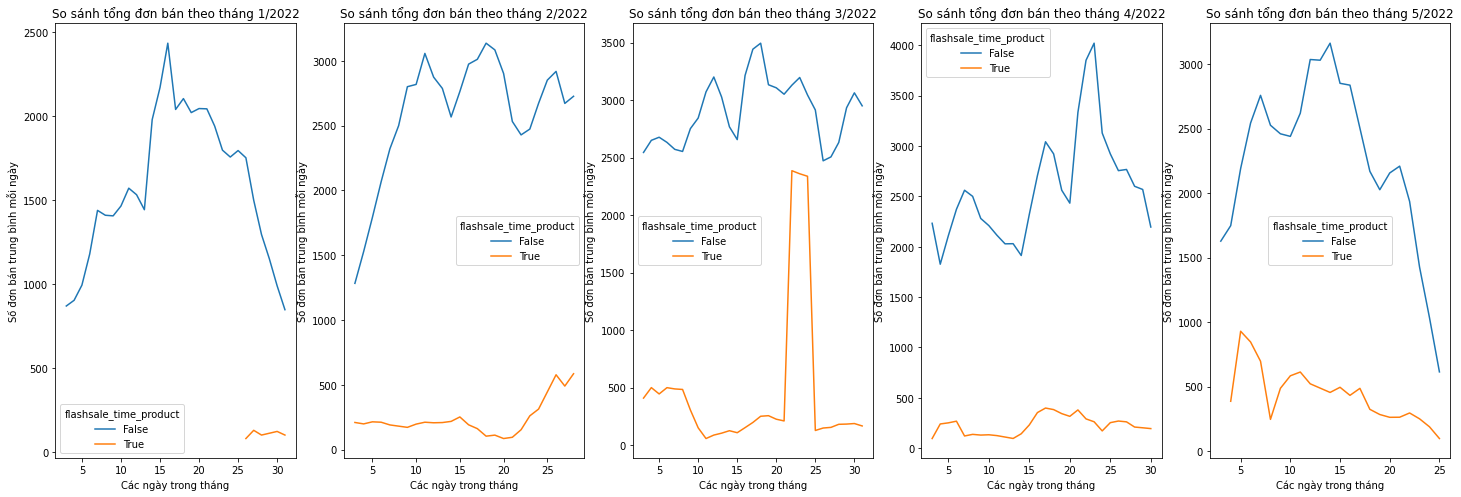

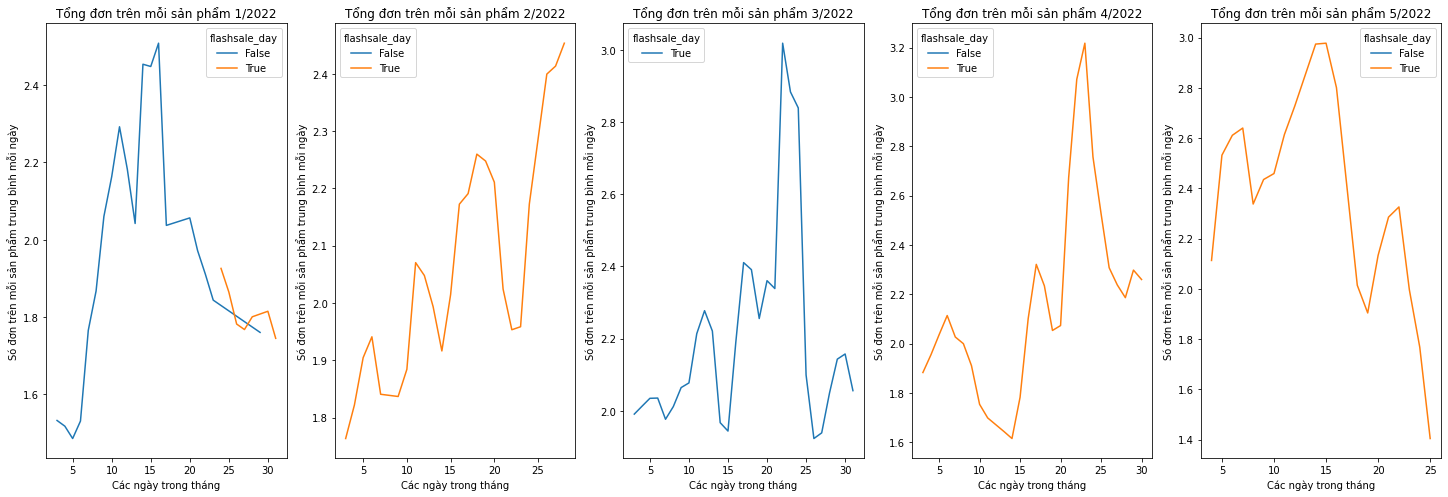

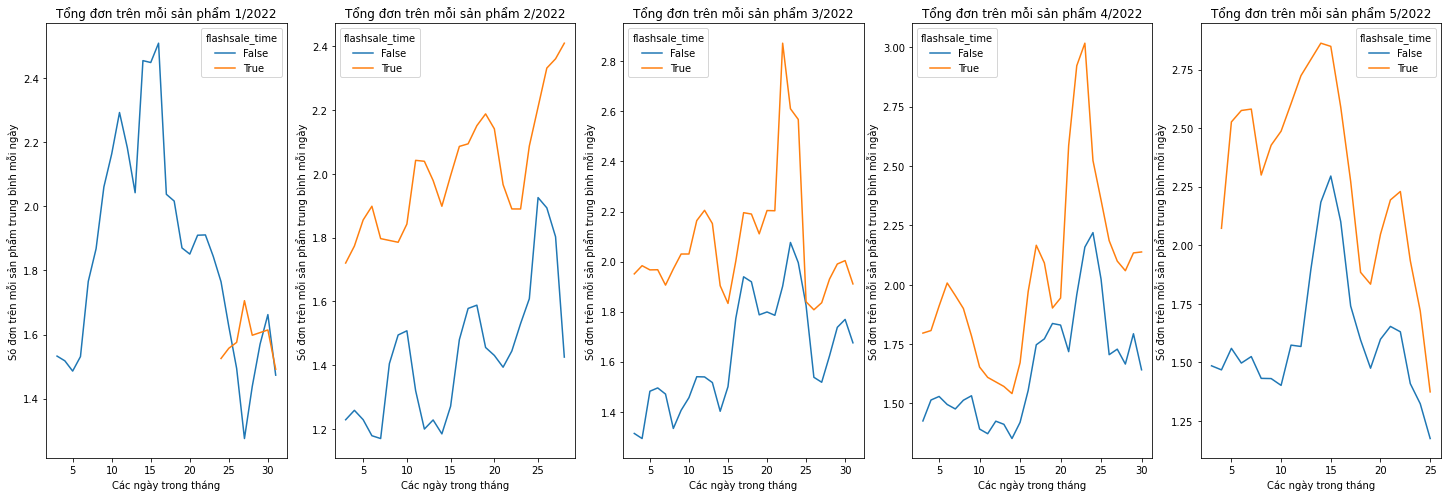

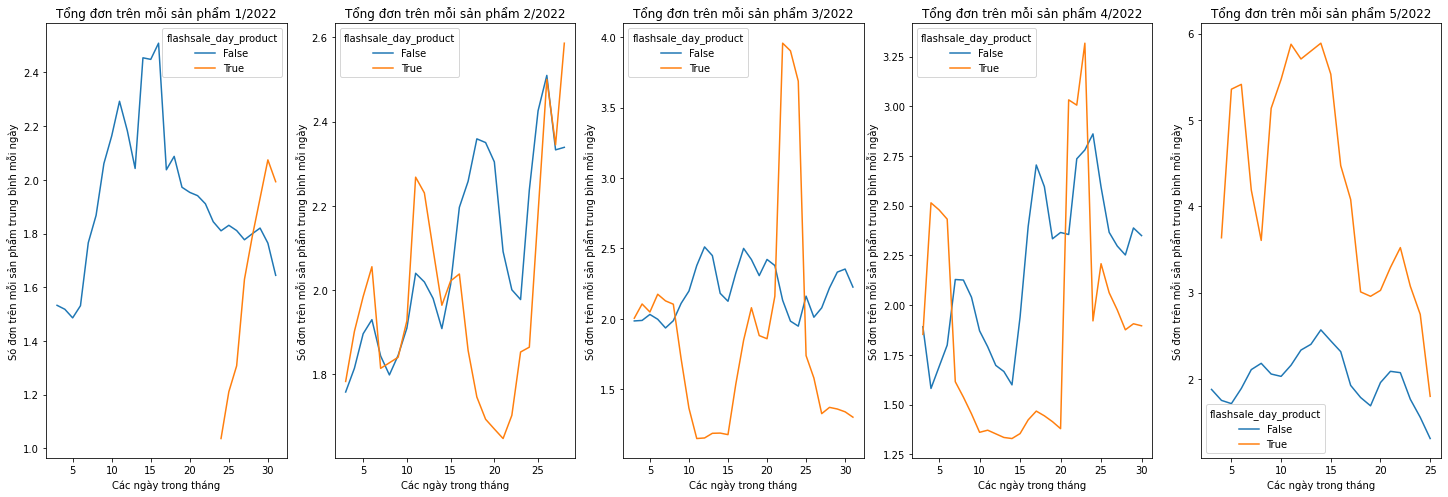

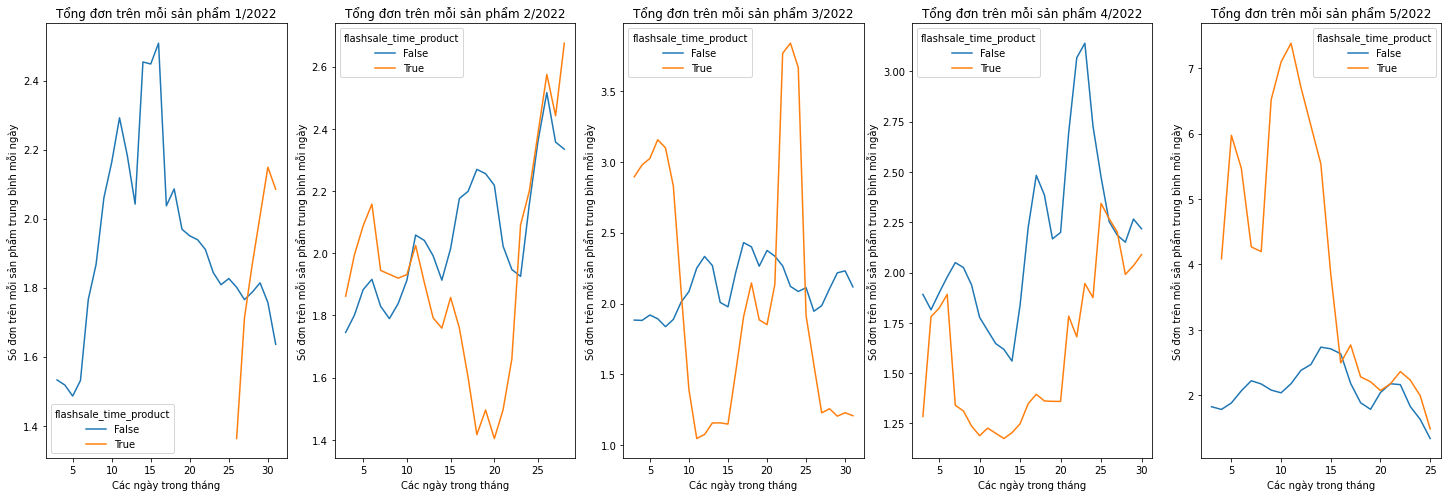

In [56]:
# --------------------------------------------------- #
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
show_compare_line_count_product(df, 'flashsale_day')
show_compare_line_count_product(df, 'flashsale_time')
show_compare_line_count_product(df, 'flashsale_day_product')
show_compare_line_count_product(df, 'flashsale_time_product')

# --------------------------------------------------- #
df = fhs_sales_flat_order_item_state_2022.groupby(['fhs_sales_flat_order_item.sku',
                    fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
df  = df.loc[df['flashsale_product'] == True]
show_compare_line_count_product_per_sku_dayinmonth(df, 'flashsale_day')
show_compare_line_count_product_per_sku_dayinmonth(df, 'flashsale_time')
show_compare_line_count_product_per_sku_dayinmonth(df, 'flashsale_day_product')
show_compare_line_count_product_per_sku_dayinmonth(df, 'flashsale_time_product')

- Ảnh hưởng theo ngày,và ảnh hưởng của flashsale

In [90]:
def show_mean_count_product(df, hue, ax):
          # Show ra khác biệt về ngày
          df1 = df.loc[df['flashsale_product'] == True]
          df1 = df1.groupby([df1['fhs_sales_flat_order_item.created_at'].dt.date, hue])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at')

          # ----------------------------------------------- #
          sns.boxplot(data = df1, 
                              x = df1['fhs_sales_flat_order_item.created_at'].dt.day,
                              y = df1['fhs_sales_flat_order.entity_id'],
                              hue = hue, ax = ax, palette="tab10")
          ax.set_ylabel('Số lượng')
          ax.set_title('So sánh lượng mua hàng của loại hàng flashsale theo ngày trong tháng')
          ax.set_xlabel('Các ngày trong tháng')

def show_mean_count_product_per_sku(df, hue, ax):
          temp = df.groupby(['fhs_sales_flat_order_item.sku',
                    df['fhs_sales_flat_order_item.created_at'].dt.date, hue])['fhs_sales_flat_order.entity_id'].sum()
          temp = temp.reset_index()
          string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at')

          # ----------------------------------------------- #
          sns.barplot(data = temp, 
                    x = temp['fhs_sales_flat_order_item.created_at'].dt.day,
                    y = temp['fhs_sales_flat_order.entity_id'],
                    hue = hue, ax = ax, palette = "tab10", estimator = np.mean)
          ax.set_xlabel('Các ngày trong tháng')
          ax.set_ylabel('Số lượng')
          ax.set_title('Lượng mua hàng trên 1 sản phẩm của hàng flashsale trong ngày')

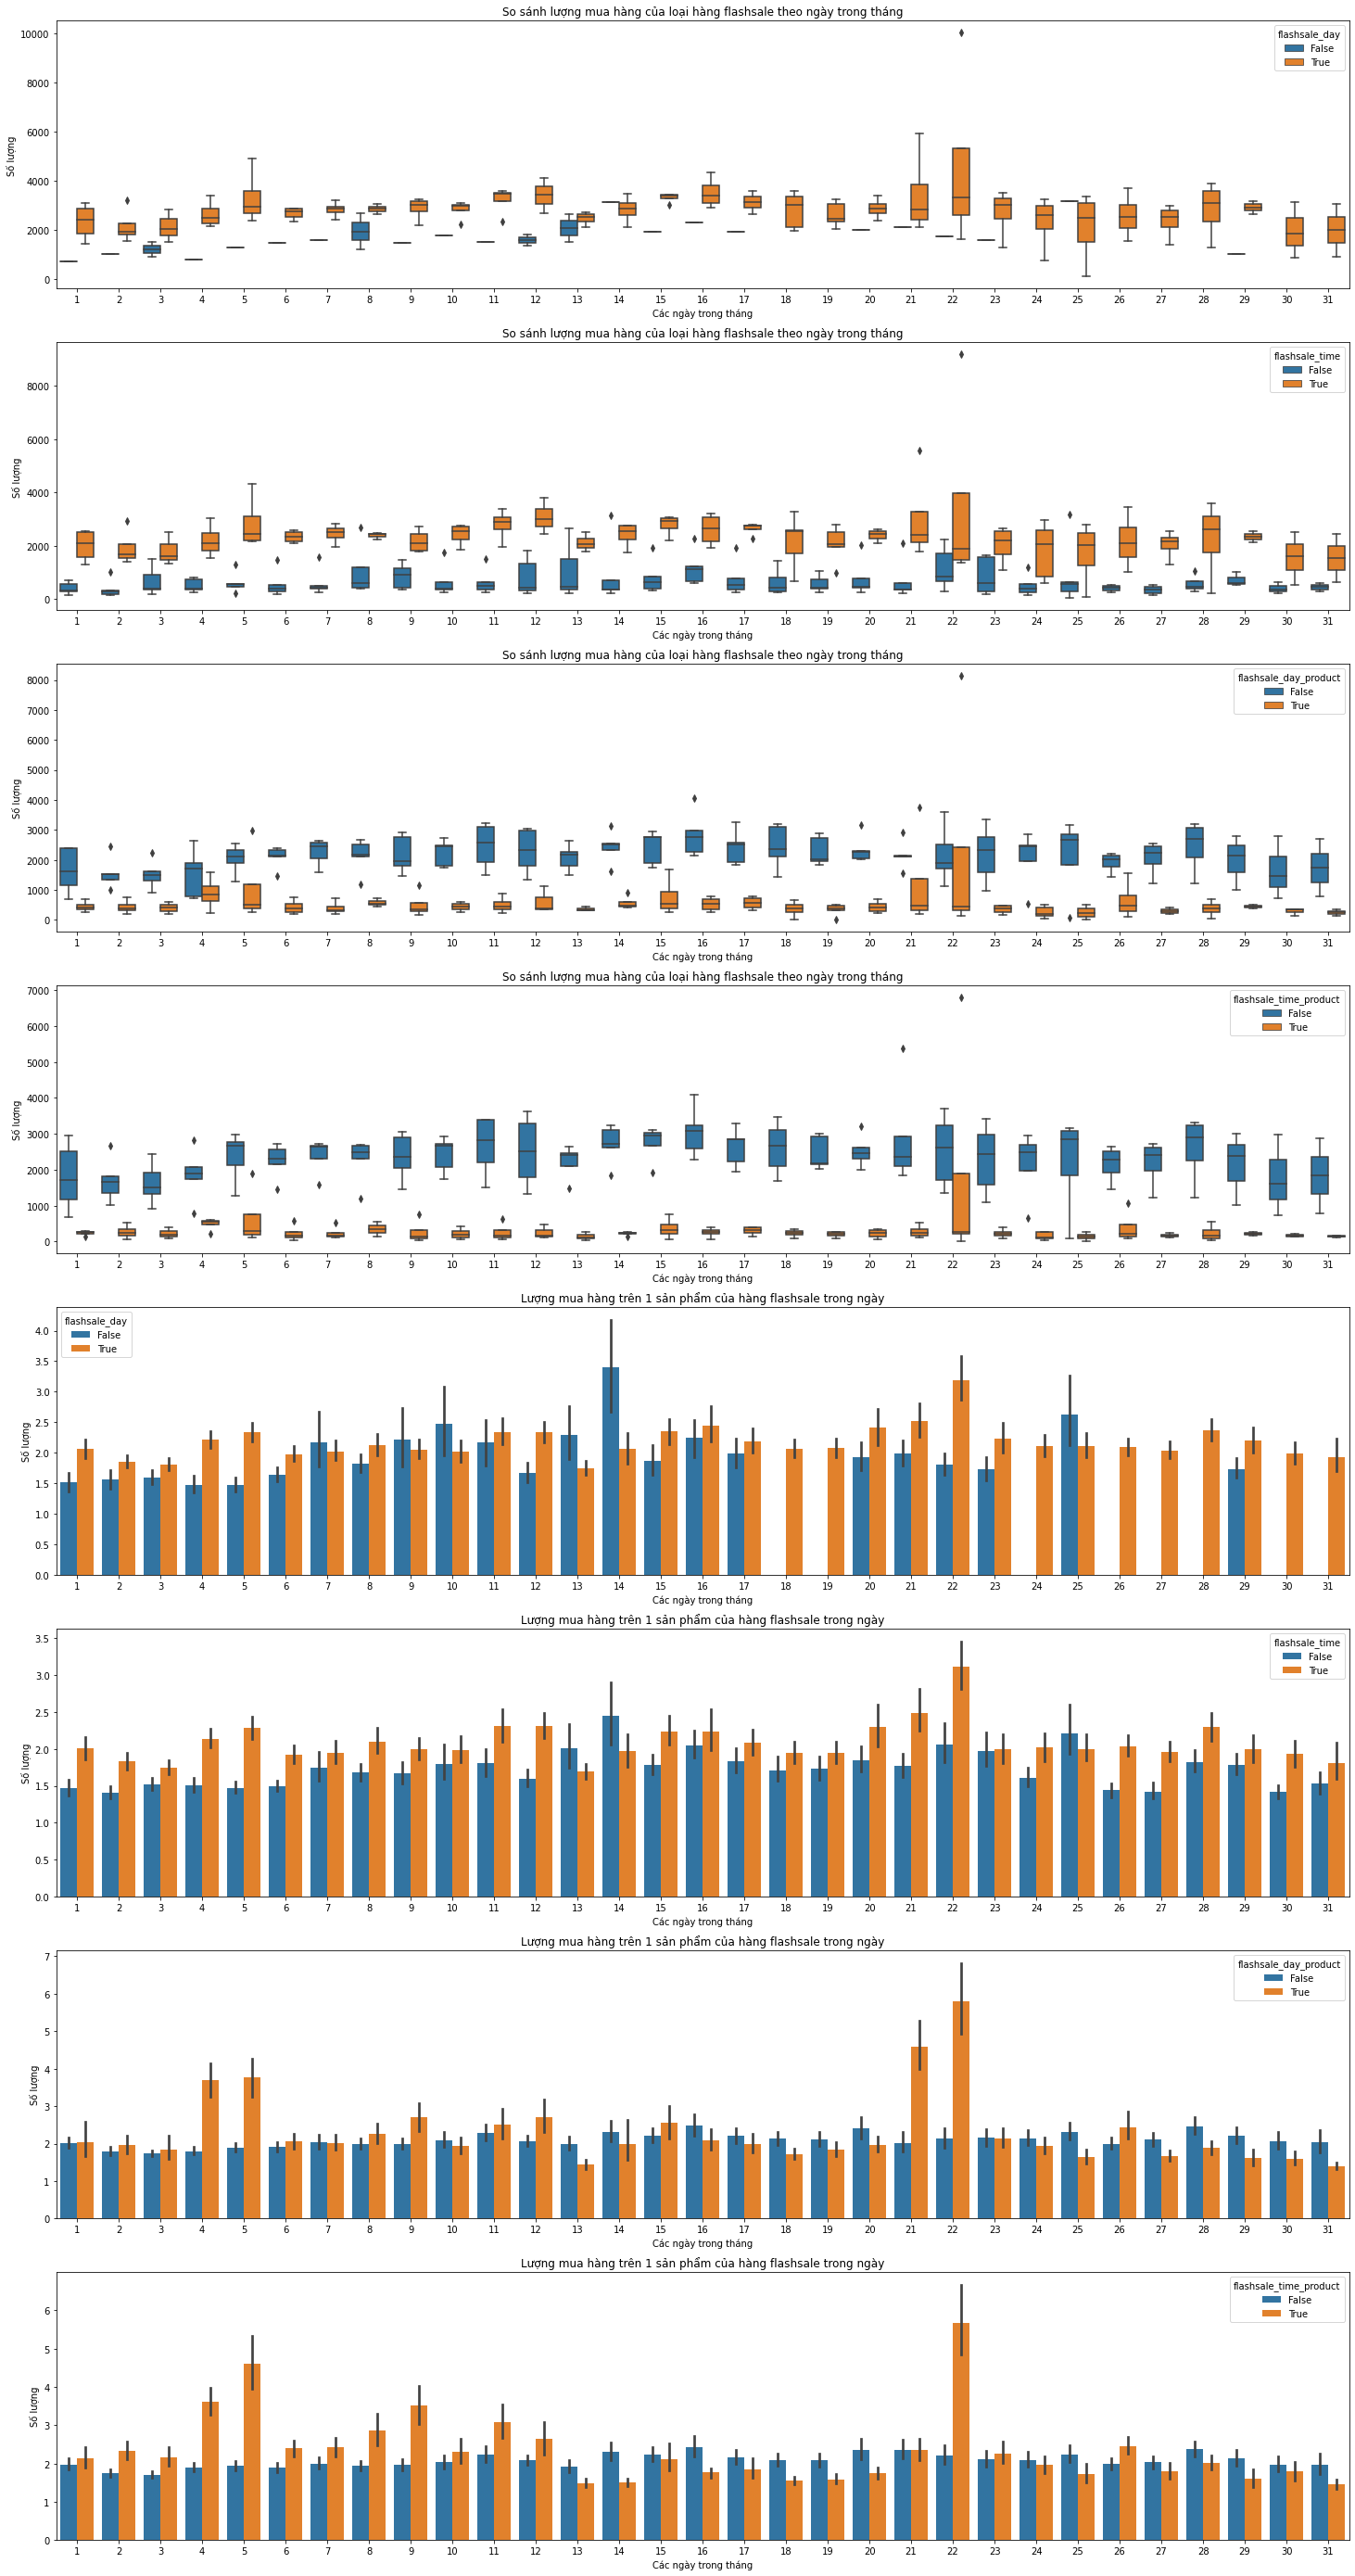

In [91]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

fig, ax = plt.subplots(8, 1, figsize=(25, 50))

show_mean_count_product(df, 'flashsale_day', ax[0])
show_mean_count_product(df, 'flashsale_time', ax[1])
show_mean_count_product(df, 'flashsale_day_product', ax[2])
show_mean_count_product(df, 'flashsale_time_product', ax[3])



# show ra trung bình đơn trên một sản phẩm theo từng ngày, tháng, ngày, giờ
df = fhs_sales_flat_order_item_state_2022.groupby(['fhs_sales_flat_order_item.sku',
                    fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
df  = df.loc[df['flashsale_product'] == True]

# ----------------------------------------------- #
show_mean_count_product_per_sku(df, 'flashsale_day', ax[4])
show_mean_count_product_per_sku(df, 'flashsale_time', ax[5])
show_mean_count_product_per_sku(df, 'flashsale_day_product', ax[6])
show_mean_count_product_per_sku(df, 'flashsale_time_product', ax[7])



In [46]:
def show_line_count_product_hour(df, hue, ax1, ax2):
          # Show ra khác biệt về ngày có flashsale
          df1 = df.loc[df['flashsale_product'] == True]
          df1 = df1.groupby([df1['fhs_sales_flat_order_item.created_at_date'].dt.date,
                              df1['fhs_sales_flat_order_item.created_at_hour'],
                              hue])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at_date')

          # --------------------------------------------------------- #
          temp = df1.loc[df1[hue] == False]
          temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
          sns.lineplot(data = temp, 
                    x = temp['fhs_sales_flat_order_item.created_at_hour'],
                    y = temp['fhs_sales_flat_order.entity_id'],
                    hue = temp['fhs_sales_flat_order_item.created_at_date'] , ax = ax1)
          ax1.set_ylabel('Số lượng')
          ax1.set_title(f'Lượng mua hàng của loại hàng flashsale theo giờ {hue} == False')
          ax1.set_xlabel('Các giờ trong ngày')
          ax1.get_legend().remove()

          # --------------------------------------------------------- #
          temp = df1.loc[df1[hue] == True]
          temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
          sns.lineplot(data = temp, 
                    x = temp['fhs_sales_flat_order_item.created_at_hour'],
                    y = temp['fhs_sales_flat_order.entity_id'],
                    hue = temp['fhs_sales_flat_order_item.created_at_date'], ax = ax2)
          ax2.set_ylabel('Số lượng')
          ax2.set_title(f'Lượng mua hàng của loại hàng flashsale theo giờ {hue} == True')
          ax2.set_xlabel('Các giờ trong ngày')
          ax2.get_legend().remove()

def show_line_count_product_per_sku_hour(df, hue, ax1, ax2):
          df1 = df.groupby(['fhs_sales_flat_order_item.sku',
                    df['fhs_sales_flat_order_item.created_at_date'].dt.date,
                    df['fhs_sales_flat_order_item.created_at_hour'], hue])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at_date')

          # ------------------------------------------------------ #
          temp = df1.loc[df1[hue] == False]
          temp = temp.sort_values('fhs_sales_flat_order_item.created_at_date')

          temp = temp.groupby([temp['fhs_sales_flat_order_item.created_at_date'].dt.date,
                               'fhs_sales_flat_order_item.created_at_hour'])['fhs_sales_flat_order.entity_id'].mean()
          temp = temp.reset_index()
          string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at_date')
          sns.lineplot(data = temp, 
                    x = temp['fhs_sales_flat_order_item.created_at_hour'],
                    y = temp['fhs_sales_flat_order.entity_id'],
                    hue = temp['fhs_sales_flat_order_item.created_at_date'].dt.date,
                    ax = ax1, palette = "tab10")
          ax1.set_xlabel('Các giờ trong ngày')
          ax1.set_ylabel('Số lượng')
          ax1.set_title(f'Lượng mua hàng trên 1 sản phẩm trong ngày {hue} == False')
          ax1.get_legend().remove()


          # ------------------------------------------------------ #
          temp = df1.loc[df1[hue] == True]
          temp = temp.sort_values('fhs_sales_flat_order_item.created_at_date')

          temp = temp.groupby([temp['fhs_sales_flat_order_item.created_at_date'].dt.date,
                               'fhs_sales_flat_order_item.created_at_hour'])['fhs_sales_flat_order.entity_id'].mean()
          temp = temp.reset_index()
          string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at_date')
          sns.lineplot(data = temp, 
                    x = temp['fhs_sales_flat_order_item.created_at_hour'],
                    y = temp['fhs_sales_flat_order.entity_id'],
                    hue = temp['fhs_sales_flat_order_item.created_at_date'].dt.date,
                    ax = ax2, palette = "tab10")
          ax2.set_xlabel('Các giờ trong ngày')
          ax2.set_ylabel('Số lượng')
          ax2.set_title(f'Lượng mua hàng trên 1 sản phẩm trong ngày {hue} == True')
          ax2.get_legend().remove()




/tmp/ipykernel_64275/1501461716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
/tmp/ipykernel_64275/1501461716.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['fhs_sales_flat_order.entity_id'] = temp['fhs_sales_flat_order.entity_id'].rolling(3).mean()
/tmp/ipykernel_64275/1501461716.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

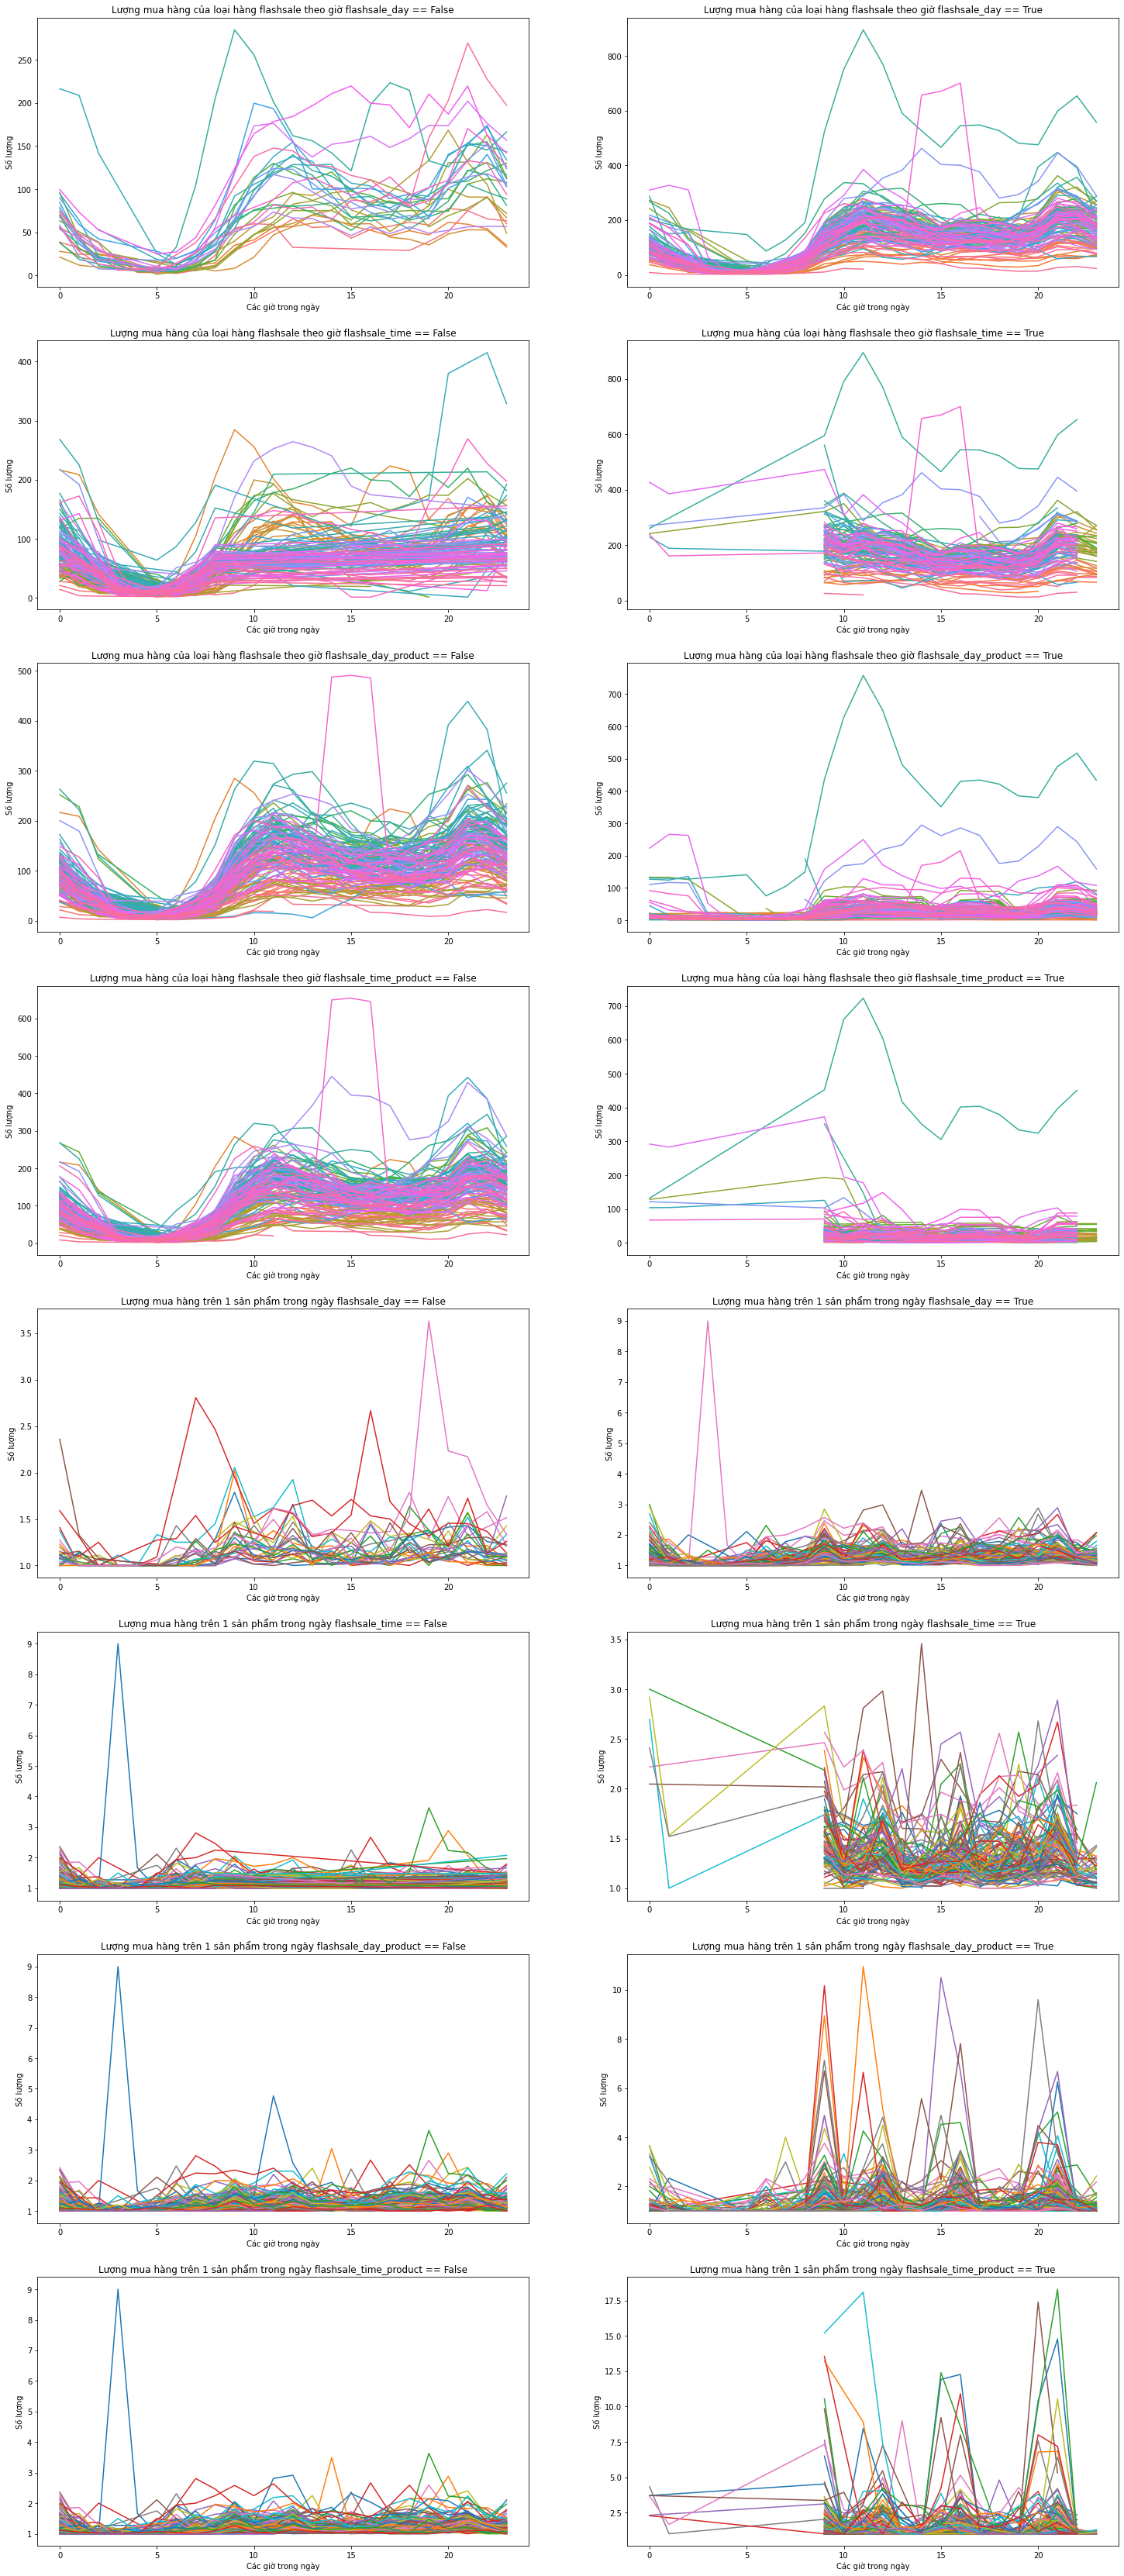

In [47]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.hour,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()
df.index.names = ['fhs_sales_flat_order_item.created_at_date', 
                    'fhs_sales_flat_order_item.created_at_hour', 'flashsale_product', 
                    'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product']
# reset index đưa về dataframe
df = df.reset_index()
# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at_date')

fig, ax = plt.subplots(8, 2, figsize=(25,60))

show_line_count_product_hour(df, 'flashsale_day', ax[0,0], ax[0,1])
show_line_count_product_hour(df, 'flashsale_time', ax[1,0], ax[1,1])
show_line_count_product_hour(df, 'flashsale_day_product', ax[2,0], ax[2,1])
show_line_count_product_hour(df, 'flashsale_time_product', ax[3,0], ax[3,1])


# show ra tỉ lệ đơn trên 1 sản phẩm
df = fhs_sales_flat_order_item_state_2022.groupby(['fhs_sales_flat_order_item.sku',
                    fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.hour,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

df.index.names = [  'fhs_sales_flat_order_item.sku',
                    'fhs_sales_flat_order_item.created_at_date', 
                    'fhs_sales_flat_order_item.created_at_hour', 'flashsale_product', 
                    'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product']
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at_date')
df  = df.loc[df['flashsale_product'] == True]


show_line_count_product_per_sku_hour(df, 'flashsale_day', ax[4,0], ax[4,1])
show_line_count_product_per_sku_hour(df, 'flashsale_time', ax[5,0], ax[5,1])
show_line_count_product_per_sku_hour(df, 'flashsale_day_product', ax[6,0], ax[6,1])
show_line_count_product_per_sku_hour(df, 'flashsale_time_product', ax[7,0], ax[7,1])




Text(0.5, 1.0, 'Lượng mua hàng trên 1 sản phẩm của hàng flashsale trong ngày')

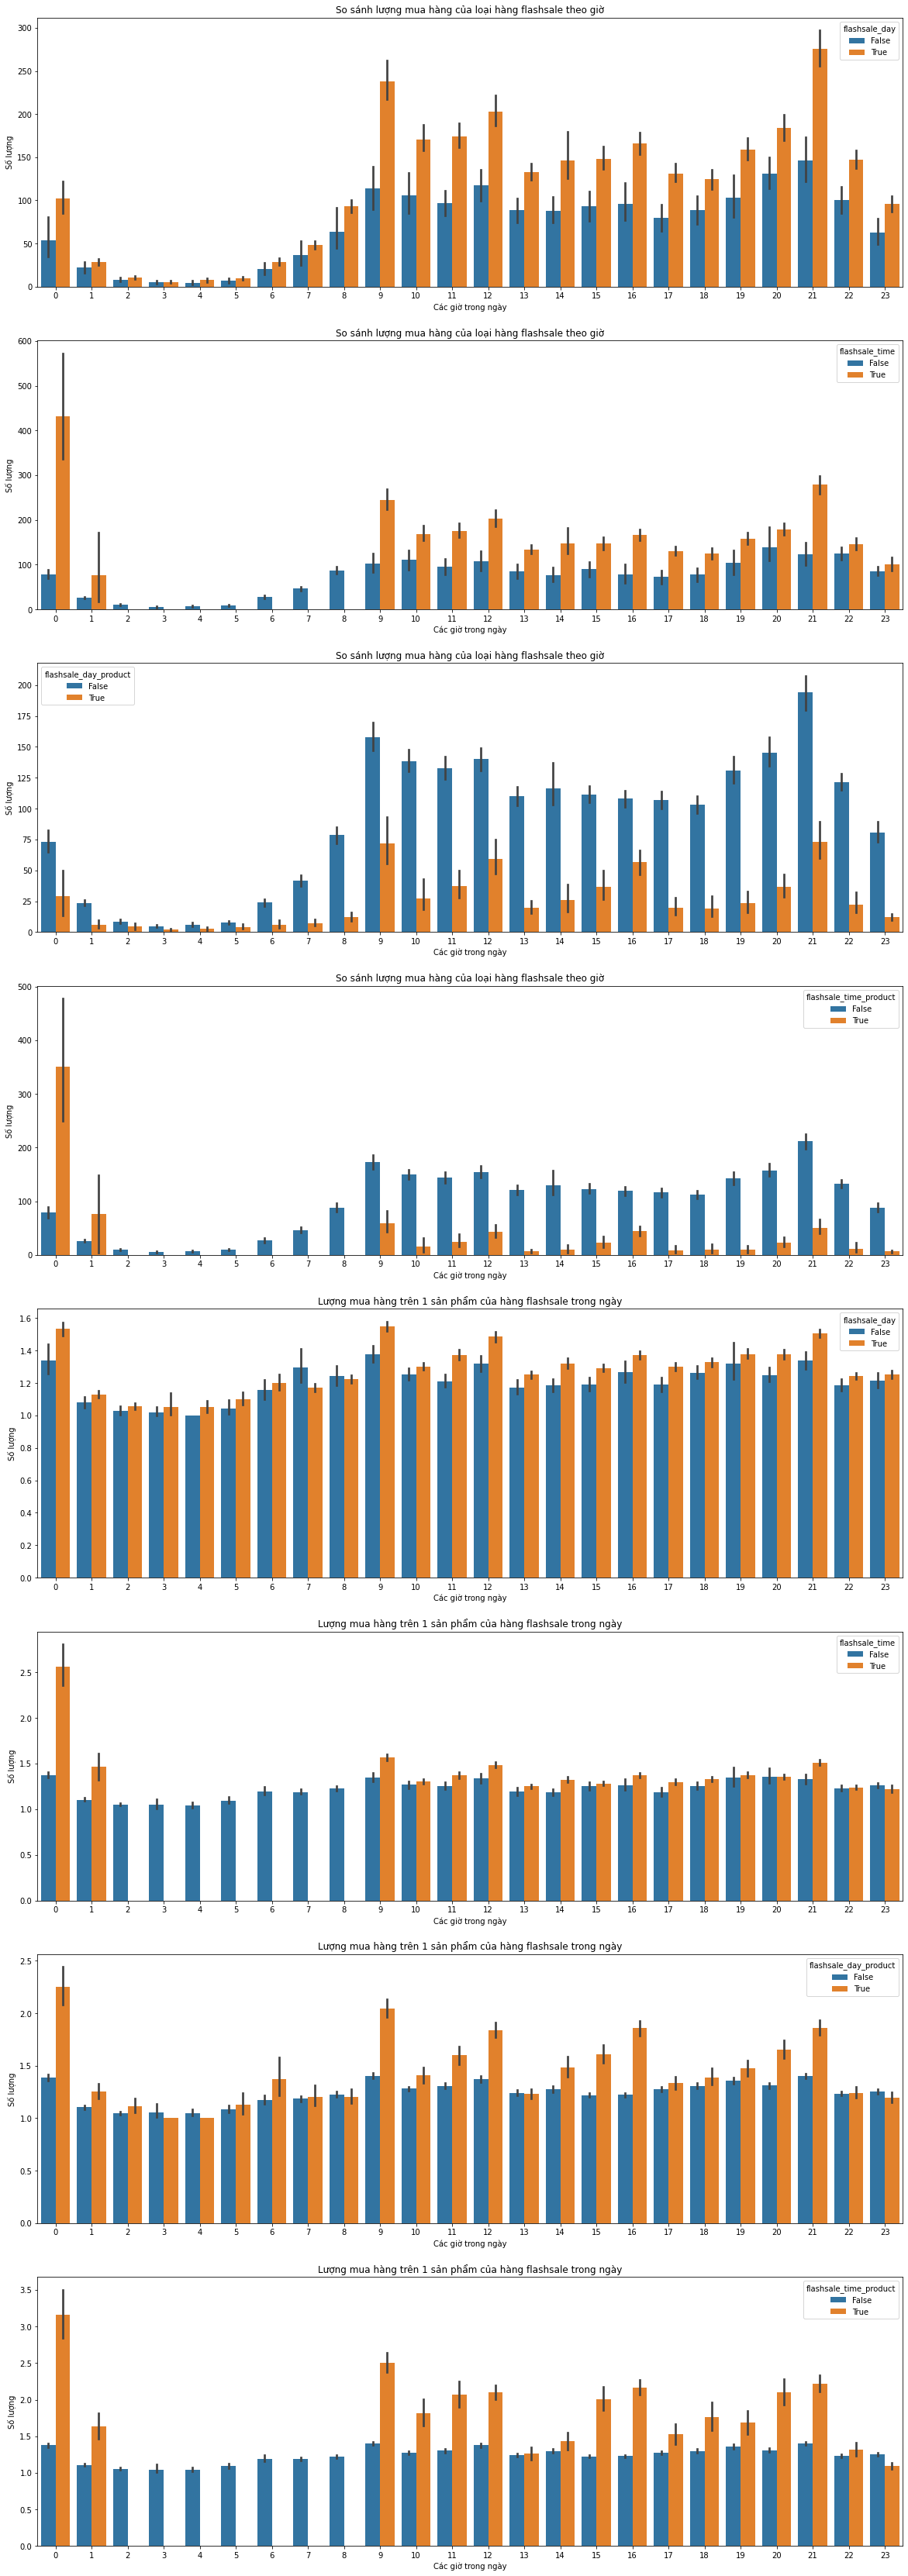

In [48]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.hour,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()
df.index.names = ['fhs_sales_flat_order_item.created_at_date', 
                    'fhs_sales_flat_order_item.created_at_hour', 'flashsale_product', 
                    'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product']
# reset index đưa về dataframe
df = df.reset_index()
# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at_date')

fig, ax = plt.subplots(8, 1, figsize=(20,60))

# Show ra khác biệt về ngày có flashsale
df1 = df.loc[df['flashsale_product'] == True]
df1 = df1.groupby([df1['fhs_sales_flat_order_item.created_at_date'].dt.date,
                    df1['fhs_sales_flat_order_item.created_at_hour'],
                    'flashsale_day'])['fhs_sales_flat_order.entity_id'].sum()
df1 = df1.reset_index()
string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at_date')

sns.barplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at_hour'],
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_day', ax = ax[0], palette="tab10", estimator = np.mean)
ax[0].set_ylabel('Số lượng')
ax[0].set_title('So sánh lượng mua hàng của loại hàng flashsale theo giờ')
ax[0].set_xlabel('Các giờ trong ngày')

# Show ra khác biệt về giờ có flashsale
df2 = df.loc[df['flashsale_product'] == True]
df2 = df2.groupby([df2['fhs_sales_flat_order_item.created_at_date'].dt.date,
                    df2['fhs_sales_flat_order_item.created_at_hour'],
                    'flashsale_time'])['fhs_sales_flat_order.entity_id'].sum()
df2 = df2.reset_index()
string_to_datetime(df2, 'fhs_sales_flat_order_item.created_at_date')
sns.barplot(data = df2, 
          x = df2['fhs_sales_flat_order_item.created_at_hour'],
          y = df2['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time', ax = ax[1], palette="tab10", estimator = np.mean)
ax[1].set_ylabel('Số lượng')
ax[1].set_title('So sánh lượng mua hàng của loại hàng flashsale theo giờ')
ax[1].set_xlabel('Các giờ trong ngày')

# Show ra khác biệt về ngày có flashsale củ sản phẩm đó
df3 = df.loc[df['flashsale_product'] == True]
df3 = df3.groupby([df3['fhs_sales_flat_order_item.created_at_date'].dt.date,
                    df3['fhs_sales_flat_order_item.created_at_hour'],
                    'flashsale_day_product'])['fhs_sales_flat_order.entity_id'].sum()
df3 = df3.reset_index()
string_to_datetime(df3, 'fhs_sales_flat_order_item.created_at_date')
sns.barplot(data = df3, 
          x = df3['fhs_sales_flat_order_item.created_at_hour'],
          y = df3['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_day_product', ax = ax[2], palette="tab10", estimator = np.mean)
ax[2].set_ylabel('Số lượng')
ax[2].set_title('So sánh lượng mua hàng của loại hàng flashsale theo giờ')
ax[2].set_xlabel('Các giờ trong ngày')

# Show ra khác biệt về giờ có flashsale của sản phẩm đó
df4 = df.loc[df['flashsale_product'] == True]
df4 = df4.groupby([df4['fhs_sales_flat_order_item.created_at_date'].dt.date,
                    df4['fhs_sales_flat_order_item.created_at_hour'],
                    'flashsale_time_product'])['fhs_sales_flat_order.entity_id'].sum()
df4 = df4.reset_index()
string_to_datetime(df4, 'fhs_sales_flat_order_item.created_at_date')
sns.barplot(data = df4, 
          x = df4['fhs_sales_flat_order_item.created_at_hour'],
          y = df4['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[3], palette="tab10", estimator = np.mean)
ax[3].set_ylabel('Số lượng')
ax[3].set_title('So sánh lượng mua hàng của loại hàng flashsale theo giờ')
ax[3].set_xlabel('Các giờ trong ngày')


# show ra tỉ lệ đơn trên 1 sản phẩm
df = fhs_sales_flat_order_item_state_2022.groupby(['fhs_sales_flat_order_item.sku',
                    fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.hour,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

df.index.names = [  'fhs_sales_flat_order_item.sku',
                    'fhs_sales_flat_order_item.created_at_date', 
                    'fhs_sales_flat_order_item.created_at_hour', 'flashsale_product', 
                    'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product']
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at_date')
df  = df.loc[df['flashsale_product'] == True]

temp = df.groupby(['fhs_sales_flat_order_item.sku',
          df['fhs_sales_flat_order_item.created_at_date'].dt.date,
          df['fhs_sales_flat_order_item.created_at_hour'], 'flashsale_day'])['fhs_sales_flat_order.entity_id'].sum()
temp = temp.reset_index()
string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at_date')
sns.barplot(data = temp, 
          x = temp['fhs_sales_flat_order_item.created_at_hour'],
          y = temp['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_day', ax = ax[4], palette = "tab10", estimator = np.mean)
ax[4].set_xlabel('Các giờ trong ngày')
ax[4].set_ylabel('Số lượng')
ax[4].set_title('Lượng mua hàng trên 1 sản phẩm của hàng flashsale trong ngày')

temp = df.groupby(['fhs_sales_flat_order_item.sku',
          df['fhs_sales_flat_order_item.created_at_date'].dt.date,
          df['fhs_sales_flat_order_item.created_at_hour'], 'flashsale_time'])['fhs_sales_flat_order.entity_id'].sum()
temp = temp.reset_index()
string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at_date')
sns.barplot(data = temp, 
          x = temp['fhs_sales_flat_order_item.created_at_hour'],
          y = temp['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time', ax = ax[5], palette = "tab10", estimator = np.mean)
ax[5].set_xlabel('Các giờ trong ngày')
ax[5].set_ylabel('Số lượng')
ax[5].set_title('Lượng mua hàng trên 1 sản phẩm của hàng flashsale trong ngày')

temp = df.groupby(['fhs_sales_flat_order_item.sku',
          df['fhs_sales_flat_order_item.created_at_date'].dt.date,
          df['fhs_sales_flat_order_item.created_at_hour'], 'flashsale_day_product'])['fhs_sales_flat_order.entity_id'].sum()
temp = temp.reset_index()
string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at_date')
sns.barplot(data = temp, 
          x = temp['fhs_sales_flat_order_item.created_at_hour'],
          y = temp['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_day_product', ax = ax[6], palette = "tab10", estimator = np.mean)
ax[6].set_xlabel('Các giờ trong ngày')
ax[6].set_ylabel('Số lượng')
ax[6].set_title('Lượng mua hàng trên 1 sản phẩm của hàng flashsale trong ngày')

temp = df.groupby(['fhs_sales_flat_order_item.sku',
          df['fhs_sales_flat_order_item.created_at_date'].dt.date,
          df['fhs_sales_flat_order_item.created_at_hour'], 'flashsale_time_product'])['fhs_sales_flat_order.entity_id'].sum()
temp = temp.reset_index()
string_to_datetime(temp, 'fhs_sales_flat_order_item.created_at_date')
sns.barplot(data = temp, 
          x = temp['fhs_sales_flat_order_item.created_at_hour'],
          y = temp['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[7], palette = "tab10", estimator = np.mean)
ax[7].set_xlabel('Các giờ trong ngày')
ax[7].set_ylabel('Số lượng')
ax[7].set_title('Lượng mua hàng trên 1 sản phẩm của hàng flashsale trong ngày')

- Tỉ lệ phần trăm mà sản phẩm flashsale bán được trong tháng, ngày trong tuần, ngày trong tháng, và theo giờ

In [49]:
# Lấy ra các đơn hàng flashsale_time_product = True 
# bao gồm cả complete và canceled
df = fhs_sales_flat_order_item_state_2022\
          .loc[fhs_sales_flat_order_item_state_2022['flashsale_time_product'] == True]

temp = pd.merge(df, fhs_flashsale_product_info_2022,
                    left_on='fhs_sales_flat_order_item.sku',
                    right_on='fhs_catalog_product_entity.sku')

temp = temp.loc[(temp['fhs_sales_flat_order_item.created_at'] > temp['fhs_flashsale_period.start_date'])
&               (temp['fhs_sales_flat_order_item.created_at'] < temp['fhs_flashsale_period.end_date'])]

fhs_sales_flat_order_item_flashsale_2022 = temp.drop_duplicates(subset = fhs_sales_flat_order_item_state_2022.columns)
fhs_sales_flat_order_item_flashsale_2022['count'] = 1

/tmp/ipykernel_64275/3027984992.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fhs_sales_flat_order_item_flashsale_2022['count'] = 1


/tmp/ipykernel_64275/7833320.py:31: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = fhs_sales_flat_order_item_flashsale_2022.groupby(


13    2022-01-14
41    2022-02-11
48    2022-02-18
58    2022-02-28
74    2022-03-16
81    2022-03-23
83    2022-03-25
86    2022-03-28
90    2022-04-01
110   2022-04-21
114   2022-04-25
124   2022-05-05
131   2022-05-12
133   2022-05-14
139   2022-05-20
Name: fhs_sales_flat_order_item.created_at, dtype: datetime64[ns]
30    2022-02-26
32    2022-02-28
34    2022-03-02
36    2022-03-04
54    2022-03-22
67    2022-04-04
83    2022-04-21
96    2022-05-05
100   2022-05-09
102   2022-05-11
105   2022-05-15
Name: fhs_sales_flat_order_item.created_at, dtype: datetime64[ns]


<AxesSubplot:xlabel='fhs_sales_flat_order_item.created_at', ylabel='fhs_sales_flat_order.entity_id'>

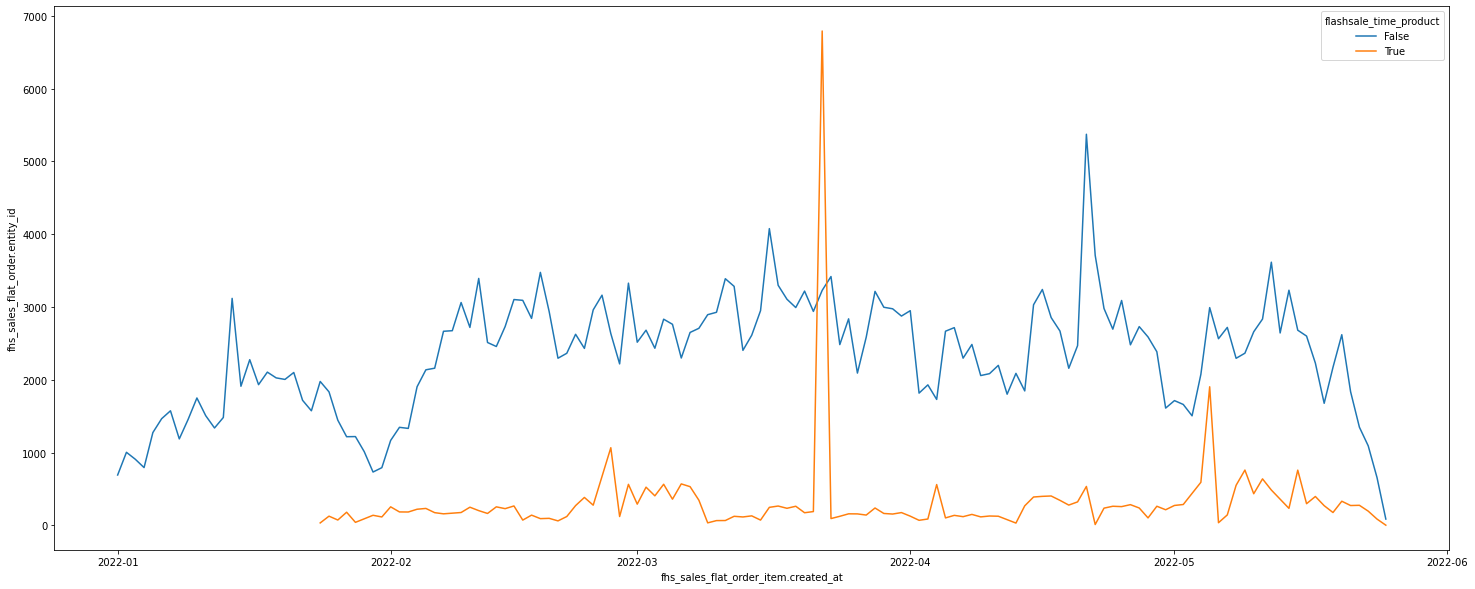

In [168]:
def temp():
          df = fhs_sales_flat_order_item_state_2022         \
                    .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                              'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product', 'flashsale_day_product'])\
                              ['fhs_sales_flat_order.entity_id'].count()

          # reset index đưa về dataframe
          df = df.reset_index()
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

          # Show ra khác biệt về ngày
          df1 = df.loc[df['flashsale_product'] == True]
          df1 = df1.groupby([df1['fhs_sales_flat_order_item.created_at'].dt.date, 'flashsale_time_product'])['fhs_sales_flat_order.entity_id'].sum()
          df1 = df1.reset_index()
          string_to_datetime(df1, 'fhs_sales_flat_order_item.created_at')
          # df1['fhs_sales_flat_order.entity_id'] = df1['fhs_sales_flat_order.entity_id'].rolling(3).mean()

          # ----------------------------------------------- #
          df1 = df1.sort_values('fhs_sales_flat_order_item.created_at')
          return df1

def temp2():

          k = fhs_sales_flat_order_item_state_2022\
                    .groupby(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date).keys
          date = list(set(k))
          k = pd.DataFrame({'date':date})
          string_to_datetime(k, 'date')

          # chứa thông tin về đơn hàng bán trong từng ngày
          df = fhs_sales_flat_order_item_flashsale_2022.groupby(
                    fhs_sales_flat_order_item_flashsale_2022['fhs_sales_flat_order_item.created_at'].dt.date)\
                              ['fhs_flashsale_product.total_items', 'count'].sum()
          df = df.reset_index()
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

          df = pd.merge(k, df, left_on='date', right_on='fhs_sales_flat_order_item.created_at', how = 'left')
          # df = df.drop_duplicates(subset = 'date')

          df['percent'] = df['count']/df['fhs_flashsale_product.total_items']
          df.loc[df['fhs_flashsale_product.total_items'] == 0, 'percent'] = 0
          df.loc[pd.isna(df['percent']), 'percent'] = 0

          df = df.sort_values('date')
          df = df[['date', 'percent']]
          # df là chứa phần trăm lượng hàng được bán ra
          return df


def find_max_min_local(series, threshold = 800):
    """
        Input: 
            series: list
        Return:
            list of index
    """
    result = []
    for i in range(1, len(series) - 1):
        if series[i] > series[i - 1] and series[i] > series[i + 1]:
            temp = series[i]*2 - series[i - 1] - series[i + 1]
            if temp > threshold:
                result.append(i)
        # elif series[i] < series[i - 1] and series[i] < series[i + 1]: 
        #     temp = series[i - 1] + series[i + 1] - series[i]*2
        #     if temp > threshold:
        #         result.append(i)
    return result

df = temp2()
df1 = temp()

df = df.reset_index()
alibaba = df1.loc[df1['flashsale_time_product'] == False]
alibaba = alibaba.reset_index()
days_df1 = alibaba['fhs_sales_flat_order_item.created_at']
result = find_max_min_local(alibaba['fhs_sales_flat_order.entity_id'])
print(days_df1[result])

alibaba = df1.loc[df1['flashsale_time_product'] == True]
alibaba = alibaba.reset_index()
days_df1 = alibaba['fhs_sales_flat_order_item.created_at']
result = find_max_min_local(alibaba['fhs_sales_flat_order.entity_id'], 300)
print(days_df1[result])

fig, ax = plt.subplots(1,1,figsize = (25,10))

# sns.lineplot(data = df, x = 'date', y = 'percent', ax = ax)
sns.lineplot(data = df1, x = 'fhs_sales_flat_order_item.created_at', 
                    y = 'fhs_sales_flat_order.entity_id', hue = 'flashsale_time_product', ax = ax)

/tmp/ipykernel_64275/3469622280.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = fhs_sales_flat_order_item_flashsale_2022.groupby(
/tmp/ipykernel_64275/3469622280.py:60: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = fhs_sales_flat_order_item_flashsale_2022.groupby(


Text(0.5, 0, 'Các giờ trong ngày')

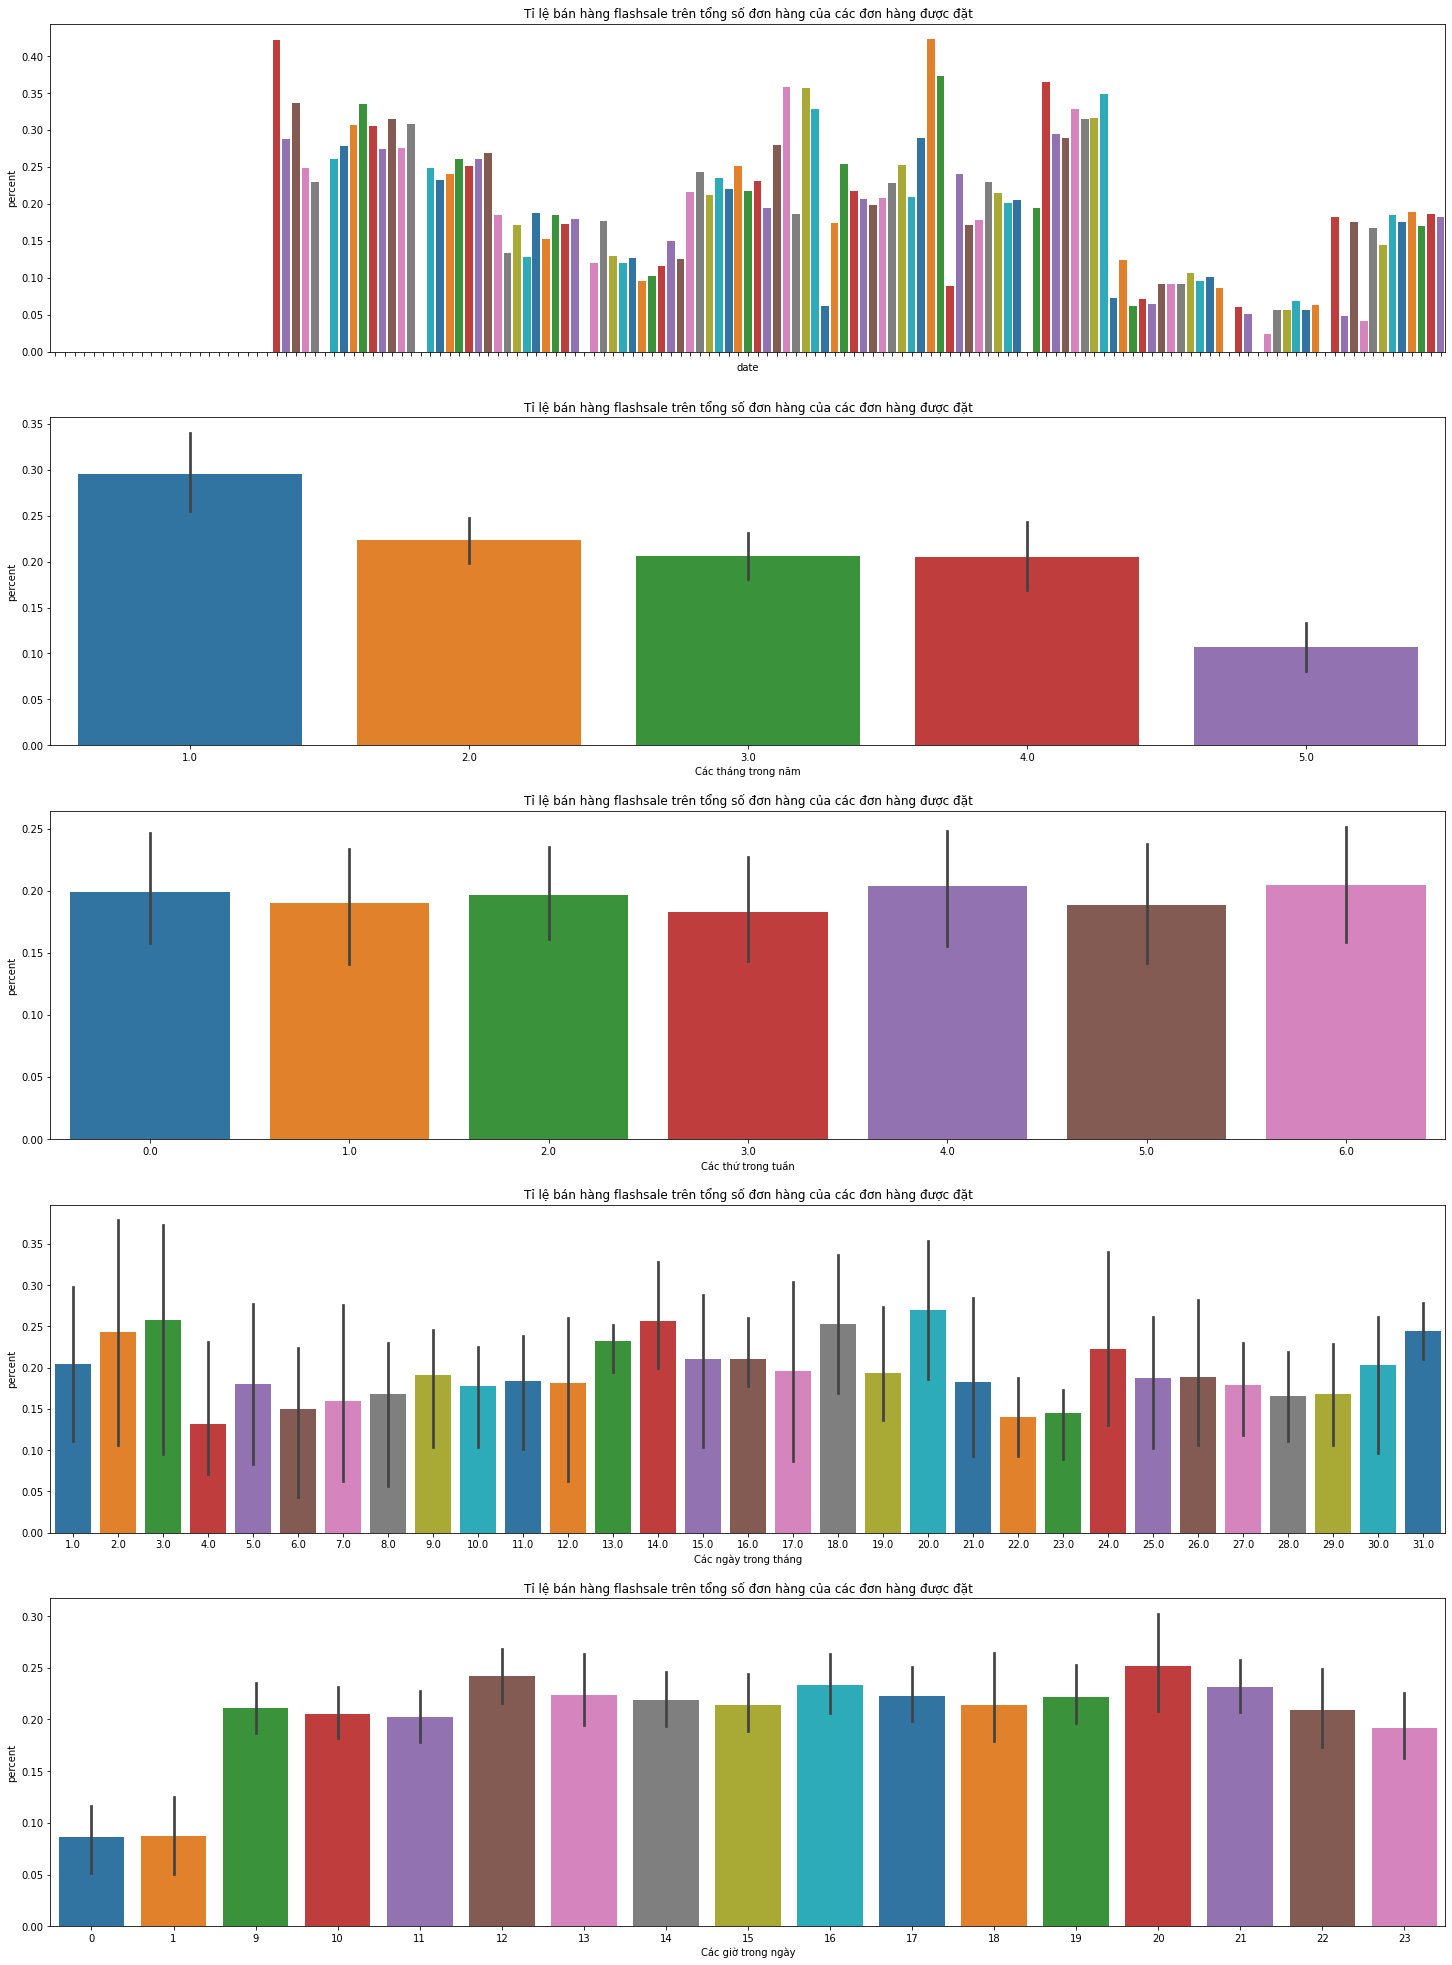

In [130]:
k = fhs_sales_flat_order_item_state_2022\
          .groupby(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date).keys
date = list(set(k))
k = pd.DataFrame({'date':date})
string_to_datetime(k, 'date')

# chứa thông tin về đơn hàng bán trong từng ngày
df = fhs_sales_flat_order_item_flashsale_2022.groupby(
          fhs_sales_flat_order_item_flashsale_2022['fhs_sales_flat_order_item.created_at'].dt.date)\
                    ['fhs_flashsale_product.total_items', 'count'].sum()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

df = pd.merge(k, df, left_on='date', right_on='fhs_sales_flat_order_item.created_at', how = 'left')
# df = df.drop_duplicates(subset = 'date')

df['percent'] = df['count']/df['fhs_flashsale_product.total_items']
df.loc[df['fhs_flashsale_product.total_items'] == 0, 'percent'] = 0
df.loc[pd.isna(df['percent']), 'percent'] = 0

df = df.sort_values('date')

fig, ax = plt.subplots(5,1,figsize = (25, 35))


sns.barplot(data = df, 
          x = df['date'],
          y = 'percent',
          ax = ax[0] ,palette = "tab10", estimator = np.mean)
# df.plot.bar(x = 'fhs_sales_flat_order_item.created_at',
#                     y = 'percent', ax  = ax)
# temp = df['percent'].interpolate(method='polynomial', order=5)
# temp.plot.line(ax = ax[0], color = 'red')
ax[0].set_title('Tỉ lệ bán hàng flashsale trên tổng số đơn hàng của các đơn hàng được đặt')
ax[0].set_xticklabels('');
ax[1].set_xlabel('Các ngày từ tháng 1 đến tháng 5 trong 2022')


sns.barplot(data = df, 
          x = df['fhs_sales_flat_order_item.created_at'].dt.month,
          y = 'percent',
          ax = ax[1] ,palette = "tab10", estimator = np.mean)
ax[1].set_title('Tỉ lệ bán hàng flashsale trên tổng số đơn hàng của các đơn hàng được đặt')
ax[1].set_xlabel('Các tháng trong năm')

sns.barplot(data = df, 
          x = df['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
          y = 'percent',
          ax = ax[2] ,palette = "tab10", estimator = np.mean)
ax[2].set_title('Tỉ lệ bán hàng flashsale trên tổng số đơn hàng của các đơn hàng được đặt')
ax[2].set_xlabel('Các thứ trong tuần')

sns.barplot(data = df, 
          x = df['fhs_sales_flat_order_item.created_at'].dt.day,
          y = 'percent',
          ax = ax[3] ,palette = "tab10", estimator = np.mean)
ax[3].set_title('Tỉ lệ bán hàng flashsale trên tổng số đơn hàng của các đơn hàng được đặt')
ax[3].set_xlabel('Các ngày trong tháng')

df = fhs_sales_flat_order_item_flashsale_2022.groupby(
          [fhs_sales_flat_order_item_flashsale_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    fhs_sales_flat_order_item_flashsale_2022['fhs_sales_flat_order_item.created_at'].dt.hour])\
                    ['fhs_flashsale_product.total_items', 'count'].sum()

df.index.names = ['fhs_sales_flat_order_item.created_at_date', 
                    'fhs_sales_flat_order_item.created_at_hour']

# reset index đưa về dataframe
df = df.reset_index()
# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at_date')
df['percent'] = df['count']/df['fhs_flashsale_product.total_items']

df.loc[df['fhs_flashsale_product.total_items'] == 0, 'percent'] = 0

sns.barplot(data = df, 
          x = df['fhs_sales_flat_order_item.created_at_hour'],
          y = 'percent',
          ax = ax[4] ,palette = "tab10", estimator = np.mean)
ax[4].set_title('Tỉ lệ bán hàng flashsale trên tổng số đơn hàng của các đơn hàng được đặt')
ax[4].set_xlabel('Các giờ trong ngày')

In [101]:
k = fhs_sales_flat_order_item_state_2022\
          .groupby(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date).keys
date = list(set(k))
k = pd.DataFrame({'date':date})
string_to_datetime(k, 'date')

df = fhs_flashsale_product_info_2022\
          .groupby([fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'].dt.date,
                    fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'], 
                    fhs_flashsale_product_info_2022['fhs_flashsale_period.end_date']]).count()
df.index.names = ['fhs_flashsale_period.start_date', 
                    'fhs_flashsale_period.start_date_exactly','fhs_flashsale_period.end_date_exactly']
df = df.reset_index()
string_to_datetime(df, 'fhs_flashsale_period.start_date')
string_to_datetime(df, 'fhs_flashsale_period.start_date_exactly')
string_to_datetime(df, 'fhs_flashsale_period.end_date_exactly')

df = pd.merge(k, df, left_on='date', right_on='fhs_flashsale_period.start_date', how = 'left')
# df = df.drop_duplicates(subset = 'date')
df = df.sort_values('date')

df['time'] = df['fhs_flashsale_period.end_date_exactly'] - df['fhs_flashsale_period.start_date_exactly']
df = df.groupby('date')['time'].sum()
df = df.reset_index()
string_to_datetime(df, 'date')

df.loc[df['time'].dt.total_seconds() < 0, 'time'] = pd.Timedelta(0)

df['percent'] =  df['time'].dt.total_seconds()/86400
df

date            time   percent
0   2022-01-01 0 days 00:00:00  0.000000
1   2022-01-02 0 days 00:00:00  0.000000
2   2022-01-03 0 days 00:00:00  0.000000
3   2022-01-04 0 days 00:00:00  0.000000
4   2022-01-05 0 days 00:00:00  0.000000
..         ...             ...       ...
140 2022-05-21 0 days 13:59:47  0.583183
141 2022-05-22 0 days 13:59:47  0.583183
142 2022-05-23 0 days 13:59:47  0.583183
143 2022-05-24 0 days 13:59:47  0.583183
144 2022-05-25 0 days 13:19:47  0.555405

[145 rows x 3 columns]

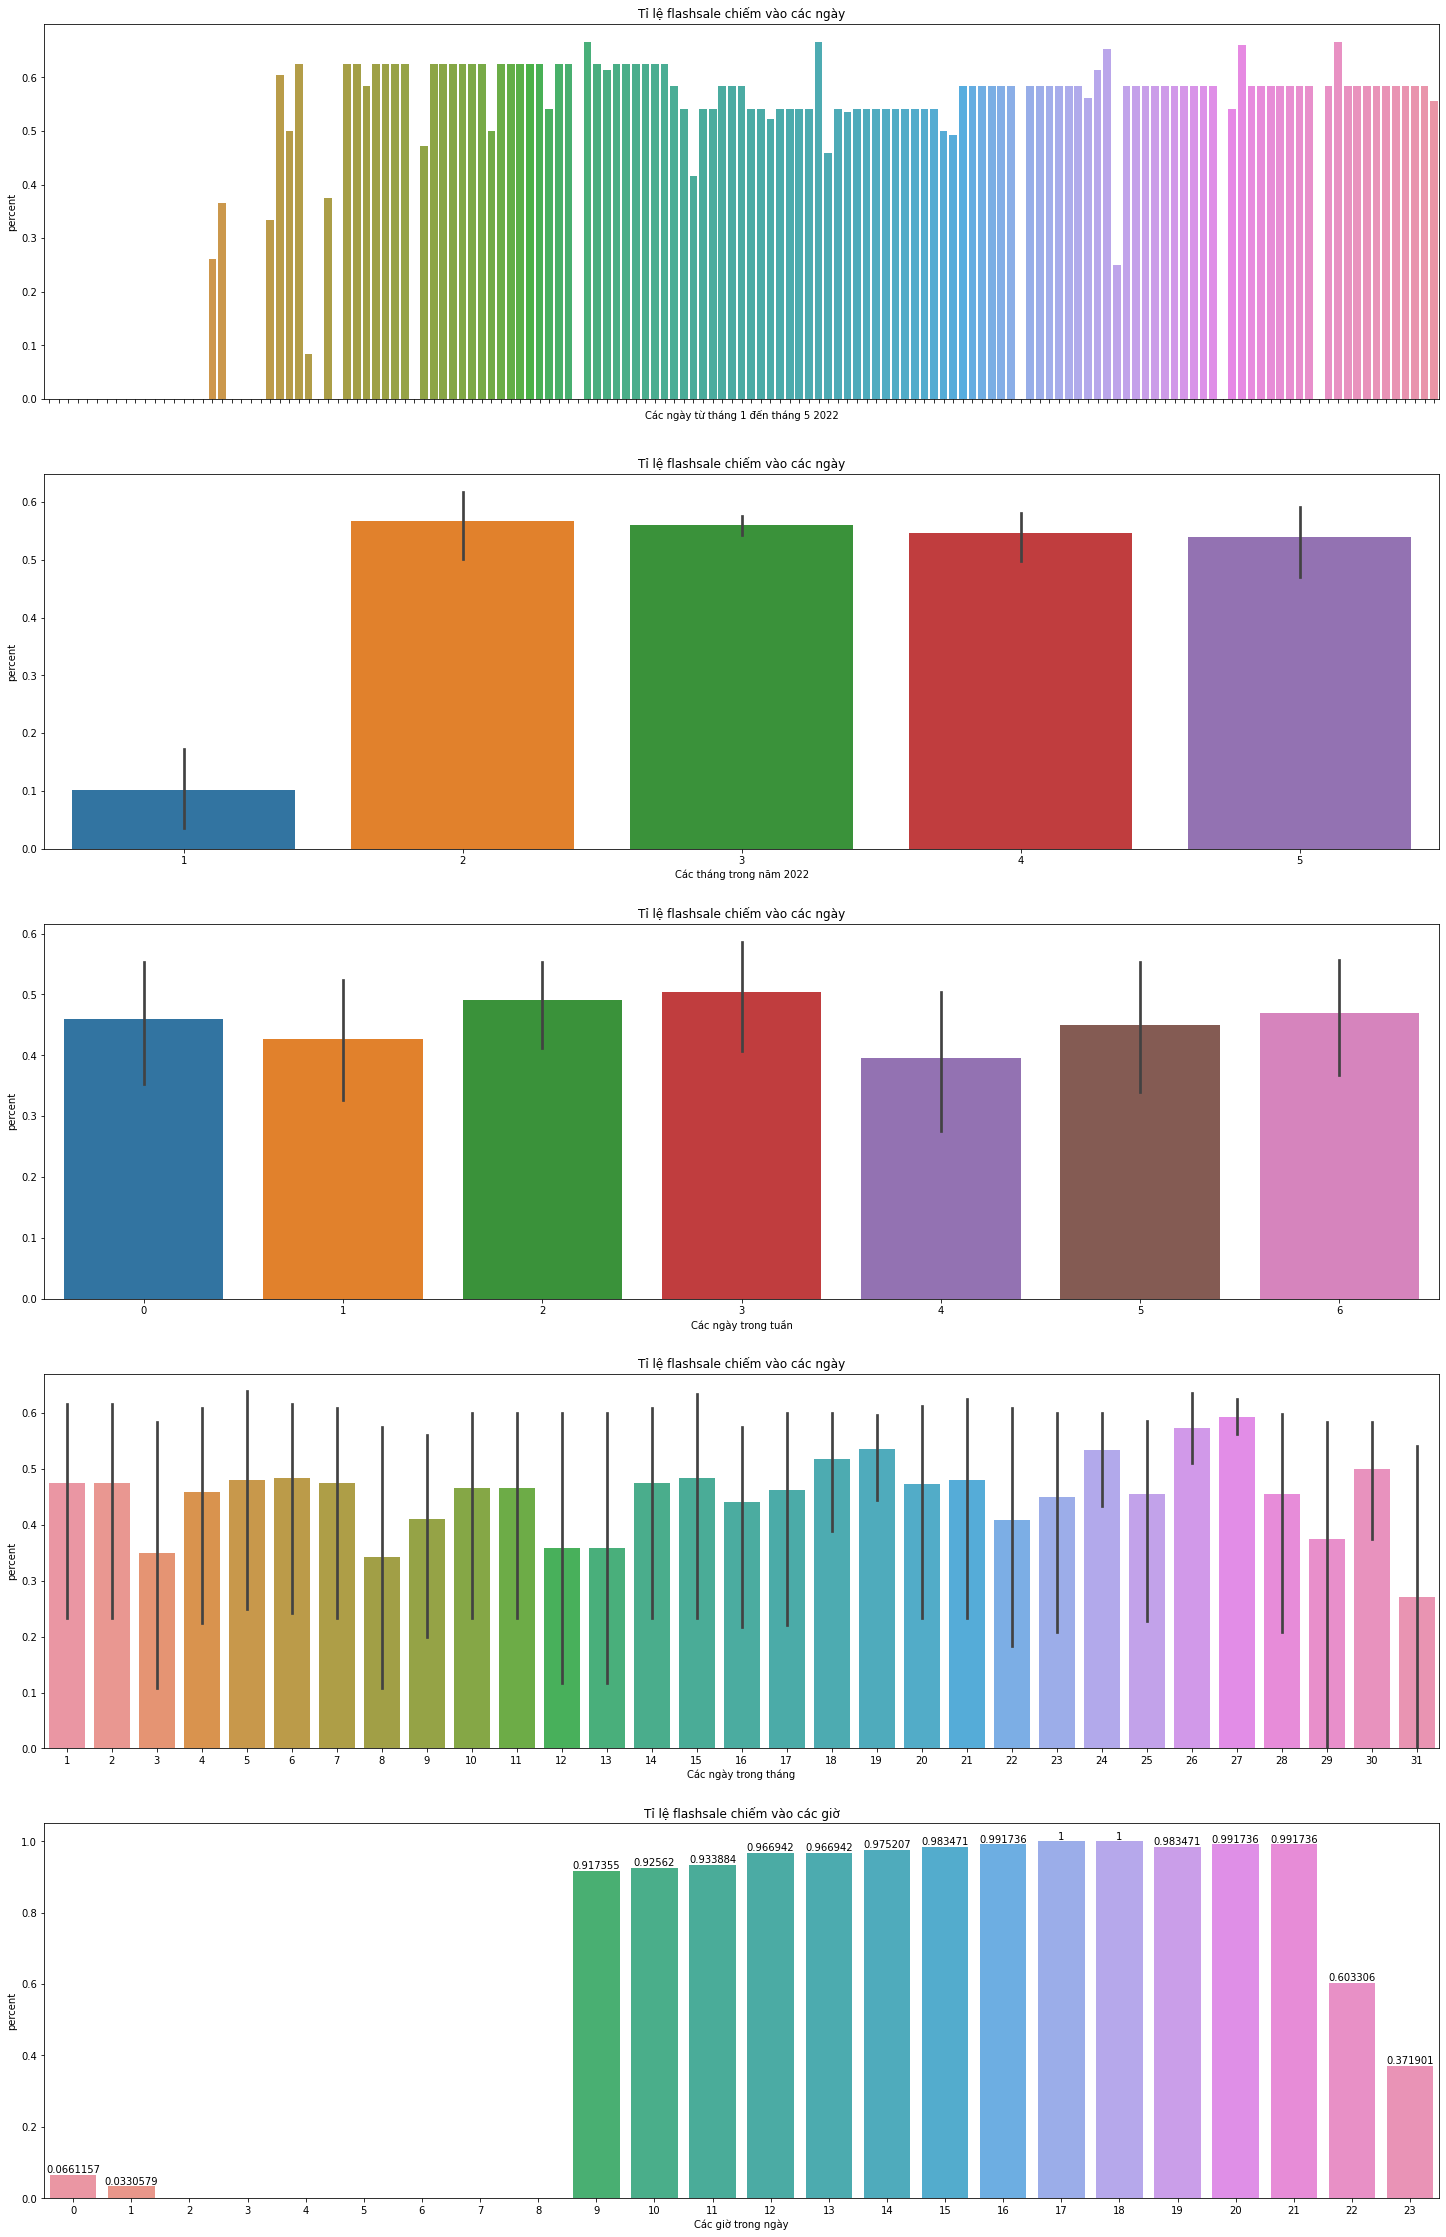

In [103]:
k = fhs_sales_flat_order_item_state_2022\
          .groupby(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date).keys
date = list(set(k))
k = pd.DataFrame({'date':date})
string_to_datetime(k, 'date')

df = fhs_flashsale_product_info_2022\
          .groupby([fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'].dt.date,
                    fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'], 
                    fhs_flashsale_product_info_2022['fhs_flashsale_period.end_date']]).count()
df.index.names = ['fhs_flashsale_period.start_date', 
                    'fhs_flashsale_period.start_date_exactly','fhs_flashsale_period.end_date_exactly']
df = df.reset_index()
string_to_datetime(df, 'fhs_flashsale_period.start_date')
string_to_datetime(df, 'fhs_flashsale_period.start_date_exactly')
string_to_datetime(df, 'fhs_flashsale_period.end_date_exactly')

df = pd.merge(k, df, left_on='date', right_on='fhs_flashsale_period.start_date', how = 'left')
# df = df.drop_duplicates(subset = 'date')
df = df.sort_values('date')

df['time'] = df['fhs_flashsale_period.end_date_exactly'] - df['fhs_flashsale_period.start_date_exactly']
df = df.groupby('date')['time'].sum()
df = df.reset_index()
string_to_datetime(df, 'date')

df.loc[df['time'].dt.total_seconds() < 0, 'time'] = pd.Timedelta(0)
df['percent'] =  df['time'].dt.total_seconds()/86400

fig, ax = plt.subplots(5, 1, figsize = (25, 40))
sns.barplot(data = df, x = 'date',
                    y = 'percent', ax = ax[0])
ax[0].set_xticklabels('')
ax[0].set_title('Tỉ lệ flashsale chiếm vào các ngày')
ax[0].set_xlabel('Các ngày từ tháng 1 đến tháng 5 2022')

sns.barplot(data = df, x = df['date'].dt.month,
                    y = 'percent', ax = ax[1], estimator = np.mean)
ax[1].set_title('Tỉ lệ flashsale chiếm vào các ngày')
ax[1].set_xlabel('Các tháng trong năm 2022')

sns.barplot(data = df, x = df['date'].dt.dayofweek,
                    y = 'percent', ax = ax[2], estimator = np.mean)
ax[2].set_title('Tỉ lệ flashsale chiếm vào các ngày')
ax[2].set_xlabel('Các ngày trong tuần')

sns.barplot(data = df, x = df['date'].dt.day,
                    y = 'percent', ax = ax[3], estimator = np.mean)
ax[3].set_title('Tỉ lệ flashsale chiếm vào các ngày')
ax[3].set_xlabel('Các ngày trong tháng')


df = fhs_flashsale_period_2022\
          .groupby([fhs_flashsale_period_2022['fhs_flashsale_period.start_date'].dt.date,
                    fhs_flashsale_period_2022['fhs_flashsale_period.start_date'], 
                    fhs_flashsale_period_2022['fhs_flashsale_period.end_date']]).count()
df.index.names = ['fhs_flashsale_period.start_date', 
                    'fhs_flashsale_period.start_date_exactly','fhs_flashsale_period.end_date_exactly']
df = df.reset_index()
string_to_datetime(df, 'fhs_flashsale_period.start_date')
string_to_datetime(df, 'fhs_flashsale_period.start_date_exactly')
string_to_datetime(df, 'fhs_flashsale_period.end_date_exactly')

# df['time'] = df['fhs_flashsale_period.end_date_exactly'] - df['fhs_flashsale_period.start_date_exactly']
# df = df.groupby('fhs_flashsale_period.start_date')['time'].sum()
# df = df.reset_index()
# string_to_datetime(df, 'fhs_flashsale_period.start_date')

df = df[['fhs_flashsale_period.start_date_exactly', 'fhs_flashsale_period.end_date_exactly']]
df = df.stack()
df = df.reset_index()
df = df[['level_1', 0]]
df.columns = ['temp','date']
string_to_datetime(df,'date')

df = df.groupby([df['date'].dt.date, df['date'].dt.hour])['temp'].count()
df.index.names = ['date', 'hour']
df = df.reset_index()
df = df.groupby('hour')['temp'].count()
df = df.reset_index()

days = len(set(fhs_flashsale_period_2022.groupby(fhs_flashsale_period_2022['fhs_flashsale_period.start_date'].dt.date).keys))

k = pd.DataFrame({'hour': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
                    'days': [days]*24})


df = pd.merge(df, k, left_on = 'hour', right_on='hour', how = 'right')

df['percent'] = df['temp']/df['days']

# df là bảng chứa số lần có flashsale trong giờ trong suốt 5 tháng
# k là bảng chứa số giờ để nối qua trong suốt 5 tháng có flashsale 
# để xem trong các lần flashsale, giờ nào chiếm nhiều hơn
sns.barplot(data = df, x = df['hour'], y = df['percent'], ax = ax[4])
ax[4].set_title('Tỉ lệ flashsale chiếm vào các giờ')
ax[4].set_xlabel('Các giờ trong ngày')
for container in ax[4].containers:
    ax[4].bar_label(container, label_type='edge')

In [53]:
# df_all = fhs_flashsale_product_info_2022.groupby(
#           fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'].dt.date)\
#                     ['fhs_flashsale_product.total_items'].sum()
# df_all = df_all.reset_index()
# string_to_datetime(df_all, 'fhs_flashsale_period.start_date')
# df_all = pd.merge(df_all, df, 
#                     left_on = df_all['fhs_flashsale_period.start_date'].dt.date, 
#                     right_on = df['fhs_sales_flat_order_item.created_at'].dt.date, how = 'left')
# df_all['percent_all'] = df_all['count']/df_all['fhs_flashsale_product.total_items_x']
# sns.barplot(data = df_all,x = df_all['fhs_flashsale_period.start_date'].dt.month, y = ['percent', 'percent_all'], estimator = np.mean)

- Tìm số ngày, giờ mà flashsale chiếm sóng để tính toán xem số lượng sản phẩm flashsale/ngày, flashsale/giờ

In [54]:
fhs_flashsale_period.drop_duplicates(subset = ['fhs_flashsale_period.start_date', 'fhs_flashsale_period.end_date'])

fhs_flashsale_period.id fhs_flashsale_period.start_date  \
0                         101             2018-12-19 10:00:01   
1                         102             2018-12-19 12:00:01   
2                         103             2018-12-19 20:00:01   
3                         104             2018-12-20 12:00:01   
4                         105             2018-12-20 20:00:01   
...                       ...                             ...   
6411                     8469             2022-05-27 17:00:00   
6412                     8470             2022-05-27 18:00:00   
6413                     8471             2022-05-27 19:00:00   
6414                     8472             2022-05-27 20:00:00   
6415                     8473             2022-05-27 21:00:00   

     fhs_flashsale_period.end_date  
0              2018-12-19 11:59:59  
1              2018-12-19 13:59:59  
2              2018-12-19 21:59:59  
3              2018-12-20 13:59:59  
4              2018-12-20 21:59:59  
...                            ...  
6411           2022-05-27 17:59:59  
6412           2022-05-27 18:59:59  
6413           2022-05-27 19:59:59  
6414           2022-05-27 20:59:59  
6415           2022-05-27 22:59:59  

[6402 rows x 3 columns]

- Thuăt toán đă tính tổng thời gian ko trùng lặp [Stackoverflow](https://stackoverflow.com/questions/45681654/efficient-way-to-determine-total-time-taking-overlap-into-account)

In [55]:
# chỉ lây trong năm 2022
min_year = pd.to_datetime('2022/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2022/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')
fhs_flashsale_period_2022 = fhs_flashsale_period\
          .loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] > min_year)
          &    (fhs_flashsale_period['fhs_flashsale_period.end_date'] < max_year)]

temp = fhs_flashsale_period_2022.loc[:, ['fhs_flashsale_period.start_date', 'fhs_flashsale_period.end_date']]
temp = temp.stack().to_frame()
temp = temp.reset_index(level = 1)
temp.columns = ['status', 'time']
temp = temp.sort_values('time')
temp = temp.reset_index().drop('index', axis=1)


temp = temp.melt(id_vars = ['status'],value_name = 'time')
temp = temp.sort_values('time')
temp['counter'] = temp['status'].map({'fhs_flashsale_period.start_date':1,'fhs_flashsale_period.end_date':-1})
temp['ships'] = temp['counter'].cumsum()
temp['ships'] = temp['counter'].cumsum()
temp['empty'] = (temp['ships'] == 0).shift().fillna(0).astype(int)
temp['busy_id'] = temp['empty'].cumsum()
busy_data = temp.groupby('busy_id')['time'].agg([min, max])
sum_days = (busy_data['max'] - busy_data['min']).sum()

/tmp/ipykernel_64275/3359779926.py:18: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  temp = temp.melt(id_vars = ['status'],value_name = 'time')


- Tính toán lượng bán hàng trên từng ngày và từng giờ

In [56]:
len(fhs_sales_flat_order_item_state_2022)-39106

681294

In [57]:
fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].max().dayofyear

145

In [58]:
681294/(145)

4698.579310344828

In [59]:
sum_days

Timedelta('68 days 23:03:17')

In [60]:
a = 39106/sum_days.total_seconds()

In [61]:
a*60*60*24

567.0773222167713

- Tiếp theo ta quan tâm tới catarories và giá

In [62]:
# Bảng product_dim có trùng lặp vì vậy ta phải drop đi những chỗ lặp, ta sẽ bỏ qua trường hợp cùng mã sku nhưng khác category vì không hiểu rõ dữ liệu
product_dim.drop_duplicates(subset = 'product_dim.sku', inplace = True)

In [63]:
# merge lại bảng đơn hàng và bảng product_dim
fhs_sales_flat_order_item_state_info_2022 = pd.merge(fhs_sales_flat_order_item_state_2022, product_dim,
                                                            left_on='fhs_sales_flat_order_item.sku', 
                                                            right_on='product_dim.sku')

temp = fhs_sales_flat_order_item_state_2022.loc[fhs_sales_flat_order_item_state_2022['flashsale_time_product'] == True]

temp = pd.merge(temp, product_dim,
                              left_on='fhs_sales_flat_order_item.sku', 
                              right_on='product_dim.sku')

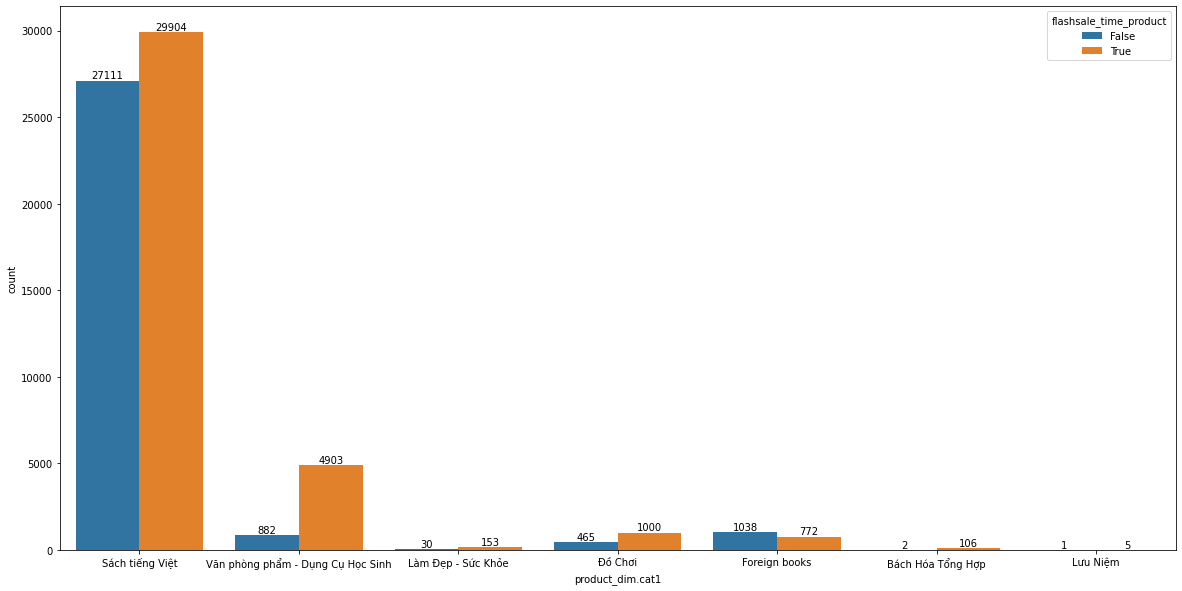

In [64]:
# Kiếm tra xem trong ngày có flashsale xem thử các category bán đột biện hay chiếm sức mua lớn hơn là
df = fhs_sales_flat_order_item_state_info_2022    \
                    .loc[fhs_sales_flat_order_item_state_info_2022['flashsale_day_product'] == True]

fig, ax = plt.subplots(figsize = (20, 10))
sns.countplot(data = df, 
          x = df['product_dim.cat1'],

          hue = 'flashsale_time_product', ax = ax, palette="tab10")
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

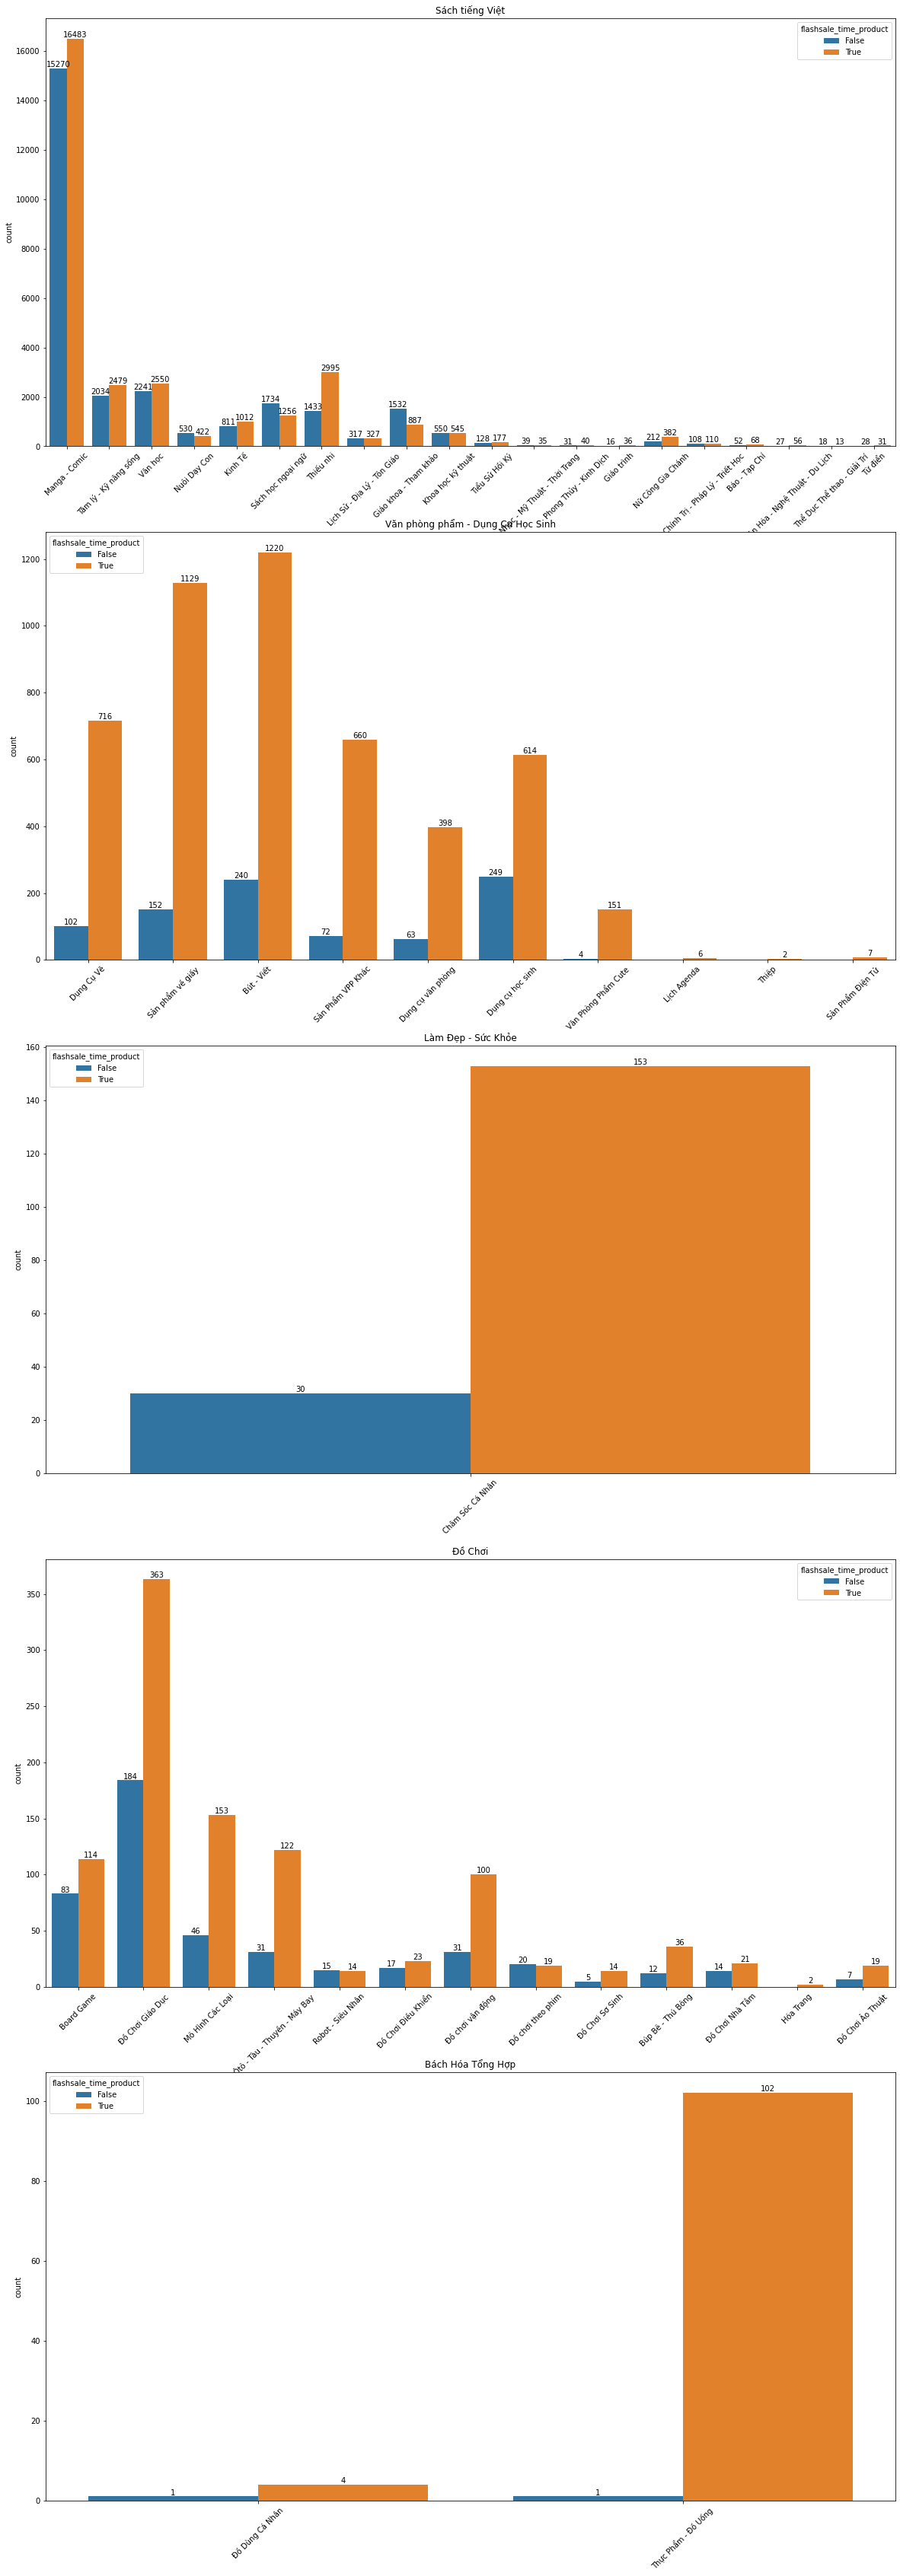

In [65]:
# Show ra các caterory 2 của từng loại cat1
# ----------------------------------------------------------------------------------#
df = fhs_sales_flat_order_item_state_info_2022    \
                    .loc[(fhs_sales_flat_order_item_state_info_2022['flashsale_day_product'] == True)
                    &    (fhs_sales_flat_order_item_state_info_2022['product_dim.cat1'] == 'Sách tiếng Việt')]

fig, ax = plt.subplots(5, 1,figsize = (20, 60))
sns.countplot(data = df, 
          x = df['product_dim.cat2'],

          hue = 'flashsale_time_product', ax = ax[0], palette="tab10")
ax[0].set_title('Sách tiếng Việt')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
for container in ax[0].containers:
    ax[0].bar_label(container, label_type='edge')

# ----------------------------------------------------------------------------------#
df1 = fhs_sales_flat_order_item_state_info_2022    \
                    .loc[(fhs_sales_flat_order_item_state_info_2022['flashsale_day_product'] == True)
                    &    (fhs_sales_flat_order_item_state_info_2022['product_dim.cat1'] == 'Văn phòng phẩm - Dụng Cụ Học Sinh')]

sns.countplot(data = df1, 
          x = df1['product_dim.cat2'],

          hue = 'flashsale_time_product', ax = ax[1], palette="tab10")
ax[1].set_title('Văn phòng phẩm - Dụng Cụ Học Sinh')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
for container in ax[1].containers:
    ax[1].bar_label(container, label_type='edge')

# ----------------------------------------------------------------------------------#
df2 = fhs_sales_flat_order_item_state_info_2022    \
                    .loc[(fhs_sales_flat_order_item_state_info_2022['flashsale_day_product'] == True)
                    &    (fhs_sales_flat_order_item_state_info_2022['product_dim.cat1'] == 'Làm Đẹp - Sức Khỏe')]

sns.countplot(data = df2, 
          x = df2['product_dim.cat2'],

          hue = 'flashsale_time_product', ax = ax[2], palette="tab10")
ax[2].set_title('Làm Đẹp - Sức Khỏe')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)
for container in ax[2].containers:
    ax[2].bar_label(container, label_type='edge')


# ----------------------------------------------------------------------------------#
df3 = fhs_sales_flat_order_item_state_info_2022    \
                    .loc[(fhs_sales_flat_order_item_state_info_2022['flashsale_day_product'] == True)
                    &    (fhs_sales_flat_order_item_state_info_2022['product_dim.cat1'] == 'Đồ Chơi')]

sns.countplot(data = df3, 
          x = df3['product_dim.cat2'],

          hue = 'flashsale_time_product', ax = ax[3], palette="tab10")
ax[3].set_title('Đồ Chơi')
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation=45)
for container in ax[3].containers:
    ax[3].bar_label(container, label_type='edge')

# ----------------------------------------------------------------------------------#
df4 = fhs_sales_flat_order_item_state_info_2022    \
                    .loc[(fhs_sales_flat_order_item_state_info_2022['flashsale_day_product'] == True)
                    &    (fhs_sales_flat_order_item_state_info_2022['product_dim.cat1'] == 'Bách Hóa Tổng Hợp')]

sns.countplot(data = df4, 
          x = df4['product_dim.cat2'],

          hue = 'flashsale_time_product', ax = ax[4], palette="tab10")
ax[4].set_title('Bách Hóa Tổng Hợp')
ax[4].set_xticklabels(ax[4].get_xticklabels(), rotation=45)
for container in ax[4].containers:
    ax[4].bar_label(container, label_type='edge')

for ax_i in ax:
    ax_i.set_xlabel('')

- Xem thử loại category bán mạnh vào ngày nào thời điểm nào

In [66]:
df = fhs_sales_flat_order_item_state_info_2022    \
                    .loc[(fhs_sales_flat_order_item_state_info_2022['flashsale_day_product'] == True)
                    &    (fhs_sales_flat_order_item_state_info_2022['product_dim.cat1'] == 'Sách tiếng Việt')]

# bây giờ chúng ta chỉ gọi lại hàm ở trên để visualize các thứ muốn xem

- Khác period id trong flash sale nhưng vẫn cùng ngày 
- Có thể lược bỏ, tuy nhiên có thể dẫn đến sai sót khi tính số lượng bán hàng chia cho total item

- Temp là sản phẩm flashsale = True, sản phẩm bán trong ngày flashsale_day = True, sản phẩm được bán trong flashsale_time = True

### cùng một sku, xem tần suất sale check những sản phẩm có tần suất sale lớn, xem sức bán có ổn định hay không

https://stackoverflow.com/questions/43954182/unable-to-align-bins-in-a-histogram-of-datetime-objects-using-the-hist-functio

- vẽ đường cho mỗi biểu đồ

- dùng piechart để kết luận phần trăm